In [600]:
#-------------------------------------------------------------------
# Reads everyone's general storm info and does some analysis. Also
# read the az shear files and look at those.
#
# Last updated on Drive: 6/7/21
#
# NOTE: This runs in the gempak environment (formerly py3.7). The
#       only thing that doesn't work is cartopy.
#
# NOTE: This code is edited from 'read_geninfo_azshr' from the 
#       group project. It performs much of the same analysis but 
#       with the novel environmental constraints.
#
# LAST NOTE: This is the same code as "merger-environment-analysis"
#            except this code uses SFCOA. The other code uses RUC
#            profiles. The variables in this code are read from a
#            text file (sfcoa-variables), which was sent from my
#            SPC computer. These variables were extracted directly
#            from the SFCOA gempak files. Full profiles were NOT
#            read. Therefore, if anyone wants different variables,
#            I'll have to change some things to extract the full
#            RUC profiles (WITH the SFCOA bottom level) to compute
#            other parameters (assuming they don't exist in the 
#            SFCOA grids... like 0–500-m SRH, e.g.).
#-------------------------------------------------------------------

In [601]:
#-------------------------------------------------------------------
# Libraries.
#-------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
import os
from os import walk
import math
from datetime import datetime,date,timedelta,timezone
from datetime import time as dttime
import matplotlib.dates as mdates
import scipy.stats
import matplotlib

# --- cartopy does not work in the gempak environment (yet) ---
# import cartopy
# import cartopy.crs as ccrs
# import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

def split(word):
    return list(word)

def convert(s):
 
    # initialization of string to ""
    new = ""
 
    # traverse in the string
    for x in s:
        new += x
 
    # return string
    return new



In [602]:
#-------------------------------------------------------------------
# Functions.
#-------------------------------------------------------------------
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))



In [603]:
#-------------------------------------------------------------------
# Read all data.
#-------------------------------------------------------------------
ns = 561 # number of reports

filepath = '/Users/matthewflournoy/Desktop/stuff/PostDoc/Research/' + \
           'GroupProject_CellMergers/data/gen_storm_info/'
    
file = filepath + 'all-general-storm-info.csv'
data = pd.read_csv(file,sep=',',header=None,skiprows=1,encoding='latin-1')

stormIDi = data[0].values[0:ns]
reportID = data[1].values[0:ns]
date = data[2].values[0:ns]
yeari = data[3].values[0:ns]
monthi = data[4].values[0:ns]
day = data[5].values[0:ns]
time = data[6].values[0:ns]
error = data[7].values[0:ns]
stormtypei = data[8].values[0:ns]
slat1i = data[13].values[0:ns]
slon1i = data[14].values[0:ns]
elat1i = data[15].values[0:ns]
elon1i = data[16].values[0:ns]
sti = data[17].values[0:ns]
eti = data[18].values[0:ns]
bndyi = data[23].values[0:ns]
hcri = data[24].values[0:ns]
mergeri = data[25].values[0:ns]
merger_timesi = data[26].values[0:ns]
bndy_orientationi = data[27].values[0:ns]
dni = data[28].values[0:ns]
notes = data[29].values[0:ns]

num_stms = len(stormIDi)

#-------------------------------------------------------------------
# Find number of individual storms and their indices.
#-------------------------------------------------------------------
inds = np.ones(num_stms)*np.nan
inds[0] = np.nan # first case is a "do not include"

count = 0
countblah = 1
for i in np.arange(1,len(stormIDi)):
    if (stormIDi[i] != stormIDi[i-1]) and \
       (dni[i] != 1.):
        count += 1
        inds[i] = 1
    if (stormIDi[i] != stormIDi[i-1]):
        countblah += 1
    else:
        inds[i] = 0
                        
#-------------------------------------------------------------------
# Extract desired info from the above arrays for each storm.
#-------------------------------------------------------------------
hits = np.where(inds == 1)

stormID = stormIDi[hits]
month = monthi[hits]
year = yeari[hits]
st = sti[hits]
et = eti[hits]
slat = slat1i[hits]
slon = slon1i[hits]
elat = elat1i[hits]
elon = elon1i[hits]
bndy = bndyi[hits]
hcr = hcri[hits]
merger = mergeri[hits]
merger_times = merger_timesi[hits]
bndy_orientation = bndy_orientationi[hits]

#-------------------------------------------------------------------
# Added my MDF 1/13/22 for Jannick Fischer.
#-------------------------------------------------------------------
hits_tor = np.where((stormtypei == 'TORNADO') & (inds == 1))

print('Number of tornadic storms:',np.shape(hits_tor)[1])

stormIDtor = stormIDi[hits_tor]
monthtor = monthi[hits_tor]
yeartor = yeari[hits_tor]
sttor = sti[hits_tor]
ettor = eti[hits_tor]
slattor = slat1i[hits_tor]
slontor = slon1i[hits_tor]
elattor = elat1i[hits_tor]
elontor = elon1i[hits_tor]
bndytor = bndyi[hits_tor]
hcrtor = hcri[hits_tor]
mergertor = mergeri[hits_tor]
merger_timestor = merger_timesi[hits_tor]
bndy_orientationtor = bndy_orientationi[hits_tor]

num_stms_tor = np.shape(hits_tor)[1]

#-------------------------------------------------------------------
# End Fischer edits.
#-------------------------------------------------------------------
  
print('All storms read!')
print('Reports:',len(stormIDi))
print('Individual storms:',countblah)
print('Final number of storms (removed "do not includes"):',count)
print('-------')

num_stms = count




Number of tornadic storms: 170
All storms read!
Reports: 561
Individual storms: 470
Final number of storms (removed "do not includes"): 342
-------


In [604]:
#-------------------------------------------------------------------
# Read az shear data for the final storms.
#-------------------------------------------------------------------
filepath = '/Users/matthewflournoy/Desktop/stuff/PostDoc/Research/' + \
           'GroupProject_CellMergers/data/azshr/'
num_azshr = len(os.listdir(filepath))

print('there are',num_azshr,'az shear files ... now extract the',num_stms,'that we care about')

# --- make arrays ---
blah = 65 # longest possible timeseries for a single storm
fstormtime0  = np.ones((num_stms,blah))*np.nan
fstormlat0   = np.ones((num_stms,blah))*np.nan
fstormlon0   = np.ones((num_stms,blah))*np.nan
fstormazshr0 = np.ones((num_stms,blah))*np.nan

inds_azshr  = np.ones((num_stms))*np.nan

# --- get file names ---
_, _, azshr_names = next(walk(filepath))

# --- extract files associated with the desired storms ---
count = 0
for i in np.arange(0,num_stms):
    stm = stormID[i] + '-azshr.txt'
        
    ind_azshr = np.where(np.array(azshr_names) == stm)[0]
    
    # --- try searching without the '.txt'
    if not ind_azshr:
        stm = stormID[i] + '-azshr'
        ind_azshr = np.where(np.array(azshr_names) == stm)[0]
        
    # --- try searching with llazshearmax (for 2007)'
    if not ind_azshr:
        stm = stormID[i] + '-llazshearmax'
        ind_azshr = np.where(np.array(azshr_names) == stm)[0]
        
    # --- now if it can't find it, we have a problem ---
    if not ind_azshr:
        print(stm,'... did not find an az shear timeseries for this storm')
    
    # --- now open up and read the file ---
    else:
        inds_azshr[count] = int(i)
        
        file = filepath + azshr_names[int(ind_azshr)]
        data = pd.read_csv(file,sep=',',header=None,skiprows=0)
        
        num_lines = len(data[0].values)
        
        fstormtime0[count,0:num_lines]  = data[0].values
        fstormlat0[count,0:num_lines]   = data[1].values
        fstormlon0[count,0:num_lines]   = data[2].values
        fstormazshr0[count,0:num_lines] = data[3].values
        
        count += 1
        
print('matched up',count,'/',num_stms,'storms with az shear timeseries')

# --- get rid of nans ---
fstormtime  = fstormtime0[0:count,:]
fstormlat   = fstormlat0[0:count,:]
fstormlon   = fstormlon0[0:count,:]
fstormazshr = fstormazshr0[0:count,:]

#-------------------------------------------------------------------
# Extract only relevant data for the final storms.
#-------------------------------------------------------------------
print('---------------------')
print('now extracting inhomogeneity data only for the',count,'storms')

inds_azshrf = inds_azshr[~np.isnan(inds_azshr)]
num_inds = len(inds_azshrf)

fstormID = ['']*num_inds
fstormst = np.ones((num_inds))*np.nan
fstormet = np.ones((num_inds))*np.nan
fmonth = np.ones((num_inds))*np.nan
fslat = np.ones((num_inds))*np.nan
fslon = np.ones((num_inds))*np.nan
felat = np.ones((num_inds))*np.nan
felon = np.ones((num_inds))*np.nan
fbndy = np.ones((num_inds))*np.nan
fhcr = np.ones((num_inds))*np.nan
fmerger = np.ones((num_inds))*np.nan
fmerger_times = ['']*num_inds
fbndy_orientation = np.ones((num_inds))*np.nan

for i in np.arange(0,num_inds):
    fstormID[i] = stormID[int(inds_azshrf[i])]
    fstormst[i] = st[int(inds_azshrf[i])]
    fstormet[i] = et[int(inds_azshrf[i])]
    fmonth[i] = month[int(inds_azshrf[i])]
    fslat[i] = slat[int(inds_azshrf[i])]
    fslon[i] = slon[int(inds_azshrf[i])]
    felat[i] = elat[int(inds_azshrf[i])]
    felon[i] = elon[int(inds_azshrf[i])]
    fbndy[i] = bndy[int(inds_azshrf[i])]
    fhcr[i] = hcr[int(inds_azshrf[i])]
    fmerger[i] = merger[int(inds_azshrf[i])]
    fmerger_times[i] = merger_times[int(inds_azshrf[i])]
    fbndy_orientation[i] = bndy_orientation[int(inds_azshrf[i])]
            
# --- last part, now pull merger times into a float array ---
blah = 13 # largest number of mergers for one storm
fmerger_times_flt = np.ones((num_inds,blah))*np.nan
for i in np.arange(0,num_inds):    
    if (isinstance(fmerger_times[i],str) == True):
        asdf = fmerger_times[i].split(' ')
        if(asdf[-1] == ''):
            asdf = asdf[0:len(asdf)-1]
            
            if(asdf[-1] == ''):
                asdf = asdf[0:len(asdf)-1]
                
        num_mergers = len(asdf)                
        fmerger_times_flt[i,0:num_mergers] = np.array(asdf).astype(np.float)
                    
print('extracted inhomogeneity data only for the',count,'storms')
print('Az shear data and env data are now matched up with each other')

print('------------------------------------')

#-------------------------------------------------------------------
# Last, set all -99900.0 values of az shear to nan.
#-------------------------------------------------------------------
inds_missing1 = np.where(fstormazshr == -99900.0)[0]
inds_missing2 = np.where(fstormazshr == -99900.0)[1]

fstormazshr[inds_missing1,inds_missing2] = np.nan


there are 348 az shear files ... now extract the 342 that we care about
matched up 342 / 342 storms with az shear timeseries
---------------------
now extracting inhomogeneity data only for the 342 storms
extracted inhomogeneity data only for the 342 storms
Az shear data and env data are now matched up with each other
------------------------------------


In [605]:
#-------------------------------------------------------------------
# Now loop through these storms and look at interesting stuff.
#
# Things to do:
#  1) map all storm tracks
#  2) histogram UTC time of storms
#  3) number of storms with environmental inhomogeneities
#  4) trends in az shear throughout storm lifecycles
#  5) trends in az shear before/after mergers
#  6) histogram of how many cell mergers occurred for each storm
#-------------------------------------------------------------------
# --- number of storms with mergers ---
num_mergers  = int(sum(fmerger))
frac_mergers = num_mergers/len(fmerger)*100

print(int(num_mergers),'/',count,'storms experienced at least one cell merger (', + \
      np.round(frac_mergers,1),'%)')

# --- look at az shear trends around the time of the FIRST merger ---
countgoodpre  = 0
countbadearly = 0
countgoodpost = 0
countbadlate  = 0
countgoodpreandpost = 0
buff = 3 # number of volume updates included in the trend calculation, inclusive (e.g., 3 ~ 10 mins)

#-------------------------------------------------------------------
# First loop through and count how many trends I can calculate.
# Then set the arrays and do it again.
#-------------------------------------------------------------------
for i in np.arange(0,count):
    flag_pre  = 0
    flag_post = 0
    
    if fmerger[i] == 1:
        mergetime = fmerger_times_flt[i,0]*100 # convert from HHMM to HHMMSS (lol)
        azshr = fstormazshr[i,np.where(fstormtime[i,:]>0.)[0]]
        azshrtimes = fstormtime[i,np.where(fstormtime[i,:]>0.)[0]]
                
        azshr_mergetime,idx = find_nearest(azshrtimes,mergetime)
        
        if azshr_mergetime < mergetime:
            pre_azshr  = azshr[idx-buff:idx]
            post_azshr = azshr[idx+1:idx+1+buff]
                
        if azshr_mergetime > mergetime:
            pre_azshr  = azshr[idx-1-buff:idx-1]
            post_azshr = azshr[idx:idx+buff]

        pre_mean  = np.mean(pre_azshr)
        post_mean = np.mean(post_azshr)
        mean_diff = post_mean - pre_mean
        
        try:
            pre_trend  = pre_azshr[-1] - pre_azshr[0]
            countgoodpre += 1
            flag_pre = 1
        except:
            countbadearly += 1
        try:
            post_trend = post_azshr[-1] - post_azshr[0]
            countgoodpost += 1
            flag_post = 1
        except:
            countbadlate += 1
            
        if (flag_pre == 1) and (flag_post == 1):
            countgoodpreandpost += 1

print('-------')
print(countgoodpre,'/',num_mergers,'have a valid pre-merge trend')
print(countgoodpost,'/',num_mergers,'have a valid post-merge trend')
print(countgoodpreandpost,'/',num_mergers,'have a valid pre- and post-merge trend')
print('-------')
print(countbadearly,'/',num_mergers,'mergers were too early to have a valid pre-merge trend')
print(countbadlate,'/',num_mergers,'mergers were too late to have a valid post-merge trend')
print('-------')
print('now filling arrays')

#-------------------------------------------------------------------
# Set arrays and loop through again.
#-------------------------------------------------------------------
azshr_pre_mean   = np.ones((countgoodpre))*np.nan
azshr_pre_trend  = np.ones((countgoodpre))*np.nan
azshr_post_mean  = np.ones((countgoodpost))*np.nan
azshr_post_trend = np.ones((countgoodpost))*np.nan
azshr_mean_diff  = np.ones((countgoodpreandpost))*np.nan

countgoodpre  = 0
countbadearly = 0
countgoodpost = 0
countbadlate  = 0
countgoodpreandpost = 0

for i in np.arange(0,count):
    flag_pre  = 0
    flag_post = 0
    
    if fmerger[i] == 1:
        mergetime = fmerger_times_flt[i,0]*100 # convert from HHMM to HHMMSS (lol)
        azshr = fstormazshr[i,np.where(fstormtime[i,:]>0.)[0]]
        azshrtimes = fstormtime[i,np.where(fstormtime[i,:]>0.)[0]]
                
        azshr_mergetime,idx = find_nearest(azshrtimes,mergetime)
        
        if azshr_mergetime < mergetime:
            pre_azshr  = azshr[idx-buff:idx]
            post_azshr = azshr[idx+1:idx+1+buff]
                
        if azshr_mergetime > mergetime:
            pre_azshr  = azshr[idx-1-buff:idx-1]
            post_azshr = azshr[idx:idx+buff]
        
        try:
            pre_trend  = pre_azshr[-1] - pre_azshr[0]
            
            azshr_pre_mean[countgoodpre] = np.nanmean(pre_azshr)
            azshr_pre_trend[countgoodpre] = pre_trend
            
            countgoodpre += 1
            flag_pre = 1
            
        except:
            countbadearly += 1
        try:
            post_trend = post_azshr[-1] - post_azshr[0]
            
            azshr_post_mean[countgoodpost] = np.nanmean(post_azshr)
            azshr_post_trend[countgoodpost] = post_trend
            
            countgoodpost += 1
            flag_post = 1
        except:
            countbadlate += 1
            
        if (flag_pre == 1) and (flag_post == 1):
            azshr_mean_diff[countgoodpreandpost] = azshr_post_mean[countgoodpost-1] \
                                                 - azshr_pre_mean[countgoodpre-1]
                        
            countgoodpreandpost += 1
            
print('arrays filled')
print('-------')



167 / 342 storms experienced at least one cell merger ( 48.8 %)
-------
139 / 167 have a valid pre-merge trend
159 / 167 have a valid post-merge trend
131 / 167 have a valid pre- and post-merge trend
-------
28 / 167 mergers were too early to have a valid pre-merge trend
8 / 167 mergers were too late to have a valid post-merge trend
-------
now filling arrays
arrays filled
-------


In [606]:
#-------------------------------------------------------------------
# Look for nans, then output some simple stats.
#-------------------------------------------------------------------
x = azshr_pre_trend
num_hit = len(np.where(np.isnan(x)==False)[0])
azshr_pre_trend_final = x[np.where(np.isnan(x)==False)[0]]
print('Out of',countgoodpre,'/',num_mergers,'valid pre-merge trends ... we are now working with',num_hit)

x = azshr_post_trend
num_hit = len(np.where(np.isnan(x)==False)[0])
azshr_post_trend_final = x[np.where(np.isnan(x)==False)[0]]

print('Out of',countgoodpost,'/',num_mergers,'valid post-merge trends ... we are now working with',num_hit)

x = azshr_mean_diff
num_hit = len(np.where(np.isnan(x)==False)[0])
azshr_mean_diff_final = x[np.where(np.isnan(x)==False)[0]]

print('Out of',countgoodpreandpost,'/',num_mergers,'valid pre- and post-merge trend pairs',\
      '... we are now working with',num_hit)

# --- some stats ---
azshr_pre_trend_final_mean = np.mean(azshr_pre_trend_final)
azshr_post_trend_final_mean = np.mean(azshr_post_trend_final)
azshr_mean_diff_final_mean = np.mean(azshr_mean_diff_final)
azshr_mean_diff_final_med = np.median(azshr_mean_diff_final)

print('Mean pre-merger az shear trend:',np.round(azshr_pre_trend_final_mean,7))
print('Mean post-merger az shear trend:',np.round(azshr_post_trend_final_mean,7))
print('Mean pre-/post-merge az shear difference:',np.round(azshr_mean_diff_final_mean,7))
print('Median pre-/post-merge az shear difference:',np.round(azshr_mean_diff_final_med,7))



Out of 139 / 167 valid pre-merge trends ... we are now working with 133
Out of 159 / 167 valid post-merge trends ... we are now working with 152
Out of 131 / 167 valid pre- and post-merge trend pairs ... we are now working with 126
Mean pre-merger az shear trend: 0.0004653
Mean post-merger az shear trend: 9.09e-05
Mean pre-/post-merge az shear difference: 1.67e-05
Median pre-/post-merge az shear difference: 0.0003617


In [607]:
#-----------------------------------------------------------------------
# Now look at characteristics of the merger events. Of storms with
# mergers, how many mergers did each storm have?
#
# Also bring az shear (fstormazshr) and analysis time (fstormtime) 
# down here.
#
# NOTE: Edited by MDF (20 July 2023 and onwards) for the follow-up
#       analysis.
#-----------------------------------------------------------------------
print('here we are working with the',count,'storms that have az shear files')

countmerge = 0
countnomerge = 0
for i in np.arange(0,count):
    ind = np.where(fmerger_times_flt[i,:] > 0.)[0]
    if len(ind) == 0:
        countnomerge += 1
    else :
        countmerge += 1
        
print('of these',count,'storms,',countmerge,'had at least one merger')

# --- initialize arrays and loop again ---
asdf = 65
num_merge = np.ones((countmerge))*np.nan
fstormID_merge = ['']*countmerge
fstormtime_merge = np.ones((countmerge,asdf))*np.nan
fstormazshr_merge = np.ones((countmerge,asdf))*np.nan
merge_per_hr = np.ones((countmerge))*np.nan
inds_merge = np.ones((countmerge))*np.nan

index = 0
for i in np.arange(0,count):
    ind = np.where(fmerger_times_flt[i,:] > 0.)[0]
    if len(ind) == 0:
        next
    else:
        inds_merge[index] = i
        num_merge[index] = len(ind)
        
        fstormID_merge[index] = fstormID[i]
        fstormtime_merge[index,:] = fstormtime[i,:]
        fstormazshr_merge[index,:] = fstormazshr[i,:]
                
        # --- calculate merge_per_hr for each storm ---
        start = str(int(fstormtime_merge[index,0]))
        end = str(int(fstormtime_merge[index,np.max(np.where(fstormtime_merge[index,:] > 0.)[0])]))
        
        # --- put the zeroes back out front ---
        if len(start) == 6:
            start = start
        if len(start) == 5:
            start = '0' + start
        if len(start) == 4:
            start = '00' + start
        if len(start) == 3:
            start = '000' + start
        if len(start) == 2:
            start = '0000' + start
        if len(start) == 1:
            start = '00000' + start
        if len(end) == 6:
            end = end
        if len(end) == 5:
            end = '0' + end
        if len(end) == 4:
            end = '00' + end
        if len(end) == 3:
            end = '000' + end
        if len(end) == 2:
            end = '0000' + end
        if len(end) == 1:
            end = '00000' + end
        
        startdt = datetime.strptime(start,'%H%M%S')
        enddt = datetime.strptime(end,'%H%M%S')
        diffdt = (enddt - startdt).seconds/60./60. # convert to hours
                
        merge_per_hr[index] = num_merge[index]/diffdt
        index += 1

merge_mean = np.round(np.mean(num_merge),4)
merge_med  = np.round(np.median(num_merge),4)
merge_min  = np.min(num_merge)
merge_max  = np.max(num_merge)

num_merge_mean = np.round(np.mean(merge_per_hr),4)
num_merge_med = np.round(np.median(merge_per_hr),4)
num_merge_min = np.min(merge_per_hr)
num_merge_max = np.max(merge_per_hr)

print('---------------------------------------------------------------------')
print('of these',countmerge,'storms, the mean number of mergers is:',merge_mean)
print('of these',countmerge,'storms, the median number of mergers is:',merge_med)
print('of these',countmerge,'storms, the smallest number of mergers is:',merge_min)
print('of these',countmerge,'storms, the largest number of mergers is:',merge_max)
print('---------------------------------------------------------------------')
print('of these',countmerge,'storms, the average number of mergers per hour is:',num_merge_mean)
print('of these',countmerge,'storms, the median number of mergers per hour is:',num_merge_med)
print('of these',countmerge,'storms, the smallest number of mergers per hour is:',num_merge_min)
print('of these',countmerge,'storms, the largest number of mergers per hour is:',num_merge_max)
print('---------------------------------------------------------------------')

#-----------------------------------------------------------------------
# Now, of the storms with multiple mergers, when did they happen in the
# storm's lifecycle? Did they all happen close to each other or far
# apart from each other?
#-----------------------------------------------------------------------
diffi = np.ones((count))*np.nan
for i in np.arange(0,count):
    ind = np.where(fmerger_times_flt[i,:] > 0.)[0]
    
    if len(ind) > 1:
        first = str(int(fmerger_times_flt[i,ind[0]]))
        last = str(int(fmerger_times_flt[i,ind[-1]]))
        
        if len(last) == 4:
            last = last
        if len(last) == 3:
            last = '0' + last
        if len(last) == 2:
            last = '00' + last
        if len(last) == 1:
            last = '000' + last
        if len(first) == 4:
            first = first
        if len(first) == 3:
            first = '0' + first
        if len(first) == 2:
            first = '00' + first
        if len(first) == 1:
            first = '000' + first
            
        firstdt = datetime.strptime(first,'%H%M')
        lastdt = datetime.strptime(last,'%H%M')
        
        diffi[i] = int((lastdt - firstdt).seconds/60.) # convert to minutes
                                
diff = diffi[np.where(diffi>0.)[0]]

print('of the',countmerge,'storms that had mergers,',len(diff),'had more than one')
# print(diff)



here we are working with the 342 storms that have az shear files
of these 342 storms, 166 had at least one merger
---------------------------------------------------------------------
of these 166 storms, the mean number of mergers is: 2.3133
of these 166 storms, the median number of mergers is: 2.0
of these 166 storms, the smallest number of mergers is: 1.0
of these 166 storms, the largest number of mergers is: 13.0
---------------------------------------------------------------------
of these 166 storms, the average number of mergers per hour is: 1.1879
of these 166 storms, the median number of mergers per hour is: 0.9329
of these 166 storms, the smallest number of mergers per hour is: 0.23016431174477336
of these 166 storms, the largest number of mergers per hour is: 5.6722689075630255
---------------------------------------------------------------------
of the 166 storms that had mergers, 89 had more than one


In [608]:
#---------------------------------------------------------------------------------------------------
# Now look at different characteristics of az shear around these
# merger events. Discriminate az shear based on whether it occurs
# within X mins (10?) of a cell merger. This is the ridiculous part
# that identifies merger periods and looks at az shear before, during,
# and after mergers as well as during "other" periods.
#
# This cell does a lot and spits out a lot of text.
#
# buff_mn = time between consecutive mergers to consider them a single "event" (mins)
# buff_vs = # of volume scans before/after a merger "event" to consider them "pre-"/"post-" merge
#
# NOTE: buff_vs has to be at least one order of magnitude less than buff_mn. For example,
#       if buff_mn = 20, buff_vs = 2 or 1. If buff_mn = 30, buff_vs = 3 or less.
#---------------------------------------------------------------------------------------------------
buff_mn = 30. # time between consecutive mergers to consider them a single event (mins)
buff_vs = 2   # number of volume scans before/after a merger to consider them pre-/post-merge
    
shrtimesdt   = np.empty((countmerge,65),dtype=datetime)
mergetimesdt = np.empty((countmerge,65),dtype=datetime)

flags_full = [['' for i in range(13)] for j in range(countmerge)]

azshr_pre    = np.ones((countmerge,65))*np.nan
azshr_during = np.ones((countmerge,65))*np.nan
azshr_post   = np.ones((countmerge,65))*np.nan
azshr_others = np.ones((countmerge,65))*np.nan

# --- added by MDF to get the time of each merger event ---
time_pre    = np.ones((countmerge,65))*np.nan
time_during = np.ones((countmerge,65))*np.nan
time_post   = np.ones((countmerge,65))*np.nan
time_others = np.ones((countmerge,65))*np.nan

count1 = 0
count2 = 0

countgoodpre  = 0
countgoodpost = 0
countbadpre   = 0
countbadpost  = 0
countgoodpreandpost = 0

count_merger_events = 0 # total number of merger events
count_mergers_storm = np.ones((countmerge))*np.nan # number of merger events per storm
count_premiddle_storm = np.ones((countmerge,65))*np.nan # number of individual mergers during each event for each storm
                                                        # in this setup, these are flags for the pre-/post-azshr arrays
count_postmiddle_storm = np.ones((countmerge,65))*np.nan # number of individual mergers during each event for each storm
                                                         # in this setup, these are flags for the pre-/post-azshr arrays

for i in np.arange(0,countmerge):
    restartff = np.ones((5))*np.nan
    beer = 0
    count_mergers_storm[i] = 0
    
    # --- get az shear analysis times for each storm ---
    shrtimes = fstormtime_merge[i,np.where(fstormtime_merge[i,:]>0.)[0]]
    azshrs   = fstormazshr_merge[i,np.where(fstormtime_merge[i,:]>0.)[0]]
    
    shrtimesdti = np.empty((len(shrtimes)),dtype=datetime)
    for t in np.arange(0,len(shrtimes)):
        time_str = str(int(shrtimes[t]))
        
        if len(time_str) == 6:
            time_str = time_str
        if len(time_str) == 5:
            time_str = '0' + time_str
        if len(time_str) == 4:
            time_str = '00' + time_str
        if len(time_str) == 3:
            time_str = '000' + time_str
        if len(time_str) == 2:
            time_str = '0000' + time_str
        if len(time_str) == 1:
            time_str = '00000' + time_str
        
        shrtimesdti[t] = datetime.strptime(time_str,'%H%M%S')
        
    shrtimesdt[i,0:len(shrtimes)] = shrtimesdti
    
    # --- now get merge times for each storm ---
    ii = int(inds_merge[i])
    
    mergetimes = fmerger_times_flt[ii,np.where(fmerger_times_flt[ii,:]>0.)[0]]*100
        
    mergetimesdti = np.empty((len(mergetimes)),dtype=datetime)
    for t in np.arange(0,len(mergetimes)):
        time_str = str(int(mergetimes[t]))
        
        if len(time_str) == 6:
            time_str = time_str
        if len(time_str) == 5:
            time_str = '0' + time_str
        if len(time_str) == 4:
            time_str = '00' + time_str
        if len(time_str) == 3:
            time_str = '000' + time_str
            
        print(time_str)
        mergetimesdti[t] = datetime.strptime(time_str,'%H%M%S')
        
    mergetimesdt[i,0:len(mergetimes)] = mergetimesdti
        
    #-----------------------------------------------------------------------
    # Okay now we have shear (fstormazshr_merge), shear analysis times
    # (shrtimesdt), and merge times (mergetimesdt) organized for each storm.
    # All are on the same indices. Now analyze shear around mergers.
    #-----------------------------------------------------------------------
    
    #-----------------------------------------------------------------------
    # This will contain flags defining what the mergers are.
    # Options are: 'lonely','start','middle','end'.
    #-----------------------------------------------------------------------
    flags = ['']*len(mergetimes)
    
    ########################################################################
    # ONE MERGER
    # ----------
    # If there's only one merger, easily bin az shear times into "before",
    # "during", and "after" based on the buff.
    ########################################################################
    if len(mergetimes) == 1:
        print('1 merger',mergetimes)
        flags = 'lonely'
        flags_full[i][0] = 'lonely'
        print(flags)
        print(flags_full[i][:])
        
        closest_azshr,idx = find_nearest(shrtimes,mergetimes[0])
        
        if closest_azshr < mergetimes[0]:
            el = 'early'
        if closest_azshr > mergetimes[0]:
            el = 'late'
        
        # --- define before-merge times ---
        pre = []
        post = []
        if (flags == 'lonely') & (el == 'early'):
            pre0   = np.arange(idx-buff_vs+1,idx+1)
            post0  = np.arange(idx+1,idx+buff_vs+1)
            
            print('pre',pre0)
            print('post',post0)
            
            pre.append(pre0)
            post.append(post0)
            
        if (flags == 'lonely') & (el == 'late'):
            pre0   = np.arange(idx-buff_vs,idx)
            post0  = np.arange(idx,idx+buff_vs)
            
            print('pre',pre0)
            print('post',post0)
            
            pre.append(pre0)
            post.append(post0)
        
        preflat = np.unique(np.concatenate(pre).ravel())
        postflat = np.unique(np.concatenate(post).ravel())

        print('--------------')
        print('pre',preflat)
        print('--------------')
        print('post',postflat)
        print('--------------')

        all_preduringpost = np.concatenate((preflat,postflat))

        shrtimes_inds = np.arange(0,len(shrtimes))
        print(shrtimes_inds)

        others = np.setdiff1d(shrtimes_inds,all_preduringpost)
        print('others',others)
        print('--------------')
        hello1 = 0
        hello2 = 0
        try:
            print('pre shr times:',shrtimes[preflat])
            countgoodpre += 1
            hello1 = 1
            
            num_shr = len(preflat)
            azshr_pre[i,0:num_shr] = azshrs[preflat]
            count_premiddle_storm[i,0:num_shr] = 1
            
            time_pre[i,0:num_shr] = shrtimes[preflat]
        except:
            print('no pre shr, merger occurred too early')
            countbadpre += 1
        try:
            print('post shr times:',shrtimes[postflat])
            countgoodpost += 1
            hello2 = 1
            
            num_shr = len(postflat)
            azshr_post[i,0:num_shr] = azshrs[postflat]
            count_postmiddle_storm[i,0:num_shr] = 1
            
            time_post[i,0:num_shr] = shrtimes[preflat]
        except:
            print('no post shr, merger occurred too late')
            countbadpost += 1
            
        if (hello1 == 1) & (hello2 == 1):
            countgoodpreandpost += 1
            
        hello1 = 0
        hello2 = 0
        
        print('other shr times:',shrtimes[others])
        num_shr = len(others)
        azshr_others[i,0:num_shr] = azshrs[others]
        time_others[i,0:num_shr] = shrtimes[others]
        print('--------------')
        print('**************')
        
        count1 += 1
        
        count_merger_events += 1
        
        count_mergers_storm[i] += 1
        
        print('--------------------------------------------------')
        
    ########################################################################
    # TWO+ MERGERS
    # --------------------
    # If there's more than one merger, it gets complicated. Use diff and
    # buff below to bin az shear times into before/during/after.
    ########################################################################
    else:
        #-----------------------------------------------------------------------
        # Loop through the merger datetimes and isolate merger events using 
        # the buff above.
        #-----------------------------------------------------------------------
        print('*****************')
        print('2+ mergers',mergetimes)
        
        m = 0
        while m < 14:
            #-----------------------------------------------------------------------
            # Do the first time in its own loop. This is because we only search
            # for other merge times within "buff" mins AFTER this merger.
            #-----------------------------------------------------------------------
            if mergetimesdt[i,m] == None:
                break
            if m == 0:
                print(mergetimesdt[i,m])
                
                try:
                    diff = (mergetimesdt[i,m+1] - mergetimesdt[i,m]).seconds/60 # convert to mins
                except:
                    # --- you've run out of merge times, you're done with this storm ---
                    print('ERROR: you dumbass, this should never happen')
                    break

                # --- use diff and buff to define the start and end of merger times ---
                if diff <= buff_mn:
                    flags[m] = 'start'    
                    flags_full[i][m] = flags[m]
                    
                else:
                    flags[m] = 'lonely'
                    flags_full[i][m] = flags[m]
                    count_merger_events += 1
                    count_mergers_storm[i] += 1
                m += 1
            #-----------------------------------------------------------------------
            # Now loop through all other merge times and search for other merge 
            # times within "buff" mins BEFORE and AFTER this merger.
            #-----------------------------------------------------------------------
            else:
                print(mergetimesdt[i,m])
                # --- this should always work because m > 0
                diff0 = (mergetimesdt[i,m] - mergetimesdt[i,m-1]).seconds/60
                try:
                    # --- this won't work when you get to the end of the timeseries ---
                    diff1 = (mergetimesdt[i,m+1] - mergetimesdt[i,m]).seconds/60
                    
                    # --- use diff_mn and buff to define the start and end of merger times ---
                    if (diff0 <= buff_mn) & (diff1 <= buff_mn):
                        flags[m] = 'middle'
                        flags_full[i][m] = flags[m]
                    if (diff0 <= buff_mn) & (diff1 > buff_mn):
                        flags[m] = 'end'
                        flags_full[i][m] = flags[m]
                        count_merger_events += 1
                        count_mergers_storm[i] += 1
                    if (diff0 > buff_mn) & (diff1 <= buff_mn):
                        flags[m] = 'start'
                        flags_full[i][m] = flags[m]
                    if (diff0 > buff_mn) & (diff1 > buff_mn):
                        flags[m] = 'lonely'
                        flags_full[i][m] = flags[m]
                        count_mergers_storm[i] += 1 # MDF ADDED THIS
                except:
                    # --- you've run out of merge times, you're done with this storm ---
                    if (diff0 <= buff_mn):
                        flags[m] = 'end'
                        flags_full[i][m] = flags[m]
                        count_merger_events += 1
                        count_mergers_storm[i] += 1
                    if (diff0 > buff_mn):
                        flags[m] = 'lonely'
                        flags_full[i][m] = flags[m]
                        count_merger_events += 1
                        count_mergers_storm[i] += 1
                    
                m += 1                    
        
        count2 += 1
        
        print(flags)
        print('--------------------------------------------------')
    
        num_shrtimes = len(shrtimes)
        num_mergetimes = len(mergetimes)

        count_index = 0
        
        restart = 0

        pre = []
        during = []
        post = []
        for b in np.arange(0,num_mergetimes):
            print(b,'...',mergetimesdt[i,b].time(),' -- ',flags[b])

            closest_azshr,idx = find_nearest(shrtimes,mergetimes[b])

            if closest_azshr < mergetimes[b]:
                el = 'early'
            if closest_azshr > mergetimes[b]:
                el = 'late'

            print('closest az shr time:',closest_azshr,'[',idx,'] ... it is',el)

            if (flags[b] == 'lonely') & (el == 'early'):
                pre0   = np.arange(idx-buff_vs+1,idx+1)
                post0  = np.arange(idx+1,idx+buff_vs+1)

                print('pre',pre0)
                print('post',post0)

                pre.append(pre0)
                post.append(post0)
                
                restart += 1
                restartff[beer] = restart
                restart = 0
                print('number of mergers in this event',restartff[beer])
                beer += 1
                

            if (flags[b] == 'lonely') & (el == 'late'):
                pre0   = np.arange(idx-buff_vs,idx)
                post0  = np.arange(idx,idx+buff_vs)

                print('pre',pre0)
                print('post',post0)

                pre.append(pre0)
                post.append(post0)
                
                restart += 1
                restartff[beer] = restart
                restart = 0
                print('number of mergers in this event',restartff[beer])
                beer += 1

            if (flags[b] == 'start') & (el == 'early'):
                pre0    = np.arange(idx-buff_vs+1,idx+1)
                during0 = np.arange(idx+1,idx+buff_vs+1)

                print('pre',pre0)
                print('during',during0)

                pre.append(pre0)
                during.append(during0)
                
                restart += 1

            if (flags[b] == 'start') & (el == 'late'):
                pre0    = np.arange(idx-buff_vs,idx)
                during0 = np.arange(idx,idx+buff_vs)

                print('pre',pre0)
                print('during',during0)

                pre.append(pre0)
                during.append(during0)
                
                restart += 1

            if (flags[b] == 'middle') & (el == 'early'):
                during0 = np.arange(idx-buff_vs+1,idx+buff_vs+1)

                print('during',during0)

                during.append(during0)
                
                restart += 1

            if (flags[b] == 'middle') & (el == 'late'):
                during0 = np.arange(idx-buff_vs,idx+buff_vs)

                print('during',during0)

                during.append(during0)
                
                restart += 1

            if (flags[b] == 'end') & (el == 'early'):
                during0 = np.arange(idx-buff_vs+1,idx+1)
                post0   = np.arange(idx+1,idx+buff_vs+1)

                print('during',during0)
                print('post',post0)

                during.append(during0)
                post.append(post0)
                
                restart += 1
                restartff[beer] = restart
                restart = 0
                print('number of mergers in this event',restartff[beer])
                beer += 1

            if (flags[b] == 'end') & (el == 'late'):
                during0 = np.arange(idx-buff_vs,idx)
                post0   = np.arange(idx,idx+buff_vs)

                print('during',during0)
                print('post',post0)

                during.append(during0)
                post.append(post0)
                
                restart += 1
                restartff[beer] = restart
                restart = 0
                print('number of mergers in this event',restartff[beer])
                beer += 1
                
        print(pre)
        print(post)
        print(restartff)
        
        restartfffpre  = np.ones((np.shape(pre)))
        restartfffpost = np.ones((np.shape(post)))
        
        for ipa in np.arange(0,np.shape(pre)[0]):
            restartfffpre[ipa,:] = restartff[ipa]
        for ipa in np.arange(0,np.shape(post)[0]):
            restartfffpost[ipa,:] = restartff[ipa]
            
        # -----------------------------------------------------------------
        # I now have restartfff and pre/post organized in the same way,
        # but now I can't figure out how to reorganize restartfff in the
        # same way that I reorganize pre and post below. I use "unique"
        # to resort those, but that won't work for restartfff.
        # -----------------------------------------------------------------
        preflat = np.unique(np.concatenate(pre).ravel())
        postflat = np.unique(np.concatenate(post).ravel())
        
        preflat_inds = np.unique(np.concatenate(pre).ravel(),return_index=True)
        postflat_inds = np.unique(np.concatenate(post).ravel(),return_index=True)
        
        print('preflat',preflat_inds)
        print('postflat',postflat_inds)
        
        restartpreflat = np.concatenate(restartfffpre).ravel()[preflat_inds[1]]
        restartpostflat = np.concatenate(restartfffpost).ravel()[postflat_inds[1]]
        
        print('preflat',restartpreflat)
        print('postflat',restartpostflat)
                
        if len(during) != 0:
            duringflat = np.unique(np.concatenate(during).ravel())

        print('--------------')
        print('pre',preflat)
        
        if len(during) != 0:
            print('--------------')
            print('during',duringflat)

        print('--------------')
        print('post',postflat)
        print('--------------')

        if len(during) != 0:
            all_preduringpost = np.concatenate((preflat,duringflat,postflat))
        else:
            all_preduringpost = np.concatenate((preflat,postflat))

        shrtimes_inds = np.arange(0,len(shrtimes))

        others = np.setdiff1d(shrtimes_inds,all_preduringpost)
        print('others',others)
        print('--------------')
        hello1 = 0
        hello2 = 0
        
        if np.min(preflat) < 0:
            print('no pre shr, any merger occurred too early')
            countbadpre += 1
        else:
            print('pre shr times:',shrtimes[preflat])
            countgoodpre += 1
            hello1 = 1
            
            num_shr = len(preflat)
            azshr_pre[i,0:num_shr] = azshrs[preflat]
            count_premiddle_storm[i,0:num_shr] = restartpreflat
            
            time_pre[i,0:num_shr] = shrtimes[preflat]
                
        if len(during) != 0:
            print(shrtimes,duringflat)
            
            try:
                print('during shr times:',shrtimes[duringflat])
                num_shr = len(duringflat)
                azshr_during[i,0:num_shr] = azshrs[duringflat]
                
                time_during[i,0:num_shr] = shrtimes[duringflat]
            except:
                print('some invalid during shr times, need to chop them off')
                duringflatnew = duringflat[np.where((duringflat >= 0.) & (duringflat < len(shrtimes)))[0]]
                num_shr = len(duringflatnew)
                azshr_during[i,0:num_shr] = azshrs[duringflatnew]
                
                time_during[i,0:num_shr] = shrtimes[duringflatnew]
            
        try:
            print('post shr times:',shrtimes[postflat])
            countgoodpost += 1
            hello2 = 1
            
            num_shr = len(postflat)
            azshr_post[i,0:num_shr] = azshrs[postflat]
            time_post[i,0:num_shr] = shrtimes[postflat]
            count_postmiddle_storm[i,0:num_shr] = restartpostflat
        except:
            print('no post shr, any merger occurred too late')
            countbadpost += 1
            
        if (hello1 == 1) & (hello2 == 1):
            countgoodpreandpost += 1
            
        hello1 = 0
        hello2 = 0
        
        print('other shr times:',shrtimes[others])
        num_shr = len(others)
        azshr_others[i,0:num_shr] = azshrs[others]
        time_others[i,0:num_shr] = shrtimes[others]
        print('--------------')
        print('**************')
            
print('--------------------------------------------------------')
print('Number of storms with 1 merger:',count1)
print('Number of storms with >1 merger:',count2)
print('Number of storms with mergers:',count1+count2)
print('--------------------------------------------------------')    
print('Number of storms with valid pre-mergers:',countgoodpre)
print('Number of storms with bad pre-mergers:',countbadpre)
print('Number of storms with valid post-mergers:',countgoodpost)
print('Number of storms with bad post-mergers:',countbadpost)
print('Number of storms with valid pre- and post-merger combos:',countgoodpreandpost)
print('--------------------------------------------------------')
    
    
    



184800
190800
191800
201800
202800
*****************
2+ mergers [184800. 190800. 191800. 201800. 202800.]
1900-01-01 18:48:00
1900-01-01 19:08:00
1900-01-01 19:18:00
1900-01-01 20:18:00
1900-01-01 20:28:00
['start', 'middle', 'end', 'start', 'end']
--------------------------------------------------
0 ... 18:48:00  --  start
closest az shr time: 184952.0 [ 5 ] ... it is late
pre [3 4]
during [5 6]
1 ... 19:08:00  --  middle
closest az shr time: 190954.0 [ 9 ] ... it is late
during [ 7  8  9 10]
2 ... 19:18:00  --  end
closest az shr time: 191954.0 [ 11 ] ... it is late
during [ 9 10]
post [11 12]
number of mergers in this event 3.0
3 ... 20:18:00  --  start
closest az shr time: 202017.0 [ 23 ] ... it is late
pre [21 22]
during [23 24]
4 ... 20:28:00  --  end
closest az shr time: 203017.0 [ 25 ] ... it is late
during [23 24]
post [25 26]
number of mergers in this event 2.0
[array([3, 4]), array([21, 22])]
[array([11, 12]), array([25, 26])]
[ 3.  2. nan nan nan]
preflat (array([ 3,  4, 21

[ 4. nan nan nan nan]
preflat (array([1, 2]), array([0, 1]))
postflat (array([13, 14]), array([0, 1]))
preflat [4. 4.]
postflat [4. 4.]
--------------
pre [1 2]
--------------
during [ 3  4  6  7  8  9 10 11 12]
--------------
post [13 14]
--------------
others [ 0  5 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
--------------
pre shr times: [202000. 202500.]
[201457. 202000. 202500. 203000. 203501. 204001. 204502. 205002. 205503.
 210010. 210511. 211012. 211513. 212015. 212518. 213022. 213522. 214027.
 214527. 215032. 215533. 220036. 220539. 221043. 221544. 222046. 222547.
 223049. 223549. 224050. 224550. 225053. 225554. 230055.] [ 3  4  6  7  8  9 10 11 12]
during shr times: [203000. 203501. 204502. 205002. 205503. 210010. 210511. 211012. 211513.]
post shr times: [212015. 212518.]
other shr times: [201457. 204001. 213022. 213522. 214027. 214527. 215032. 215533. 220036.
 220539. 221043. 221544. 222046. 222547. 223049. 223549. 224050. 224550.
 225053. 225554. 230055.]
----

2+ mergers [221700. 224700.]
1900-01-01 22:17:00
1900-01-01 22:47:00
['start', 'end']
--------------------------------------------------
0 ... 22:17:00  --  start
closest az shr time: 221812.0 [ 8 ] ... it is late
pre [6 7]
during [8 9]
1 ... 22:47:00  --  end
closest az shr time: 224818.0 [ 14 ] ... it is late
during [12 13]
post [14 15]
number of mergers in this event 2.0
[array([6, 7])]
[array([14, 15])]
[ 2. nan nan nan nan]
preflat (array([6, 7]), array([0, 1]))
postflat (array([14, 15]), array([0, 1]))
preflat [2. 2.]
postflat [2. 2.]
--------------
pre [6 7]
--------------
during [ 8  9 12 13]
--------------
post [14 15]
--------------
others [ 0  1  2  3  4  5 10 11 16 17 18]
--------------
pre shr times: [220812. 221312.]
[213808. 214309. 214809. 215311. 215811. 220312. 220812. 221312. 221812.
 222312. 222814. 223316. 223818. 224318. 224818. 225327. 225827. 230332.
 230833.] [ 8  9 12 13]
during shr times: [221812. 222312. 223818. 224318.]
post shr times: [224818. 225327.]
oth

closest az shr time: 11850.0 [ 29 ] ... it is early
during [28 29 30 31]
8 ... 01:36:00  --  end
closest az shr time: 13354.0 [ 32 ] ... it is early
during [31 32]
post [33 34]
number of mergers in this event 8.0
9 ... 02:16:00  --  start
closest az shr time: 21401.0 [ 40 ] ... it is early
pre [39 40]
during [41 42]
10 ... 02:38:00  --  middle
closest az shr time: 23904.0 [ 45 ] ... it is late
during [43 44 45 46]
11 ... 02:56:00  --  middle
closest az shr time: 25408.0 [ 48 ] ... it is early
during [47 48 49 50]
12 ... 03:09:00  --  end
closest az shr time: 30913.0 [ 51 ] ... it is late
during [49 50]
post [51 52]
number of mergers in this event 4.0
[array([7, 8]), array([13, 14]), array([39, 40])]
[array([ 9, 10]), array([33, 34]), array([51, 52])]
[ 1.  8.  4. nan nan]
preflat (array([ 7,  8, 13, 14, 39, 40]), array([0, 1, 2, 3, 4, 5]))
postflat (array([ 9, 10, 33, 34, 51, 52]), array([0, 1, 2, 3, 4, 5]))
preflat [1. 1. 8. 8. 4. 4.]
postflat [1. 1. 8. 8. 4. 4.]
--------------
pre [ 

pre [7 8]
post [ 9 10]
number of mergers in this event 1.0
1 ... 23:52:00  --  start
closest az shr time: 235026.0 [ 25 ] ... it is early
pre [24 25]
during [26 27]
2 ... 00:10:00  --  end
closest az shr time: 1032.0 [ 29 ] ... it is late
during [27 28]
post [29 30]
number of mergers in this event 2.0
3 ... 01:23:00  --  lonely
closest az shr time: 12539.0 [ 44 ] ... it is late
pre [42 43]
post [44 45]
number of mergers in this event 1.0
4 ... 02:10:00  --  lonely
closest az shr time: 21046.0 [ 53 ] ... it is late
pre [51 52]
post [53 54]
number of mergers in this event 1.0
5 ... 02:58:00  --  lonely
closest az shr time: 25601.0 [ 62 ] ... it is early
pre [61 62]
post [63 64]
number of mergers in this event 1.0
[array([7, 8]), array([24, 25]), array([42, 43]), array([51, 52]), array([61, 62])]
[array([ 9, 10]), array([29, 30]), array([44, 45]), array([53, 54]), array([63, 64])]
[1. 2. 1. 1. 1.]
preflat (array([ 7,  8, 24, 25, 42, 43, 51, 52, 61, 62]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 

others [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 25 26]
--------------
pre shr times: [231422. 231923.]
post shr times: [232424. 232925.]
other shr times: [212855. 213357. 213858. 214358. 214858. 215358. 215859. 220359. 220859.
 221402. 221908. 222409. 222911. 223412. 223914. 224415. 224915. 225415.
 225916. 230416. 230918. 233431. 233931.]
--------------
**************
--------------------------------------------------
180900
1 merger [180900.]
lonely
['lonely', '', '', '', '', '', '', '', '', '', '', '', '']
pre [0 1]
post [2 3]
--------------
pre [0 1]
--------------
post [2 3]
--------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
others [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33]
--------------
pre shr times: [175947. 180451.]
post shr times: [180951. 181452.]
other shr times: [181955. 182455. 182957. 183457. 183957. 184457. 184959. 185459. 190000

pre [19 20]
--------------
during [21 22]
--------------
post [23 24]
--------------
others [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
--------------
pre shr times: [222428. 222929.]
[204912. 205412. 205912. 210413. 210914. 211414. 211914. 212414. 212914.
 213417. 213918. 214419. 214922. 215423. 215925. 220426. 220926. 221426.
 221926. 222428. 222929. 223432. 223933. 224433. 224933.] [21 22]
during shr times: [223432. 223933.]
post shr times: [224433. 224933.]
other shr times: [204912. 205412. 205912. 210413. 210914. 211414. 211914. 212414. 212914.
 213417. 213918. 214419. 214922. 215423. 215925. 220426. 220926. 221426.
 221926.]
--------------
**************
161000
1 merger [161000.]
lonely
['lonely', '', '', '', '', '', '', '', '', '', '', '', '']
pre [2 3]
post [4 5]
--------------
pre [2 3]
--------------
post [4 5]
--------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
others [ 0  1  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 2

[ 1.  1. nan nan nan]
preflat (array([11, 12, 18, 19]), array([0, 1, 2, 3]))
postflat (array([13, 14, 20, 21]), array([0, 1, 2, 3]))
preflat [1. 1. 1. 1.]
postflat [1. 1. 1. 1.]
--------------
pre [11 12 18 19]
--------------
post [13 14 20 21]
--------------
others [ 0  1  2  3  4  5  6  7  8  9 10 15 16 17]
--------------
pre shr times: [203013. 203517. 210528. 211032.]
no post shr, any merger occurred too late
other shr times: [193457. 193957. 194458. 194958. 195501. 200008. 200508. 201008. 201510.
 202011. 202513. 205020. 205520. 210025.]
--------------
**************
210700
1 merger [210700.]
lonely
['lonely', '', '', '', '', '', '', '', '', '', '', '', '']
pre [8 9]
post [10 11]
--------------
pre [8 9]
--------------
post [10 11]
--------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
others [ 0  1  2  3  4  5  6  7 12 13 14 15 16 17]
--------------
pre shr times: [205941. 210441.]
post shr times: [210941. 211444.]
other shr times: [201936. 202437. 202938. 203438.

closest az shr time: 232934.0 [ 10 ] ... it is late
pre [8 9]
during [10 11]
1 ... 23:36:00  --  middle
closest az shr time: 233434.0 [ 11 ] ... it is early
during [10 11 12 13]
2 ... 23:49:00  --  end
closest az shr time: 234934.0 [ 14 ] ... it is late
during [12 13]
post [14 15]
number of mergers in this event 3.0
[array([8, 9])]
[array([14, 15])]
[ 3. nan nan nan nan]
preflat (array([8, 9]), array([0, 1]))
postflat (array([14, 15]), array([0, 1]))
preflat [3. 3.]
postflat [3. 3.]
--------------
pre [8 9]
--------------
during [10 11 12 13]
--------------
post [14 15]
--------------
others [ 0  1  2  3  4  5  6  7 16 17 18 19 20]
--------------
pre shr times: [231933. 232434.]
[223930. 224430. 224930. 225430. 225930. 230432. 230933. 231433. 231933.
 232434. 232934. 233434. 233934. 234434. 234934. 235436. 235936.    436.
    936.   1436.   1936.] [10 11 12 13]
during shr times: [232934. 233434. 233934. 234434.]
post shr times: [234934. 235436.]
other shr times: [223930. 224430. 224930

pre [11 12]
post [13 14]
--------------
pre [11 12]
--------------
post [13 14]
--------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
others [ 0  1  2  3  4  5  6  7  8  9 10 15]
--------------
pre shr times: [194359. 194859.]
post shr times: [195359. 195900.]
other shr times: [184848. 185349. 185850. 190354. 190855. 191355. 191855. 192355. 192856.
 193357. 193858. 200401.]
--------------
**************
--------------------------------------------------
205300
211100
213300
*****************
2+ mergers [205300. 211100. 213300.]
1900-01-01 20:53:00
1900-01-01 21:11:00
1900-01-01 21:33:00
['start', 'middle', 'end']
--------------------------------------------------
0 ... 20:53:00  --  start
closest az shr time: 205859.0 [ 0 ] ... it is late
pre [-2 -1]
during [0 1]
1 ... 21:11:00  --  middle
closest az shr time: 210859.0 [ 2 ] ... it is early
during [1 2 3 4]
2 ... 21:33:00  --  end
closest az shr time: 213400.0 [ 7 ] ... it is late
during [5 6]
post [7 8]
number of mergers in

number of mergers in this event 3.0
[array([10, 11])]
[array([14, 15])]
[ 3. nan nan nan nan]
preflat (array([10, 11]), array([0, 1]))
postflat (array([14, 15]), array([0, 1]))
preflat [3. 3.]
postflat [3. 3.]
--------------
pre [10 11]
--------------
during [11 12 13 14]
--------------
post [14 15]
--------------
others [ 0  1  2  3  4  5  6  7  8  9 16 17 18 19 20 21 22 23 24]
--------------
pre shr times: [182358. 182859.]
[173354. 173854. 174355. 174855. 175355. 175855. 180355. 180855. 181356.
 181857. 182358. 182859. 183359. 183859. 184401. 184902. 185402. 185902.
 190403. 190903. 191409. 191909. 192410. 192914. 193416.] [11 12 13 14]
during shr times: [182859. 183359. 183859. 184401.]
post shr times: [184401. 184902.]
other shr times: [173354. 173854. 174355. 174855. 175355. 175855. 180355. 180855. 181356.
 181857. 185402. 185902. 190403. 190903. 191409. 191909. 192410. 192914.
 193416.]
--------------
**************
185200
190100
191000
191900
194700
*****************
2+ mergers

pre [7 8]
post [ 9 10]
--------------
pre [7 8]
--------------
post [ 9 10]
--------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
others [ 0  1  2  3  4  5  6 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36]
--------------
pre shr times: [30501. 31003.]
post shr times: [31504. 32004.]
other shr times: [22959. 23459. 23959. 24459. 24959. 25459. 25959. 32505. 33005. 33508.
 34008. 34508. 35009. 35510. 40010. 40510. 41010. 41510. 42011. 42511.
 43011. 43511. 44011. 44512. 45013. 45513. 50014. 50514. 51016. 51516.
 52016. 52517. 53017.]
--------------
**************
--------------------------------------------------
204700
1 merger [204700.]
lonely
['lonely', '', '', '', '', '', '', '', '', '', '', '', '']
pre [ 9 10]
post [11 12]
--------------
pre [ 9 10]
--------------
post [11 12]
--------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 2

In [609]:
#----------------------------------------------------------------
# Okay now we have merger-event AzShear values and times. Now
# create datetime objects (also including the DAY) so that we can
# find the right RUC analysis time to pair with each merger
# event.
#----------------------------------------------------------------
max_num_hrs_per_storm = 5 # random maximum number of hours per storm

all_final_ruchours = np.empty((countmerge,max_num_hrs_per_storm),dtype=object)
all_azshr_init = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
all_azshr_diff = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
all_azshr_diff_perc = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
for s in np.arange(0,countmerge): #0,countmerge
    this_ID = fstormID_merge[s]
    these_mergetimesdt = mergetimesdt[s,0:np.min(np.where(mergetimesdt[s,:] == None)[0])]
    
#     print('-------')
#     print('Working on storm',this_ID,'(index',s,')')
#     print('Number of merger events:',int(count_mergers_storm[s]))
#     print('Old merger times:',these_mergetimesdt)
        
    #----------------------------------------------------------------
    # First, add the date (from this_ID) to the time object.
    #----------------------------------------------------------------
    num_times = len(these_mergetimesdt)
    new_these_mergetimesdt = np.empty(num_times,dtype=object)
    
    for t in np.arange(0,num_times):
        this_hour_int = these_mergetimesdt[t].hour
        this_min_int = these_mergetimesdt[t].minute
        this_hour_str = str(these_mergetimesdt[t].hour)
        this_min_str = str(these_mergetimesdt[t].minute)
        
        if this_hour_int < 10:
            hzeroes = '0'
        else:
            hzeroes = ''
        
        if this_min_int < 10:
            mzeroes = '0'
        else:
            mzeroes = ''
        
        if this_hour_int >= 12:
            this_day_str = convert(split(this_ID)[0:8])
        else:
            this_day_str = datetime.strftime(datetime.strptime(convert(split(this_ID)[0:8]),'%Y%m%d') + \
                                         timedelta(hours=24),'%Y%m%d')
            
        total_str = this_day_str + hzeroes + this_hour_str + mzeroes + this_min_str
        
        this_new_dt = datetime.strptime(total_str,'%Y%m%d%H%M')
        new_these_mergetimesdt[t] = this_new_dt
        
    if flags_full[s][12] == '':
        these_flags = flags_full[s][0:np.min(np.where(np.array(flags_full[s][:]) == '')[0])]
    else:
        these_flags = flags_full[s][:]
    
#     print('New merger times:',new_these_mergetimesdt)
#     print('Merger flags:',these_flags)
    
    #----------------------------------------------------------------
    # Now we have the complete merger datetimes. Next loop through
    # all merger times (again... not efficient... I don't care) and 
    # get the final list of merger EVENT times (sorting out lonely
    # vs. start vs. end).
    #----------------------------------------------------------------
    final_mergehours = np.empty(int(count_mergers_storm[s]),dtype=object)
    final_count = 0
    for t in np.arange(0,num_times):
        this_flag = these_flags[t]
#         print(t,this_flag)
        if this_flag == 'lonely':
            # --- round down ---
            if new_these_mergetimesdt[t].minute < 30:
                final_mergehours[final_count] = new_these_mergetimesdt[t].replace(minute=0)
                
            # --- round up ---
            else:
                final_mergehours[final_count] = (new_these_mergetimesdt[t] + timedelta(hours=1)).replace(minute=0)
                
            final_count += 1
            
        if this_flag == 'start':
            #-------------------------------------------------
            # NOTE: These next two lines work
            #       for cases with multiple start/middle/end
            #       flags.
            #-------------------------------------------------
            end_inds = np.where((np.array(these_flags) == 'end'))[0]
            this_end = end_inds[np.min(np.where(end_inds > t)[0])]
            
            final_mergehour = (new_these_mergetimesdt[t] + (new_these_mergetimesdt[this_end] - \
                                             new_these_mergetimesdt[t]) / 2)
                        
            # --- round down ---
            if final_mergehour.minute < 30:
                final_mergehours[final_count] = final_mergehour.replace(minute=0)
                
            # --- round up ---
            else:
                final_mergehours[final_count] = (final_mergehour + timedelta(hours=1)).replace(minute=0)
                
            final_count += 1
            
#     print('Final RUC analysis times during mergers for this storm',final_mergehours)
    
    #-----------------------------------------------------------
    # Now save the desired RUC hours and across-merger AzShear
    # info.
    #-----------------------------------------------------------
    all_final_ruchours[s,0:int(count_mergers_storm[s])] = final_mergehours
    
    #----------------------------------------------------------------
    # Get across-merger AzShear info (by inefficiently looping
    # through all mergers for each storm again :) ).
    #----------------------------------------------------------------
#     print('pre',print(azshr_pre[s,:]))
#     print('post',print(azshr_post[s,:]))
        
    ind_azshr = 0
    ind_merge = 0
    for t in np.arange(0,num_times):
        this_flag = these_flags[t]
        
        if (this_flag == 'lonely') or (this_flag == 'start'):
            these_inds = [ind_azshr,ind_azshr+1]
            all_azshr_init[s,ind_merge] = np.mean(azshr_pre[s,these_inds])
            all_azshr_diff[s,ind_merge] = np.mean(azshr_post[s,these_inds] - azshr_pre[s,these_inds])
            all_azshr_diff_perc[s,ind_merge] = all_azshr_diff[s,ind_merge] / \
                                               np.mean(azshr_pre[s,these_inds]) * 100.
            
            ind_azshr += 2
            ind_merge += 1
            
    if ind_merge != int(count_mergers_storm[s]):
        print('OH NO, the number of mergers do not add up... this should not happen')
        
print('All RUC hours extracted')

All RUC hours extracted


In [610]:
#----------------------------------------------------------------
# This is where the code splits from 'merger-environment-analysis'
# because the environmental data are read in differently.
#
# In this cell, read the environmental information from 'sfcoa-
# analysis'.
#----------------------------------------------------------------
sfcoa_file = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/' + \
             '2023-MergersEnvironmentAnalysis/data/SFCOA-variables.txt'

sfcoa_data = pd.read_csv(sfcoa_file,',')

sfcoa_stormID = np.array(sfcoa_data['ID'])
sfcoa_time = np.array(sfcoa_data['time_YYYYMMDDHH'])
sfcoa_lat = np.array(sfcoa_data['lat'])
sfcoa_lon = np.array(sfcoa_data['lon'])
sfcoa_mlcape = np.array(sfcoa_data['mlcape'])
sfcoa_sbcape = np.array(sfcoa_data['sbcape'])
sfcoa_mucape = np.array(sfcoa_data['mucape'])
sfcoa_mlcin = np.array(sfcoa_data['mlcin'])
sfcoa_sbcin = np.array(sfcoa_data['sbcin'])
sfcoa_mucin = np.array(sfcoa_data['mucin'])
sfcoa_mllcl = np.array(sfcoa_data['mllcl'])
sfcoa_sblcl = np.array(sfcoa_data['sblcl'])
sfcoa_shr01u = np.array(sfcoa_data['shr01u'])
sfcoa_shr01v = np.array(sfcoa_data['shr01v'])
sfcoa_shr03u = np.array(sfcoa_data['shr03u'])
sfcoa_shr03v = np.array(sfcoa_data['shr03v'])
sfcoa_shr06u = np.array(sfcoa_data['shr06u'])
sfcoa_shr06v = np.array(sfcoa_data['shr06v'])
sfcoa_srh01 = np.array(sfcoa_data['srh01'])
sfcoa_srh03 = np.array(sfcoa_data['srh03'])
sfcoa_scp = np.array(sfcoa_data['scp'])

unique_IDs = np.unique(sfcoa_stormID)
num_unique_IDs = len(unique_IDs)
max_num_hrs_per_storm = 8

# --- allocate variable arrays ---
stormIDi = [['' for i in range(max_num_hrs_per_storm)] for j in range(num_unique_IDs)]
timei = [['' for i in range(max_num_hrs_per_storm)] for j in range(num_unique_IDs)]

mlcapei = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan # J/kg
sbcapei = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan
mucapei = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan
mlcini = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan # J/kg
sbcini = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan
mucini = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan
mllcli = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan # m
sblcli = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan

shr01i = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan # m/s
shr03i = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan
shr06i = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan

srh01i = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan
srh03i = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan
scpi = np.ones((num_unique_IDs,max_num_hrs_per_storm))*np.nan

for i in np.arange(0,num_unique_IDs):
    this_ID = unique_IDs[i]
    
    this_inds = np.where(sfcoa_stormID == this_ID)[0]
    
    stormIDi[i][0:len(this_inds)] = sfcoa_stormID[this_inds]
    timei[i][0:len(this_inds)] = sfcoa_time[this_inds]
    
    mlcapei[i,0:len(this_inds)] = sfcoa_mlcape[this_inds]
    sbcapei[i,0:len(this_inds)] = sfcoa_sbcape[this_inds]
    mucapei[i,0:len(this_inds)] = sfcoa_mucape[this_inds]
    mlcini[i,0:len(this_inds)] = sfcoa_mlcin[this_inds]
    sbcini[i,0:len(this_inds)] = sfcoa_sbcin[this_inds]
    mucini[i,0:len(this_inds)] = sfcoa_mucin[this_inds]
    mllcli[i,0:len(this_inds)] = sfcoa_mllcl[this_inds]
    sblcli[i,0:len(this_inds)] = sfcoa_sblcl[this_inds]
    
    shr01i[i,0:len(this_inds)] = (sfcoa_shr01u[this_inds]**2 + sfcoa_shr01v[this_inds]**2)**(0.5) * 0.514444 # m/s
    shr03i[i,0:len(this_inds)] = (sfcoa_shr03u[this_inds]**2 + sfcoa_shr03v[this_inds]**2)**(0.5) * 0.514444 # m/s
    shr06i[i,0:len(this_inds)] = (sfcoa_shr06u[this_inds]**2 + sfcoa_shr06v[this_inds]**2)**(0.5) * 0.514444 # m/s
    
    srh01i[i,0:len(this_inds)] = sfcoa_srh01[this_inds]
    srh03i[i,0:len(this_inds)] = sfcoa_srh03[this_inds]
    scpi[i,0:len(this_inds)] = sfcoa_scp[this_inds]
    
stormIDi = np.array(stormIDi)
timei = np.array(timei)

print('---------------')
print('SFCOA variables read in and organized by storm')  

#----------------------------------------------------------------
# Now pair the two datasets. We are working with the AzShear
# merger dataset...
#
#   fstormID_merge = merger storm IDs
#   all_final_ruchours = relevant hours (datetime)
#   all_azshear_diff = AzShear diff across each timeframe
#
# ... and the SFCOA dataset...
#   
#   stormIDi = all storm IDs (mergers and non-mergers)
#   timei = analysis hours (mergers and non-mergers ... string)
#   all variable names
#----------------------------------------------------------------

# --- initialize variable arrays ---
mlcape = np.ones((countmerge,max_num_hrs_per_storm))*np.nan # J/kg
sbcape = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
mucape = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
mlcin = np.ones((countmerge,max_num_hrs_per_storm))*np.nan # J/kg
sbcin = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
mucin = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
mllcl = np.ones((countmerge,max_num_hrs_per_storm))*np.nan # m
sblcl = np.ones((countmerge,max_num_hrs_per_storm))*np.nan

shr01 = np.ones((countmerge,max_num_hrs_per_storm))*np.nan # m/s
shr03 = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
shr06 = np.ones((countmerge,max_num_hrs_per_storm))*np.nan

srh01 = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
srh03 = np.ones((countmerge,max_num_hrs_per_storm))*np.nan
scp = np.ones((countmerge,max_num_hrs_per_storm))*np.nan

#----------------------------------------------------------------
# Loop through all merger storms.
#----------------------------------------------------------------
print_stuff = 'N'
for s in np.arange(0,countmerge): #0,countmerge
    this_ID = fstormID_merge[s]
    these_times = all_final_ruchours[s,:]
    
    this_year = these_times[0].year
    
    if this_year < 2005:
        continue
        
    num_times = len(np.where(these_times != None)[0])
    
    for t in np.arange(0,num_times):
        this_time = these_times[t]
        this_time_str = datetime.strftime(this_time,'%Y%m%d%H')
        
        if print_stuff == 'Y': print(s,'Merger time:',this_ID,this_time_str)
        
        match_ID = np.where(stormIDi[:,0] == this_ID)[0]
        if len(match_ID) == 0:
            if print_stuff == 'Y': print('Storm ID not found in SFCOA')
            continue
            
        time_ID = np.where(timei[match_ID,:][0] == this_time_str)[0]
        if len(time_ID) == 0:        
            if print_stuff == 'Y': print('This hour for this storm not found in SFCOA')
            if print_stuff == 'Y': print('Available times:',timei[match_ID,:][0])
            continue
        
        if print_stuff == 'Y': print('SFCOA match:',stormIDi[match_ID,time_ID],timei[match_ID,time_ID])
        if print_stuff == 'Y': print('-------')
            
        mlcape[s,t] = mlcapei[match_ID,time_ID]
        sbcape[s,t] = sbcapei[match_ID,time_ID]
        mucape[s,t] = mucapei[match_ID,time_ID]
        mlcin[s,t] = mlcini[match_ID,time_ID]
        sbcin[s,t] = sbcini[match_ID,time_ID]
        mucin[s,t] = mucini[match_ID,time_ID]
        mllcl[s,t] = mllcli[match_ID,time_ID]
        sblcl[s,t] = sblcli[match_ID,time_ID]
        
        shr01[s,t] = shr01i[match_ID,time_ID]
        shr03[s,t] = shr03i[match_ID,time_ID]
        shr06[s,t] = shr06i[match_ID,time_ID]
        
        srh01[s,t] = srh01i[match_ID,time_ID]
        srh03[s,t] = srh03i[match_ID,time_ID]
        scp[s,t] = scpi[match_ID,time_ID]
        
print('---------------')
print('SFCOA variables organized by merging storm')
            

---------------
SFCOA variables read in and organized by storm
---------------
SFCOA variables organized by merging storm


n = 126
Max/min MLLCL : 2722.125  | 421.5
Max/min AzShear difference : 0.015265000000000003  |  -0.026775
MAGNITUDE CHANGE STATS:
p: 0.0385
R2: 0.0341
slope: 2.205620480446205e-06


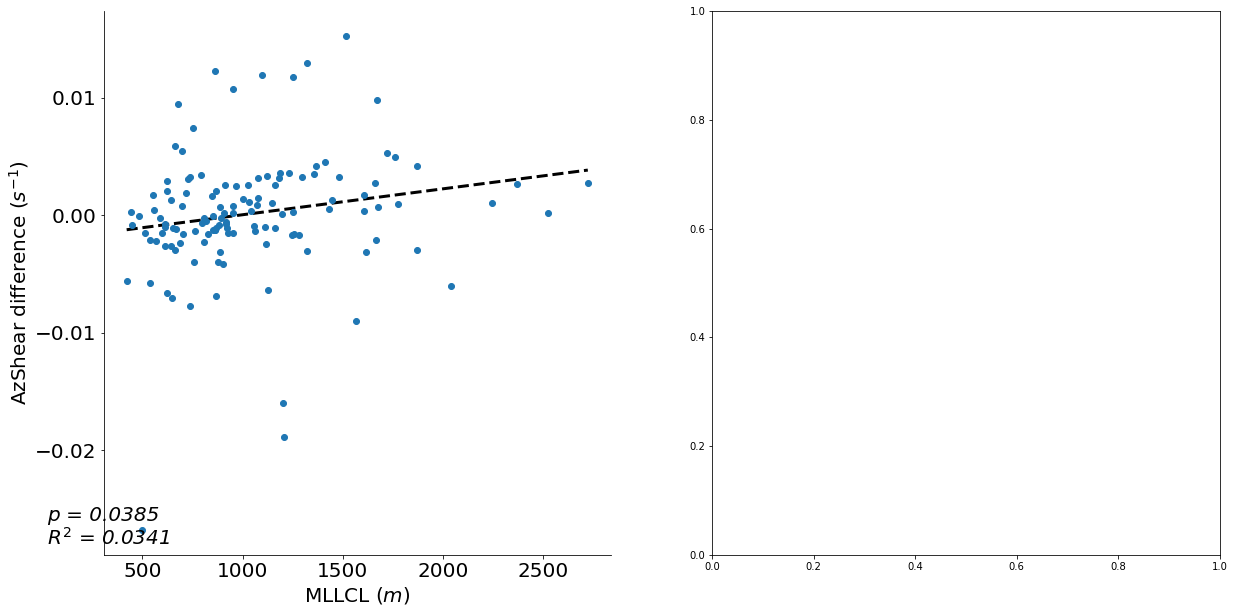

<Figure size 1440x720 with 0 Axes>

In [611]:
#-------------------------------------------------------------------
# Now make some plots (back to 'merger-environment-analysis' code).
#-------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

var = []
azshr = []
azshrperc = []

varis = 'MLLCL'
vari = mllcl

#     ca = np.ones((countmerge,max_num_hrs_per_storm))*np.nan # degrees
#     stp = np.ones((countmerge,max_num_hrs_per_storm))*np.nan # degrees
#     scp = np.ones((countmerge,max_num_hrs_per_storm))*np.nan # degrees


for s in np.arange(0,countmerge):
    a = np.where(vari[s,:] == vari[s,:])[0]
    b = np.where(all_azshr_diff[s,:] == all_azshr_diff[s,:])[0] # THIS IS THE MAIN LINE USED TO MAKE FIGS
#     b = np.where(all_azshr_init[s,:] == all_azshr_init[s,:])[0] # THIS IS A SPECIAL LINE FOR TESTING
    c = np.where(a == b)[0]
    
    inds_match = a[c]
            
    for i in np.arange(0,len(inds_match)):
        var.append(vari[s,inds_match[i]])
#         azshr.append(all_azshr_init[s,inds_match[i]]) # THIS IS THE SPECIAL LINE
        azshr.append(all_azshr_diff[s,inds_match[i]]) # THIS IS THE MAIN LINE
        azshrperc.append(all_azshr_diff_perc[s,inds_match[i]])
    
num_points = len(var)
var = np.array(var)
azshr = np.array(azshr)
azshrperc = np.array(azshrperc)

print('n =',num_points)
print('Max/min',varis,':',np.max(var),' |',np.min(var))
print('Max/min AzShear difference :',np.max(azshr),' | ',np.min(azshr))

# --- make a plot ---
plt.subplots(1,2)

ax = plt.subplot(1,2,1)
plt.scatter(var,azshr)

x = var
y = azshr
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
lbf = np.poly1d([slope,intercept])(np.unique(x))
p_value = np.round(p_value,4)
r_sq = np.round(r_value**2.,4)
plt.plot(np.unique(x),lbf,lw=3,color='k',ls='--',zorder=0,label='p = ' + str(p_value))

plt.xticks(fontsize=20)
plt.xlabel('MLLCL ($m$)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('AzShear difference ($s^{-1}$)',fontsize=20)
# plt.title('Change in ' + varis + ' (magnitude) | n = ' + str(num_points),fontsize=20)
# plt.legend(fontsize=20)

# --- add text ---
t1 = 'p = ' + str(p_value)
plt.text(23,-0.026,t1,fontsize=20,style='italic')
t2 = '$R^{2}$ = ' + str(r_sq)
plt.text(23,-0.028,t2,fontsize=20,style='italic')

ax.spines[['right','top']].set_visible(False)

print('MAGNITUDE CHANGE STATS:')
print('p:',p_value)
print('R2:',r_sq)
print('slope:',slope)

# --- percentage plot OFF
# ax = plt.subplot(1,2,2)
# plt.scatter(var,azshrperc)

# x = var
# y = azshrperc
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
# lbf = np.poly1d([slope,intercept])(np.unique(x))
# p_value = np.round(p_value,4)
# r_sq = np.round(r_value**2.,4)
# plt.plot(np.unique(x),lbf,lw=3,color='k',ls='--',zorder=0,label='p = ' + str(p_value))

# plt.xticks(fontsize=20)
# plt.xlabel(varis,fontsize=20)
# plt.yticks(fontsize=20)
# plt.title('Change in ' + varis + ' (percent) | n = ' + str(num_points),fontsize=20)
# plt.legend(fontsize=20)


# print('PERCENTAGE CHANGE STATS:')
# print('p:',p_value)
# print('R2:',r_sq)
# print('slope:',slope)

# folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
#          'plots/azshr-diff-params/NEW-SFCOA/'

# plt.savefig(folder+varis,dpi=200)

plt.show()
plt.clf()

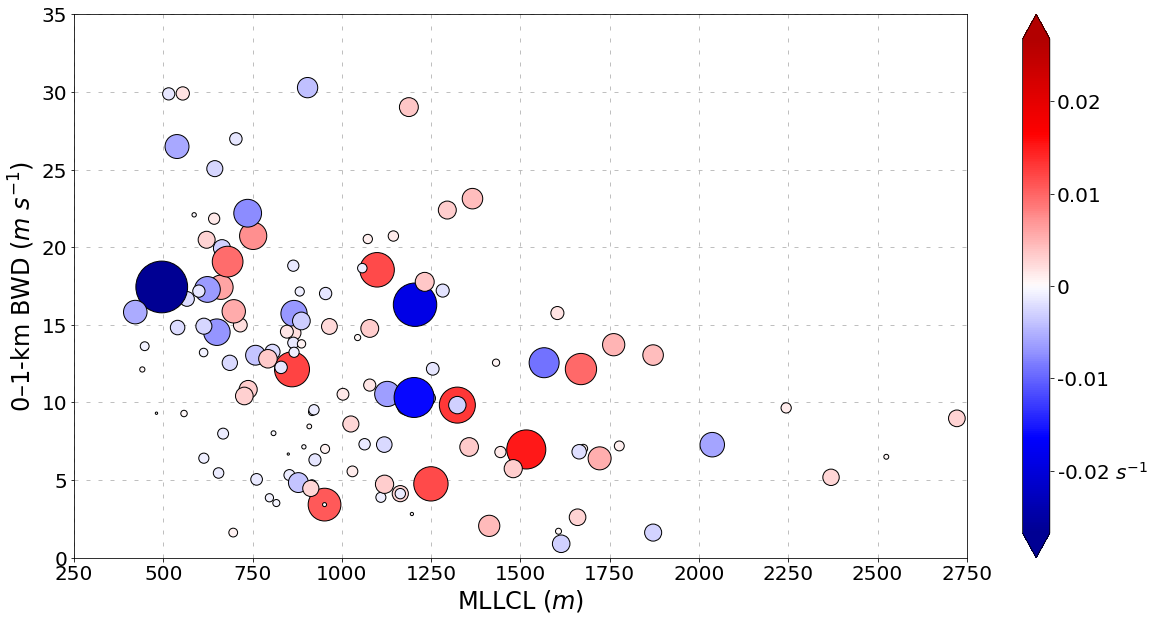

<Figure size 1440x720 with 0 Axes>

In [612]:
#----------------------------------------------------------------------
# Looks like MLLCL and 0–1-km shear have the strongest relationships
# with across-merger AzShear differences. Make a 2D plot examining
# this phase space.
#----------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

x = mllcl
y = shr01
z = azshr

var1 = []
var2 = []
azshr = []

for s in np.arange(0,countmerge):
    a = np.where(x[s,:] == x[s,:])[0]
    b = np.where(x[s,:] == x[s,:])[0]
    c = np.where(all_azshr_diff[s,:] == all_azshr_diff[s,:])[0]
    
    c = np.where((a == b) & (a == c))[0]
    
    inds_match = a[c]
        
    for i in np.arange(0,len(inds_match)):
        var1.append(x[s,inds_match[i]])
        var2.append(y[s,inds_match[i]])
        azshr.append(all_azshr_diff[s,inds_match[i]])
        
# --- make a plot ---
sizes = abs(np.array(azshr)*100000)
cmap = plt.get_cmap('seismic')
new_cmap = truncate_colormap(cmap,0.1,0.9)
plt.scatter(var1,var2,s=sizes,c=azshr,ec='k',cmap=new_cmap,zorder=10,norm=colors.CenteredNorm())
plt.xticks(np.arange(0,3000,250),fontsize=20)
plt.xlabel(r'MLLCL ($m$)',fontsize=24)
plt.yticks(fontsize=20)
plt.ylabel(r'0–1-km BWD ($m$ $s^{-1}$)',fontsize=24)
cb = plt.colorbar(extend='both')
cb.ax.set_yticklabels(['','-0.02 $s^{-1}$','-0.01','0','0.01','0.02'])
cb.ax.tick_params(labelsize=20)

plt.grid(ls=(0,(5,10)),zorder=0)

plt.xlim(250,2750)
plt.ylim(0,35)

folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
         'plots/NEW-SFCOA/'

title = '2D-MLLCL-SHR01-scatter'
# plt.savefig(folder+title,dpi=200)

plt.show()
plt.clf()




(8, 11)


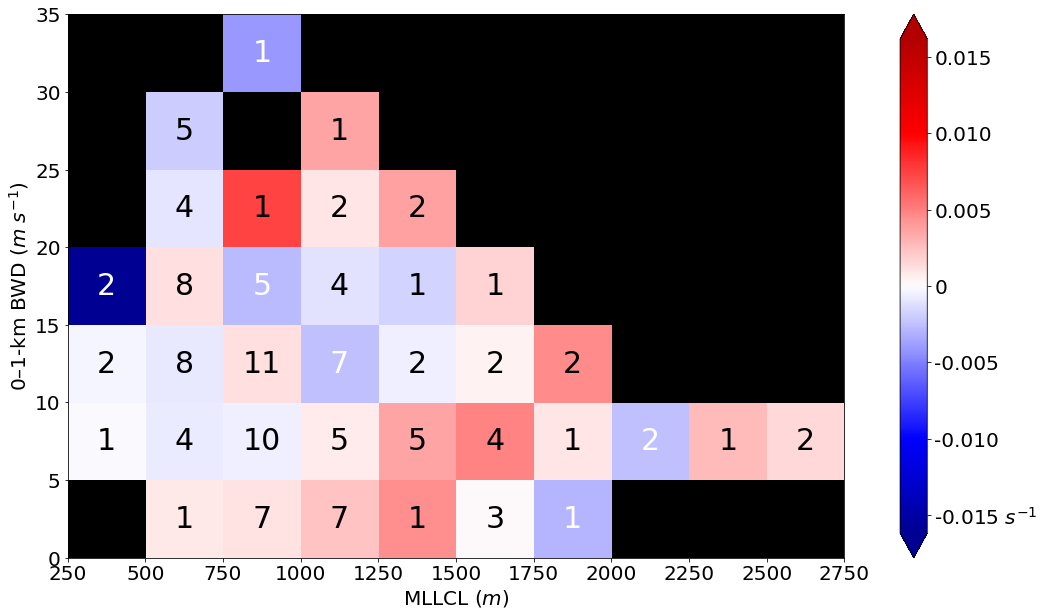

<Figure size 1440x720 with 0 Axes>

In [613]:
#----------------------------------------------------------------------
# Make a second plot binning the x and y axes and computing mean
# across-merger AzShear differences in each bin.
#
# First compute the bins.
#----------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

b1s = 250
b1e = 3000
b1inc = 250
b2s = 0
b2e = 40
b2inc = 5

num_b1 = len(np.arange(b1s,b1e,b1inc))
num_b2 = len(np.arange(b2s,b2e,b2inc))

num_inbin  = np.ones((num_b2,num_b1))*np.nan
mean_azshr = np.ones((num_b2,num_b1))*np.nan

b1c = 0
for b1 in np.arange(b1s,b1e,b1inc):
    b2c = 0
    for b2 in np.arange(b2s,b2e,b2inc):
        # --- define the bin ---
        b1l = b1
        b1h = b1+b1inc
        b2l = b2
        b2h = b2+b2inc
        
#         print('--- BIN',b1,b2,'---')
#         print('MLLCL:',b1l,'–',b1h)
#         print('SHR01:',b2l,'–',b2h)
        
        hit_lcl = np.where((var1 >= b1l) & (var1 < b1h))[0]
        hit_shr = np.where((var2 >= b2l) & (var2 < b2h))[0]
        
        hits = []
        
        for h in np.arange(0,len(hit_lcl)):
            question_hit = np.where(hit_shr == hit_lcl[h])[0]
            if question_hit == question_hit:
                hits.append(hit_lcl[h])
                    
        hits = np.array(hits)
        
#         print('Number of hits:',hits)
        
        if len(hits) >= 1:
            azshr_bin = []
            for i in np.arange(0,len(hits)):
                azshr_bin.append(azshr[hits[i]])
                
            azshr_bin = np.array(azshr_bin)
            mean_azshr[b2c,b1c] = np.mean(azshr_bin)
            num_inbin[b2c,b1c] = len(hits)
            
#             print(num_inbin[b1c,b2c],mean_azshr[b1c,b2c])
            
        b2c += 1
        
    b1c += 1
    
#----------------------------------------------------------------------
# Now plot!
#----------------------------------------------------------------------
plt.figure(figsize=(20,10))

xs = np.arange(b1s,b1e,b1inc)
ys = np.arange(b2s,b2e,b2inc)

print(np.shape(mean_azshr))
plt.imshow(mean_azshr,cmap=new_cmap,norm=colors.CenteredNorm())
plt.gca().invert_yaxis()

ax = plt.gca()
ax.set_facecolor('black')

xticks = np.arange(-0.5,10.5)
xlabels = np.arange(250,3000,250)
plt.xticks(xticks,labels=xlabels,fontsize=20)
plt.xlabel('MLLCL ($m$)',fontsize=20)

yticks = np.arange(-0.5,7)
ylabels = np.arange(0,40,5)
plt.yticks(yticks,labels=ylabels,fontsize=20)
plt.ylabel('0–1-km BWD ($m$ $s^{-1}$)',fontsize=20)

plt.xlim(-0.5,9.5)
plt.ylim(-0.5,6.5)

xcount = 0
for x in xs:
    ycount = 0
    for y in ys:
        if num_inbin[ycount,xcount] == num_inbin[ycount,xcount]:            
            if mean_azshr[ycount,xcount] < -0.002:
                fc = 'white'
            else:
                fc = 'black'
            plt.text(xcount,ycount,int(num_inbin[ycount,xcount]),fontsize=30,\
                     va='center',ha='center',color=fc)
        ycount += 1
    xcount += 1
    
cb = plt.colorbar(extend='both')
cb.ax.tick_params(labelsize=20)
cb.ax.set_yticklabels(['','-0.015 $s^{-1}$','-0.010','-0.005','0','0.005','0.010','0.015'])

folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
         'plots/NEW-SFCOA/'

title = '2D-MLLCL-SHR01-bins'
# plt.savefig(folder+title,dpi=200)

plt.show()
plt.clf()




In [634]:
#----------------------------------------------------------------------
# Now perform the same analysis but for random 30-min time periods
# during each supercell's life cycle. This will test if the trends
# we're seeing (especially in MLLCL) are actually tied to merger
# windows and not just ubiquitious across the supercell lifecycle.
#----------------------------------------------------------------------
import random

# First step is to grab all storm tracks and generate one random 30-min 
# AzShear difference for each storm. Repeat this 100 times. I think the
# code for this exists up above. Have one array (342 x 100 or something
# close) store the AzShear difference value, and another (same size)
# store the stormID/datetime associated with that time period. This
# will be used to relate that 30-min window to the RUC grids. This will
# be the novel part to code.
#
# Ultimately, I need to not only calculate/store the 30-min AzShear
# differences, but also the storm/time info.

num_storms = np.shape(fstormazshr)[0]

print(num_storms)

#-------------------------------------------------------------------
# Loop through minute intervals.
#-------------------------------------------------------------------
mstart = int(30) # 5
mend = int(35) # 125

num_mtimes = int((mend-mstart)/5) # number of different minute intervals to test
num_iters = 100 # number of times to randomly select different starting times

slopes = np.ones((num_mtimes,num_iters))*np.nan
rvalues = np.ones((num_mtimes,num_iters))*np.nan
pvalues = np.ones((num_mtimes,num_iters))*np.nan

max_num_bins = 100 # huge number of max number of bins
up_percs = np.ones((num_mtimes,max_num_bins,num_iters))*np.nan
down_percs = np.ones((num_mtimes,max_num_bins,num_iters))*np.nan
bin_n = np.ones((num_mtimes,max_num_bins,num_iters))*np.nan

diff = np.ones((num_mtimes,num_storms,num_iters))*np.nan
init = np.ones((num_mtimes,num_storms,num_iters))*np.nan
times = np.empty((num_mtimes,num_storms,num_iters),dtype=object)
stormIDs = [[['' for i in range(num_iters)] for j in range(num_storms)] for k in range(num_mtimes)]

count_short = 0

mcount = 0
for mins in np.arange(mstart,mend,5):    
#     diff = np.ones((num_storms,num_iters))*np.nan
#     init = np.ones((num_storms,num_iters))*np.nan

    vol_diff = int(mins/5)

    #-------------------------------------------------------------------
    # Loop through all storms "num_iters" times and collect the AzShear
    # diff (diff) and initial AzShear (init). This will work except
    # when the storm lifecycle is too short for the desired window.
    #-------------------------------------------------------------------
    for s in np.arange(0,num_storms):
        num_vols = len(np.where(fstormazshr[s,:] == fstormazshr[s,:])[0])

        if num_vols <= vol_diff:
            count_short += 1
#             print('Not enough volumes for this storm for this analysis')
            continue

        for r in np.arange(0,num_iters):
            # --- select a random index as the starting point ---
            indstart = random.randint(0,num_vols-vol_diff-1)
            indend = indstart + vol_diff

            diff[mcount,s,r] = fstormazshr[s,indend] - fstormazshr[s,indstart]
            init[mcount,s,r] = fstormazshr[s,indstart]
            
            # --- grab datetime object... takes a few lines ---
            yyyymmdd_str = convert(split(stormID[s])[0:8])
            hhmm = int(fstormtime[s,indstart])
            
            stormIDs[mcount][s][r] = stormID[s]
            
            # --- format hhmm(ss) ---
            if hhmm < 10:
                hhmm_str = '00000' + str(hhmm)
            if (hhmm >= 10) & (hhmm < 100):
                hhmm_str = '0000' + str(hhmm)
            if (hhmm >= 100) & (hhmm < 1000):
                hhmm_str = '000' + str(hhmm)
            if (hhmm >= 1000) & (hhmm < 10000):
                hhmm_str = '00' + str(hhmm)
            if (hhmm >= 10000) & (hhmm < 100000):
                hhmm_str = '0' + str(hhmm)
            if (hhmm >= 100000):
                hhmm_str = str(hhmm)
                
            # --- limit to just hhmm ---
            hhmm_str = convert(split(hhmm_str)[0:4])
                
            # --- change date if necessary ---
            if hhmm >= 110000:
                yyyymmdd_str = yyyymmdd_str
            else:
                yyyymmdd_str = datetime.strftime(datetime.strptime(yyyymmdd_str,'%Y%m%d') + \
                                                 timedelta(hours=24),'%Y%m%d')
                
            # --- create full initial (pre-rounded) datetime object ---
            timesi = datetime.strptime(yyyymmdd_str + hhmm_str,'%Y%m%d%H%M')
            
            # --- now round and get the final hourly datetime object ---
            if timesi.minute < 30:
                times[mcount,s,r] = timesi.replace(minute=0)
            if timesi.minute >= 30:
                times[mcount,s,r] = timesi.replace(minute=0) + timedelta(hours=1)
            
            # --- if a nan was randomly selected, try again ---
            if diff[mcount,s,r] != diff[mcount,s,r]:
                trying = 0
                while diff[mcount,s,r] != diff[mcount,s,r]:
                    indstart = random.randint(0,num_vols-vol_diff)
                    indend = indstart + vol_diff

                    diff[mcount,s,r] = fstormazshr[s,indend] - fstormazshr[s,indstart]
                    init[mcount,s,r] = fstormazshr[s,indstart]

                    trying += 1

                    # --- try 100 times, then continue ---
                    if trying == 100:
                        break

    # --- now calculate slopes and stuff like that ---
    for r in np.arange(0,num_iters):
        x = init[mcount,:,r]
        y = diff[mcount,:,r]

        num_points = len(np.where(x == x)[0])
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])

        slopes[mcount,r] = slope
        rvalues[mcount,r] = r_value**2
        pvalues[mcount,r] = p_value

    bins = np.arange(0,np.round(np.nanmax(init),3),0.001)

    for b in np.arange(0,len(bins)-1):
        low = np.round(bins[b],3)
        high = np.round(bins[b+1],3)

        for r in np.arange(0,num_iters):
            inds = np.where((init[mcount,:,r] >= low) & (init[mcount,:,r] < high))[0]

            these_diffs = diff[mcount,inds,r]

            if len(inds) < 5:
                continue

            these_diffs_up = len(np.where(these_diffs > 0)[0])
            these_diffs_down = len(np.where(these_diffs < 0)[0])
            these_diffs_zero = len(np.where(these_diffs == 0)[0])

            up_perc = np.round((these_diffs_up/len(these_diffs)),3)
            down_perc = np.round((these_diffs_down/len(these_diffs)),3)
            same_perc = np.round((these_diffs_zero/len(these_diffs)),3)

            up_percs[mcount,b,r] = up_perc
            down_percs[mcount,b,r] = down_perc
            bin_n[mcount,b,r] = len(inds)

    print('Done with',mins,'/',mend-5,'minutes')
#     print('---------------------')



    mcount += 1

print('All done getting AzShear differences')
print('Successfully got AzShear diffs for',num_storms-count_short,'storms')
print('-------')
print('Now get environmental info')

#-------------------------------------------------------------------
# Now loop through all 342 storms and calculate desired 
# environmental info associated with each randomly selected 30-min
# period.
#
# NOTE: The nomenclature here is the same as a few cells above
#       for the merger cases, but with "_all" added at the end.
#
# NOTE: This part of this cell is also different from 'merger-
#       environment-analysis' in how the environmental variables
#       are extracted.
#-------------------------------------------------------------------
# --- create base state arrays ---
mlcape_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan # J/kg
sbcape_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan
mucape_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan
mlcin_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan # J/kg
sbcin_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan
mucin_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan
mllcl_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan # m
sblcl_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan

shr01_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan # m/s
shr03_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan
shr06_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan

srh01_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan
srh03_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan
scp_all = np.ones((num_mtimes,num_storms,num_iters))*np.nan

print('base state arrays created')

totalcount = 0
goodcount = 0
badcount = 0
badIDcount = 0
badtimecount = 0
storms = []

print_stuff = 'N'
for m in np.arange(0,num_mtimes):
    for s in np.arange(0,num_storms):
        flagg = 0
        flagb = 0
        
        for i in np.arange(0,num_iters):
            this_time = times[m,s,i]
            this_ID = stormIDs[m][s][i]
                                    
            if (this_time == None) or (this_time.year < 2005):
                continue
                
            storms.append(this_ID)
            
            totalcount += 1
                            
            #-------------------------------------------------------------------
            # Find the environmental info corresponding to 'this_ID' and
            # 'this_time'.
            #-------------------------------------------------------------------
            match_ID = np.where(stormIDi[:,0] == this_ID)[0]
            if len(match_ID) == 0:
                badcount += 1
                badIDcount += 1
                if print_stuff == 'Y': print('Storm ID not found in SFCOA')
                continue
            
            this_time_str = datetime.strftime(this_time,'%Y%m%d%H')
            time_ID = np.where(timei[match_ID,:][0] == this_time_str)[0]
            if len(time_ID) == 0:        
                badcount += 1
                badtimecount += 1
                if print_stuff == 'Y': print('This hour for this storm not found in SFCOA')
                if print_stuff == 'Y': print('Available times:',timei[match_ID,:][0])
                continue

            if print_stuff == 'Y': print('Desired time:',this_ID,this_time_str)
            if print_stuff == 'Y': print('SFCOA match:',stormIDi[match_ID,time_ID],timei[match_ID,time_ID])
            if print_stuff == 'Y': print('-------')
                
            mlcape_all[m,s,i] = mlcapei[match_ID,time_ID]
            sbcape_all[m,s,i] = sbcapei[match_ID,time_ID]
            mucape_all[m,s,i] = mucapei[match_ID,time_ID]
            mlcin_all[m,s,i] = mlcini[match_ID,time_ID]
            sbcin_all[m,s,i] = sbcini[match_ID,time_ID]
            mucin_all[m,s,i] = mucini[match_ID,time_ID]
            mllcl_all[m,s,i] = mllcli[match_ID,time_ID]
            sblcl_all[m,s,i] = sblcli[match_ID,time_ID]

            shr01_all[m,s,i] = shr01i[match_ID,time_ID]
            shr03_all[m,s,i] = shr03i[match_ID,time_ID]
            shr06_all[m,s,i] = shr06i[match_ID,time_ID]

            srh01_all[m,s,i] = srh01i[match_ID,time_ID]
            srh03_all[m,s,i] = srh03i[match_ID,time_ID]
            scp_all[m,s,i] = scpi[match_ID,time_ID]
            
            goodcount += 1
            
        if print_stuff == 'Y': print('Done with',s,'/',num_storms-1,'storms')
            
num_unique_storms = len(np.unique(np.array(storms)))

print('---------------------')
print('Out of ...',totalcount,'... profiles (across',num_unique_storms,'storms):')
print('TOTAL READ:',goodcount)
print('TOTAL FAIL:',badcount)
print('  --> ID fail:',badIDcount,'(',int(badIDcount/num_iters),'individual storms)')
print('  --> Time fail:',badtimecount)




    



342
Done with 30 / 30 minutes
All done getting AzShear differences
Successfully got AzShear diffs for 323 storms
-------
Now get environmental info
base state arrays created
---------------------
Out of ... 24700 ... profiles (across 247 storms):
TOTAL READ: 24500
TOTAL FAIL: 200
  --> ID fail: 200 ( 2 individual storms)
  --> Time fail: 0


p 0.0385 0.030367025000000002 (0.73%)
r2 0.0341 0.02076349999999997 (99.55%)


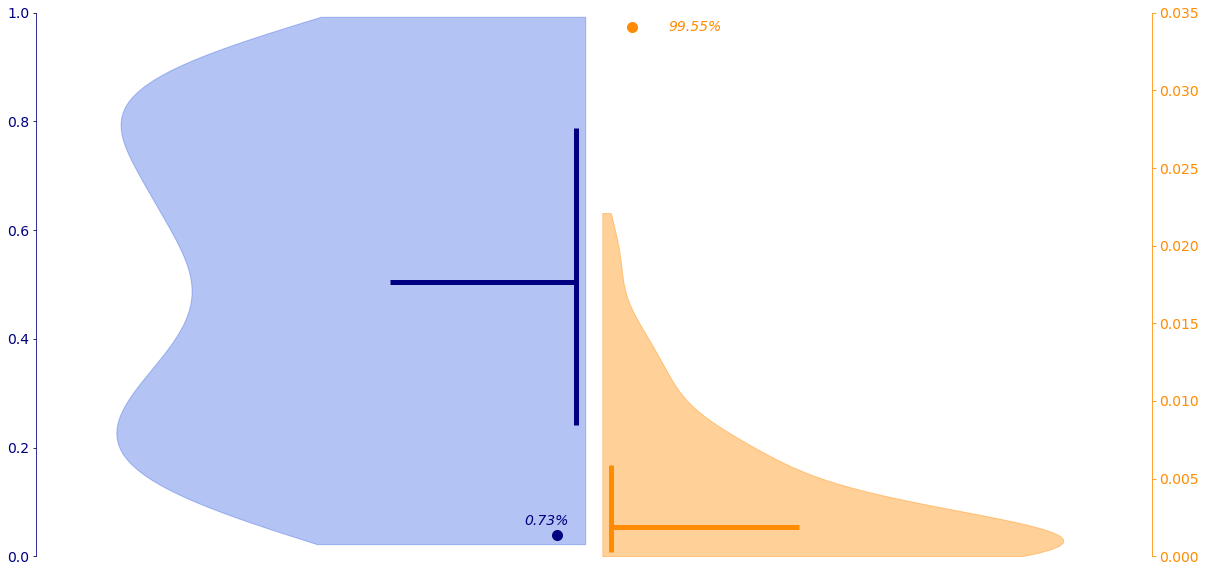

In [635]:
#----------------------------------------------------------------
# Everything is read, now do some calculations. The 30-min
# AzShear differences (diff), initial AzShear (init), and
# environmental variables are all the same shape. 
#
# First, look at the relationship with MLLCL.
#----------------------------------------------------------------
fig = plt.subplots(1,2,gridspec_kw = {'wspace':0, 'hspace':0})
plt.rcParams["figure.figsize"] = (7,10)

slopes = np.ones((num_iters))*np.nan
p  = np.ones((num_iters))*np.nan
r2 = np.ones((num_iters))*np.nan
for i in np.arange(0,num_iters):
    
    xi = mllcl_all[0,:,i]
    yi = diff[0,:,i]

    inds_keep = np.where((xi == xi) & (yi == yi))[0]

    x = xi[inds_keep]
    y = yi[inds_keep]

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    lbf = np.poly1d([slope,intercept])(np.unique(x))
    p_value = np.round(p_value,4)
    r_sq = np.round(r_value**2.,4)
    
    slopes[i] = slope
    p[i] = p_value
    r2[i] = r_sq
        
# --- p ---
ax = plt.subplot(1,2,1)
parts = plt.violinplot(p,positions=[0.993],showmedians=False,showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('royalblue')
    pc.set_edgecolor('royalblue')
    pc.set_alpha(0.4)
    
    # --- this is to only plot half of it ---
    # get the center
    m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
#     pc.set_color('r')
    
perc25 = np.percentile(p,25)
median = np.percentile(p,50)
perc75 = np.percentile(p,75)

buff = 0.1
plt.hlines(median,0.99-buff,0.99,colors='navy',lw=5)
plt.vlines(0.99,perc25,perc75,colors='navy',lw=5)
# plt.vlines(0.993,min(p),max(p),colors='navy',lw=2)

plt.scatter(0.98,0.0385,c='navy',s=100,zorder=3)
plt.text(0.986,0.065,'0.73%',fontsize=14,ha='right',va='center',c='navy',style='italic')

# --- axis customizations ---
plt.xlim(0.7,1)
plt.xticks([])

plt.ylim(0,1)
plt.yticks(fontsize=14,color='navy')

ax.spines[['right','bottom','top']].set_visible(False)
ax.spines['left'].set_color('navy')

print('p',0.0385,np.percentile(p,0.725),'(0.73%)')

# --- r2 ---
ax = plt.subplot(1,2,2)
parts = plt.violinplot(r2,positions=[1.002],showmedians=False,showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('darkorange')
    pc.set_edgecolor('darkorange')
    pc.set_alpha(0.4)
    
    # --- this is to only plot half of it ---
    # get the center
    m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
#     pc.set_color('r')

    
perc25 = np.percentile(r2,25)
median = np.percentile(r2,50)
perc75 = np.percentile(r2,75)

buff = 0.1
plt.hlines(median,1.01,1.01+buff,colors='darkorange',lw=5)
plt.vlines(1.009,perc25,perc75,colors='darkorange',lw=5)

plt.scatter(1.02,0.0341,c='darkorange',s=100,zorder=3)
plt.text(1.04,0.0341,'99.55%',fontsize=14,ha='left',va='center',c='darkorange',style='italic')

# --- axis customizations ---
plt.xlim(1,1.3)
plt.xticks([])

# plt.ylim(0-0.02*(max(r2)-min(r2)),max(r2)+0.02*(max(r2)-min(r2)))
plt.ylim(0,0.035)
ax.yaxis.tick_right()
plt.yticks(fontsize=14,color='darkorange')

ax.spines[['left','bottom','top']].set_visible(False)
ax.spines['right'].set_color('darkorange')
ax.tick_params(colors='darkorange')


print('r2',0.0341,np.percentile(r2,99.55),'(99.55%)')

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/SPC/Projects/' + \
#             '2023-MergersEnvironmentAnalysis/plots/NEW-SFCOA/MLLCL-p-r2',dpi=200)






    



p 0.2111 0.33321666 (35.26%)
r2 0.0126 0.0062013599999999995 (81.32%)


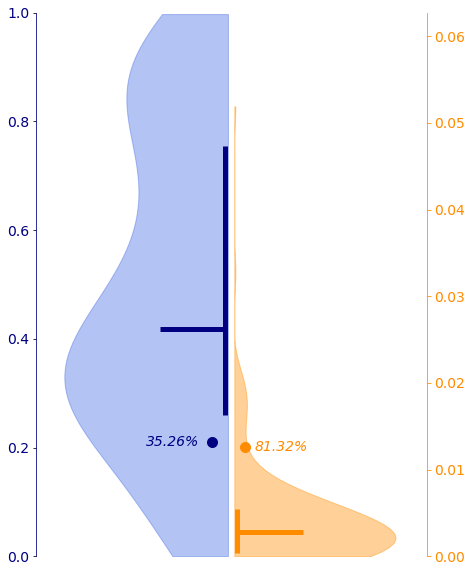

In [636]:
#----------------------------------------------------------------
# Now let's look at SHR01.
#----------------------------------------------------------------
plt.rcParams["figure.figsize"] = (7,10)

slopes = np.ones((num_iters))*np.nan
p  = np.ones((num_iters))*np.nan
r2 = np.ones((num_iters))*np.nan

for i in np.arange(0,num_iters):
    
    xi = shr01_all[0,:,i]
    yi = diff[0,:,i]

    inds_keep = np.where((xi == xi) & (yi == yi))[0]

    x = xi[inds_keep]
    y = yi[inds_keep]

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    lbf = np.poly1d([slope,intercept])(np.unique(x))
    p_value = np.round(p_value,4)
    r_sq = np.round(r_value**2.,4)
    
    slopes[i] = slope
    p[i] = p_value
    r2[i] = r_sq
    
fig = plt.subplots(1,2,gridspec_kw = {'wspace':0, 'hspace':0})

# --- p ---
ax = plt.subplot(1,2,1)
parts = plt.violinplot(p,positions=[0.993],showmedians=False,showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('royalblue')
    pc.set_edgecolor('royalblue')
    pc.set_alpha(0.4)
    
    # --- this is to only plot half of it ---
    # get the center
    m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
#     pc.set_color('r')
    
perc25 = np.percentile(p,25)
median = np.percentile(p,50)
perc75 = np.percentile(p,75)

buff = 0.1
plt.hlines(median,0.99-buff,0.99,colors='navy',lw=5)
plt.vlines(0.99,perc25,perc75,colors='navy',lw=5)
# plt.vlines(0.993,min(p),max(p),colors='navy',lw=2)

plt.scatter(0.97,0.2111,c='navy',s=100,zorder=3)
plt.text(0.95,0.2111,'35.26%',fontsize=14,ha='right',va='center',c='navy',style='italic')

# --- axis customizations ---
plt.xlim(0.7,1)
plt.xticks([])

plt.ylim(0,1)
plt.yticks(fontsize=14,color='navy')

ax.spines[['right','bottom','top']].set_visible(False)
ax.spines['left'].set_color('navy')

print('p',0.2111,np.percentile(p,35.26),'(35.26%)')

# --- r2 ---
ax = plt.subplot(1,2,2)
parts = plt.violinplot(r2,positions=[1.002],showmedians=False,showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('darkorange')
    pc.set_edgecolor('darkorange')
    pc.set_alpha(0.4)
    
    # --- this is to only plot half of it ---
    # get the center
    m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
#     pc.set_color('r')

    
perc25 = np.percentile(r2,25)
median = np.percentile(r2,50)
perc75 = np.percentile(r2,75)

buff = 0.1
plt.hlines(median,1.01,1.01+buff,colors='darkorange',lw=5)
plt.vlines(1.009,perc25,perc75,colors='darkorange',lw=5)

plt.scatter(1.02,0.0126,c='darkorange',s=100,zorder=3)
plt.text(1.035,0.0126,'81.32%',fontsize=14,ha='left',va='center',c='darkorange',style='italic')

# --- axis customizations ---
plt.xlim(1,1.3)
plt.xticks([])

plt.ylim(0,0.0627)
ax.yaxis.tick_right()
plt.yticks(fontsize=14,color='darkorange')

ax.spines[['left','bottom','top']].set_visible(False)
ax.spines['right'].set_color('darkorange')
ax.tick_params(colors='darkorange')

print('r2',0.0126,np.percentile(r2,81.32),'(81.32%)')

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/SPC/Projects/' + \
#             '2023-MergersEnvironmentAnalysis/plots/NEW-SFCOA/SHR01-p-r2',dpi=200)

# --- END OF THIS PART OF THE ANALYSIS FOR NOW ---






    



### 

Example: MLLCL array is (1, 342, 100) ... (num_mtimes,num_storms,num_iters)
Example: 0–3-km SRH array is (1, 342, 100) ... same as above
Example: AzShear diff array is (1, 342, 100) ... same as above
p and R2 0.0 0.2966
-------
MLLCL: 750-1000
SRH03: 300-400
-------
0.6867749419953596 0.31322505800464034
431
-------
0.0 1.0
42


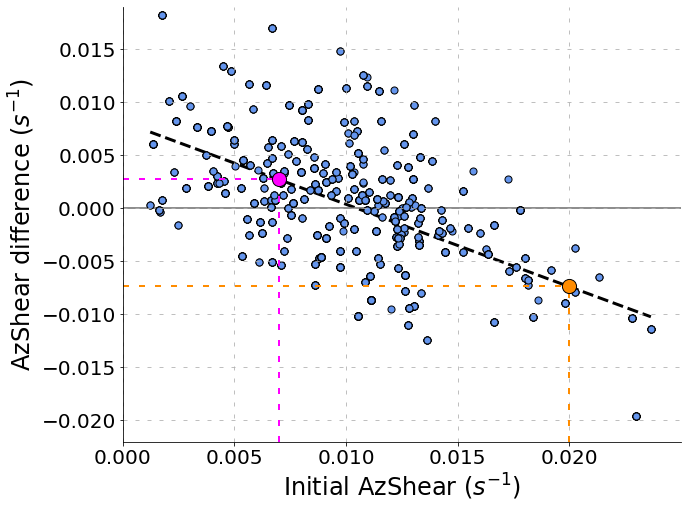

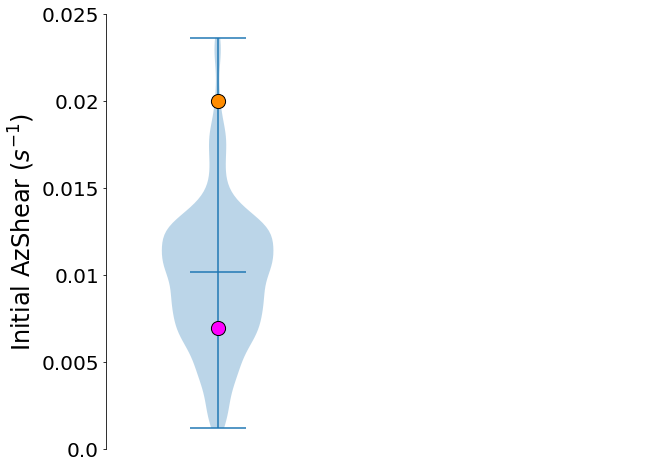

In [771]:
#----------------------------------------------------------------
# Now before moving onto the next part (looking at peak AzShear
# as a function of the environment), look at the percentage of
# mesos that strengthen/weaken during 30-min periods in 
# certain environments, given an initial strength.
#
# This is in response to Jannick's comment on the paper draft.
# This cell is not in the original code (pre-SFCOA).
#----------------------------------------------------------------
print('Example: MLLCL array is',np.shape(mllcl_all),'... (num_mtimes,num_storms,num_iters)')
print('Example: 0–3-km SRH array is',np.shape(shr03_all),'... same as above')
print('Example: AzShear diff array is',np.shape(diff),'... same as above')

this_init = []
this_diff = []

count = 0
for m in np.arange(0,num_mtimes):
    for i in np.arange(0,num_iters):
        this_mllcl = mllcl_all[m,:,i]
        this_srh = srh03_all[m,:,i]
        
        for s in np.arange(0,num_storms):
            if (this_mllcl[s] >= 750) & (this_mllcl[s] < 1000) & \
               (this_srh[s] >= 300) & (this_srh[s] < 400):
                this_init.append(init[m,s,i])
                this_diff.append(diff[m,s,i])
                
this_init = np.array(this_init)
this_diff = np.array(this_diff)

x = this_init
y = this_diff
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
lbf = np.poly1d([slope,intercept])(np.unique(x))
p_value = np.round(p_value,4)
r_sq = np.round(r_value**2.,4)
print('p and R2',p_value,r_sq)

init_val_low = 0.005
init_val_high = 0.009
these_inds = np.where((this_init >= init_val_low) & (this_init < init_val_high))[0]
these_diffs = this_diff[these_inds]
perc_high = len(np.where(these_diffs > 0)[0])/len(these_diffs)
perc_low = len(np.where(these_diffs < 0)[0])/len(these_diffs)

print('-------')
print('MLLCL: 750-1000')
print('SRH03: 300-400')
print('-------')
print(perc_high,perc_low)
print(len(these_diffs))
print('-------')

init_val_low = 0.018
init_val_high = 0.022
these_inds = np.where((this_init >= init_val_low) & (this_init < init_val_high))[0]
these_diffs = this_diff[these_inds]
perc_high = len(np.where(these_diffs > 0)[0])/len(these_diffs)
perc_low = len(np.where(these_diffs < 0)[0])/len(these_diffs)

print(perc_high,perc_low)
print(len(these_diffs))

ax = plt.subplot(1,1,1)
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(np.unique(x),lbf,lw=3,color='k',ls='--',zorder=0,label='p = ' + str(p_value))
plt.scatter(this_init,this_diff,c='cornflowerblue',ec='k',s=50)
ax.spines[['right','top']].set_visible(False)
plt.hlines(0,0,0.03,ls='-',colors='dimgray',zorder=0)
plt.xlim(0,0.025)
plt.ylim(-0.022,0.019)
plt.grid(ls=(0,(5,10)),zorder=0)

plt.scatter(0.02,-0.0073,s=200,fc='darkorange',ec='k',zorder=10)
plt.hlines(-0.0073,0,0.02,colors='darkorange',lw=2,ls=(0,(3,5)))
plt.vlines(0.02,-0.022,-0.0073,colors='darkorange',lw=2,ls=(0,(3,5)))

plt.scatter(0.007,0.0028,s=200,fc='magenta',ec='k',zorder=10)
plt.hlines(0.0028,0,0.007,colors='magenta',lw=2,ls=(0,(3,5)))
plt.vlines(0.007,-0.022,0.0028,colors='magenta',lw=2,ls=(0,(3,5)))

xticks  = np.arange(0,0.025,0.005)
yticks  = np.arange(-0.02,0.02,0.005)
ylabels = ['-0.02','','-0.01','','0','','0.01','']
plt.xticks(ticks=xticks,fontsize=20)
plt.yticks(ticks=yticks,fontsize=20)
plt.xlabel('Initial AzShear ($s^{-1}$)',fontsize=24)
plt.ylabel('AzShear difference ($s^{-1}$)',fontsize=24)

file = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/' + \
       '2023-MergersEnvironmentAnalysis/plots/NEW-SFCOA/final-schematic/' + \
       'scatter'

plt.savefig(file,dpi=250,bbox_inches='tight')

# --- plot the distribution for Fig. 10 ---
plt.figure()
ax = plt.subplot(1,1,1)
# plt.rcParams["figure.figsize"] = (8,10)
plt.violinplot(this_init,positions=[1],widths=0.05,showmedians=True)
ax.spines[['bottom','top','right']].set_visible(False)
plt.xticks(ticks=[])
yticks = np.arange(0,0.03,0.005)
plt.yticks(ticks=yticks,labels=yticks,fontsize=20)
plt.xlim(0.95,1.2)
plt.ylim(0,0.025)
plt.ylabel('Initial AzShear ($s^{-1}$)',fontsize=24)

plt.scatter(1,0.02,s=200,fc='darkorange',ec='k',zorder=10)
plt.scatter(1,0.007,s=200,fc='magenta',ec='k',zorder=10)

file = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/' + \
       '2023-MergersEnvironmentAnalysis/plots/NEW-SFCOA/final-schematic/' + \
       'violin'

plt.savefig(file,dpi=250,bbox_inches='tight')

# --- to plot scatter (not used) ---
# x_rand = []
# for x in np.arange(0,len(this_init)):
#     x_rand.append((np.random.normal())*0.005 + 1)
# x_rand = np.array(x_rand)
# plt.scatter(x_rand,this_init,alpha=0.1)


                


In [624]:
#----------------------------------------------------------------
# Now... let's look at if quasi-steady/upper-end mesocyclone
# intensity is a function of the background environment. First,
# loop through all AzShear for all storms and find a
# representative percentile of upper-end intensity. Then relate
# that to background environment characteristics.
#
# NOTE: Don't run this cell if you've already got the
# environmental info calculated! It takes a few minutes.
#
# NOTE: MDF added some stuff in this cell to be able to do
#       time-lagged analysis (e.g., correlate AzShear
#       percentiles at some mean time with environmental
#       variables either at the same time, X hrs before, or the
#       FIRST available time for each storm).
#----------------------------------------------------------------
percs = [25,50,75,90,95,98]
num_percs = len(percs)

# --- environmental arrays ---
mlcape_all = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcape_all = np.ones((num_storms,num_percs))*np.nan
mucape_all = np.ones((num_storms,num_percs))*np.nan

mlcin_all = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcin_all = np.ones((num_storms,num_percs))*np.nan
mucin_all = np.ones((num_storms,num_percs))*np.nan

mllcl_all = np.ones((num_storms,num_percs))*np.nan # m
sblcl_all = np.ones((num_storms,num_percs))*np.nan

shr01_all = np.ones((num_storms,num_percs))*np.nan # m/s
shr03_all = np.ones((num_storms,num_percs))*np.nan
shr06_all = np.ones((num_storms,num_percs))*np.nan

srh01_all = np.ones((num_storms,num_percs))*np.nan
srh03_all = np.ones((num_storms,num_percs))*np.nan

scp_all = np.ones((num_storms,num_percs))*np.nan # degrees

# --- AzShear arrays ---
azshear_percs = np.ones((num_storms,num_percs))*np.nan

totalcount = 0
goodcount = 0
badcount = 0
badIDcount = 0
badtimecount = 0

count_short = 0
count_long = 0

storms = []
badIDs = []
time_buff = 0 # this is where you select the time to correlate to
              # 0  = instantaneous
              # 1  = 1 hour before
              # 2  = 2 hours before, etc...
              # -1 = CI (first available sounding time for each storm)
                                
for s in np.arange(0,num_storms): #0,num_storms
    these_inds = np.where(fstormazshr[s,:] == fstormazshr[s,:])[0]
    
    if len(these_inds) < 10:
        count_short += 1
        continue
        
    count_long += 1
        
    these_azshears = fstormazshr[s,these_inds]
    these_times = fstormtime[s,these_inds]
    this_ID = stormID[s]

    for p in np.arange(0,num_percs): #0,num_percs 
        this_perc = percs[p]
        limit = np.percentile(these_azshears,this_perc)

        inds_high = np.where(these_azshears > limit)[0]
        these_azshears_high = these_azshears[inds_high]
        
        azshear_percs[s,p] = limit
        
        these_times_high = these_times[inds_high]
        
        # --- now get environmental data ---
        yyyymmdd_stri = convert(split(this_ID)[0:8])
                
        times = np.empty(len(these_times_high),dtype=object)
        yyyymmdd_str = ['']*len(these_times_high)
        hhmm = np.ones((len(these_times_high)))*np.nan
        hhmm_str = ['']*len(these_times_high)
        
        for t in np.arange(0,len(these_times_high)):
            hhmm[t] = int(these_times_high[t])
            
            # --- format hhmm(ss) ---
            if hhmm[t] < 10:
                hhmm_str[t] = '00000' + str(hhmm[t])
            if (hhmm[t] >= 10) & (hhmm[t] < 100):
                hhmm_str[t] = '0000' + str(hhmm[t])
            if (hhmm[t] >= 100) & (hhmm[t] < 1000):
                hhmm_str[t] = '000' + str(hhmm[t])
            if (hhmm[t] >= 1000) & (hhmm[t] < 10000):
                hhmm_str[t] = '00' + str(hhmm[t])
            if (hhmm[t] >= 10000) & (hhmm[t] < 100000):
                hhmm_str[t] = '0' + str(hhmm[t])
            if (hhmm[t] >= 100000):
                hhmm_str[t] = str(hhmm[t])

            # --- limit to just hhmm ---
            hhmm_str[t] = convert(split(hhmm_str[t])[0:4])
            
            # --- change date if necessary ---
            if hhmm[t] >= 110000:
                yyyymmdd_str[t] = yyyymmdd_stri
            else:
                yyyymmdd_str[t] = datetime.strftime(datetime.strptime(yyyymmdd_stri,'%Y%m%d') + \
                                                 timedelta(hours=24),'%Y%m%d')

            # --- create full initial (pre-rounded) datetime object ---
            times[t] = datetime.strptime(yyyymmdd_str[t] + hhmm_str[t],'%Y%m%d%H%M')
            
        # --- now average all times to get the final time (pre-rounded) ---
        diffs = np.ones((len(these_times_high)))*np.nan
        for t in np.arange(0,len(these_times_high)):
            diffs[t] = (times[t] - datetime(1970,1,1)).total_seconds()
            
        mean_diff = np.mean(diffs)
        
        if mean_diff != mean_diff:
            continue
        
        mean_time = datetime.fromtimestamp(mean_diff,timezone.utc).strftime('%Y-%m-%d %H:%M')
        mean_time_dt = datetime.strptime(mean_time,'%Y-%m-%d %H:%M')
                    
        # --- now round and get the final hourly datetime object ---
        # NOTE: the "- timedelta(hours=time_buff)" was added in Dec
        #       2023 for Casey's revisions. time_buff = 0 gives the
        #       same regressions as the original submission.
        if (time_buff == 10) or (time_buff == 20):
            time_buff = 0
        
        if mean_time_dt.minute < 30:
            final_time_dt = mean_time_dt.replace(minute=0) - timedelta(hours=time_buff)
        if mean_time_dt.minute >= 30:
            final_time_dt = mean_time_dt.replace(minute=0) + timedelta(hours=1) - timedelta(hours=time_buff)
            
        if final_time_dt.year < 2005:
            continue
                    
        storms.append(this_ID)
        #----------------------------------------------------------------
        # Now extract environmntal info by pairing the storm ID and
        # hourly analysis time with the SFCOA arrays.
        #----------------------------------------------------------------
        print_stuff = 'N'
        this_time_str = datetime.strftime(final_time_dt,'%Y%m%d%H')
        if print_stuff == 'Y': print('working with',this_ID,'at',this_time_str)
            
        match_ID = np.where(stormIDi[:,0] == this_ID)[0]
        if len(match_ID) == 0:
            badcount += 1
            badIDcount += 1
            if print_stuff == 'Y': print('Storm ID not found in SFCOA')
            badIDs.append(this_ID)
            continue

        time_ID = np.where(timei[match_ID,:][0] == this_time_str)[0]
                
        if time_buff == -1:
            time_ID = [0]
        
        if len(time_ID) == 0:        
            badcount += 1
            badtimecount += 1
            if print_stuff == 'Y': print('This hour for this storm not found in SFCOA')
            if print_stuff == 'Y': print('Available times:',timei[match_ID,:][0])
            continue

        if print_stuff == 'Y': print('Desired time:',this_ID,this_time_str)
        if print_stuff == 'Y': print('SFCOA match:',stormIDi[match_ID,time_ID],timei[match_ID,time_ID])
        if print_stuff == 'Y': print('-------')
            
        mlcape_all[s,p] = mlcapei[match_ID,time_ID]
        sbcape_all[s,p] = sbcapei[match_ID,time_ID]
        mucape_all[s,p] = mucapei[match_ID,time_ID]
        mlcin_all[s,p] = mlcini[match_ID,time_ID]
        sbcin_all[s,p] = sbcini[match_ID,time_ID]
        mucin_all[s,p] = mucini[match_ID,time_ID]
        mllcl_all[s,p] = mllcli[match_ID,time_ID]
        sblcl_all[s,p] = sblcli[match_ID,time_ID]

        shr01_all[s,p] = shr01i[match_ID,time_ID]
        shr03_all[s,p] = shr03i[match_ID,time_ID]
        shr06_all[s,p] = shr06i[match_ID,time_ID]

        srh01_all[s,p] = srh01i[match_ID,time_ID]
        srh03_all[s,p] = srh03i[match_ID,time_ID]
        scp_all[s,p] = scpi[match_ID,time_ID]    
                
num_unique_storms = len(np.unique(np.array(storms)))
num_unique_badIDs = len(np.unique(np.array(badIDs)))
print('---------------------')
print('Across all',num_storms,'storms (2003–2011),',count_long,'had at least 10 volumes')
print('There are',num_unique_storms,'storms that had at least 10 volumes from 2005–2011')
print('Of these',num_unique_storms,'storms, SFCOA variables failed for',num_unique_badIDs)



---------------------
Across all 342 storms (2003–2011), 311 had at least 10 volumes
There are 240 storms that had at least 10 volumes from 2005–2011
Of these 240 storms, SFCOA variables failed for 2


In [423]:
#----------------------------------------------------------------
# Now... let's look at if quasi-steady/upper-end mesocyclone
# intensity is a function of the background environment. First,
# loop through all AzShear for all storms and find a
# representative percentile of upper-end intensity. Then relate
# that to background environment characteristics.
#
# NOTE: Don't run this cell if you've already got the
# environmental info calculated! It takes a few minutes.
#
# NOTE: MDF added some stuff in this cell to be able to do
#       time-lagged analysis (e.g., correlate AzShear
#       percentiles at some mean time with environmental
#       variables either at the same time, X hrs before, or the
#       FIRST available time for each storm).
#
# NOTE: Same cell as above except copied down here to look at
#       regressions between AzShear VARIABILITY and environmental
#       VARIABILITY in time.
#
#       ONLY RUN EITHER THIS CELL OR THE ONE ABOVE.
#
# THIS CELL MAKES SOME OF THE NEW PLOTS, LIKE CASEY'S FIG. 15.
# IN TANDEM WITH THE CELL BELOW.
#----------------------------------------------------------------
percs = [25,50,75,90,95,98]
num_percs = len(percs)

# --- environmental arrays (all is simultaneous regression, alltl below is 1-h time lagged) ---
mlcape_all = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcape_all = np.ones((num_storms,num_percs))*np.nan
mucape_all = np.ones((num_storms,num_percs))*np.nan

mlcin_all = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcin_all = np.ones((num_storms,num_percs))*np.nan
mucin_all = np.ones((num_storms,num_percs))*np.nan

mllcl_all = np.ones((num_storms,num_percs))*np.nan # m
sblcl_all = np.ones((num_storms,num_percs))*np.nan

shr01_all = np.ones((num_storms,num_percs))*np.nan # m/s
shr03_all = np.ones((num_storms,num_percs))*np.nan
shr06_all = np.ones((num_storms,num_percs))*np.nan

srh01_all = np.ones((num_storms,num_percs))*np.nan
srh03_all = np.ones((num_storms,num_percs))*np.nan

scp_all = np.ones((num_storms,num_percs))*np.nan # degrees

# --- percentage change arrays ---
mlcape_all_perc = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcape_all_perc = np.ones((num_storms,num_percs))*np.nan
mucape_all_perc = np.ones((num_storms,num_percs))*np.nan

mlcin_all_perc = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcin_all_perc = np.ones((num_storms,num_percs))*np.nan
mucin_all_perc = np.ones((num_storms,num_percs))*np.nan

mllcl_all_perc = np.ones((num_storms,num_percs))*np.nan # m
sblcl_all_perc = np.ones((num_storms,num_percs))*np.nan

shr01_all_perc = np.ones((num_storms,num_percs))*np.nan # m/s
shr03_all_perc = np.ones((num_storms,num_percs))*np.nan
shr06_all_perc = np.ones((num_storms,num_percs))*np.nan

srh01_all_perc = np.ones((num_storms,num_percs))*np.nan
srh03_all_perc = np.ones((num_storms,num_percs))*np.nan

scp_all_perc = np.ones((num_storms,num_percs))*np.nan # degrees


# --- AzShear arrays ---
azshear_percs = np.ones((num_storms,num_percs))*np.nan
azshear_percs_perc = np.ones((num_storms,num_percs))*np.nan # percentage change


totalcount = 0
goodcount = 0
badcount = 0
badIDcount = 0
badtimecount = 0

count_short = 0
count_long = 0

storms = []
storms_var = []
badIDs = []
time_buff = 1 # this is where you select the time to correlate to (keep it as 1)
              # 1  = environmental variability (difference between instantaneous and 1 h before)
              # 2  = environmental variability (difference between instantaneous and 2 h before)
              # this assumes a difference with the instantaneous environmental fields
                
count_use = 0

# --- calculate instantaneous regressions ("all" variables) ---
for s in np.arange(0,num_storms): #0,num_storms
    these_inds = np.where(fstormazshr[s,:] == fstormazshr[s,:])[0]
    
    if len(these_inds) < 10:
        count_short += 1
        continue
        
    count_long += 1
        
    these_azshears = fstormazshr[s,these_inds]
    these_times = fstormtime[s,these_inds]
    this_ID = stormID[s]

    for p in np.arange(4,5): #0,num_percs 
        flag = 'no'
        this_perc = percs[p]
        limit = np.percentile(these_azshears,this_perc)

        inds_high = np.where(these_azshears > limit)[0]
        these_azshears_high = these_azshears[inds_high]
        
        # --- isolate one period per storm (somewhat rudimentary) ---
        if len(inds_high) >= 2: # at least two points ...
            if np.ptp(inds_high) <= 6: # ... within 30 min of each other ...
                if inds_high[0] >= 12: # ... beginning at least 1 h after initiation (12)
                                       # ... beginning at least 2 h after initiation (24)
                    count_use += 1
                    flag = 'yes'                    
                    
        # --- compute the hourly AzShear difference ---
        if flag == 'yes':
            azshear_percs[s,p] = these_azshears[int(np.mean(inds_high))] - \
                                 these_azshears[int(np.mean(inds_high))-12] # this is actually the AzShear
                                                                            # change in the last hour
            
            # --- and percentage difference ---
            azshear_percs_perc[s,p] = azshear_percs[s,p] / these_azshears[int(np.mean(inds_high))-12]
        
        these_times_high = these_times[inds_high]
        
        # --- now get environmental data ---
        yyyymmdd_stri = convert(split(this_ID)[0:8])
                
        times = np.empty(len(these_times_high),dtype=object)
        yyyymmdd_str = ['']*len(these_times_high)
        hhmm = np.ones((len(these_times_high)))*np.nan
        hhmm_str = ['']*len(these_times_high)
        
        for t in np.arange(0,len(these_times_high)):
            hhmm[t] = int(these_times_high[t])
            
            # --- format hhmm(ss) ---
            if hhmm[t] < 10:
                hhmm_str[t] = '00000' + str(hhmm[t])
            if (hhmm[t] >= 10) & (hhmm[t] < 100):
                hhmm_str[t] = '0000' + str(hhmm[t])
            if (hhmm[t] >= 100) & (hhmm[t] < 1000):
                hhmm_str[t] = '000' + str(hhmm[t])
            if (hhmm[t] >= 1000) & (hhmm[t] < 10000):
                hhmm_str[t] = '00' + str(hhmm[t])
            if (hhmm[t] >= 10000) & (hhmm[t] < 100000):
                hhmm_str[t] = '0' + str(hhmm[t])
            if (hhmm[t] >= 100000):
                hhmm_str[t] = str(hhmm[t])

            # --- limit to just hhmm ---
            hhmm_str[t] = convert(split(hhmm_str[t])[0:4])
            
            # --- change date if necessary ---
            if hhmm[t] >= 110000:
                yyyymmdd_str[t] = yyyymmdd_stri
            else:
                yyyymmdd_str[t] = datetime.strftime(datetime.strptime(yyyymmdd_stri,'%Y%m%d') + \
                                                 timedelta(hours=24),'%Y%m%d')

            # --- create full initial (pre-rounded) datetime object ---
            times[t] = datetime.strptime(yyyymmdd_str[t] + hhmm_str[t],'%Y%m%d%H%M')
            
        # --- now average all times to get the final time (pre-rounded) ---
        diffs = np.ones((len(these_times_high)))*np.nan
        for t in np.arange(0,len(these_times_high)):
            diffs[t] = (times[t] - datetime(1970,1,1)).total_seconds()
            
        mean_diff = np.mean(diffs)
        
        if mean_diff != mean_diff:
            continue
        
        mean_time = datetime.fromtimestamp(mean_diff,timezone.utc).strftime('%Y-%m-%d %H:%M')
        mean_time_dt = datetime.strptime(mean_time,'%Y-%m-%d %H:%M')
                    
        # --- now round and get the final hourly datetime object ---
        # NOTE: the "- timedelta(hours=time_buff)" was added in Dec
        #       2023 for Casey's revisions. time_buff = 0 gives the
        #       same regressions as the original submission.
        if (time_buff == 10) or (time_buff == 20):
            time_buff = 0
        
        if mean_time_dt.minute < 30:
            final_time_dt = mean_time_dt.replace(minute=0)# - timedelta(hours=1) # INCLUDE THIS SUBTRACTION
                                                                                # TO COMPARE 1-hr AzShear changes
                                                                                # with 2–1-hr env changes
        if mean_time_dt.minute >= 30:
            final_time_dt = mean_time_dt.replace(minute=0) + timedelta(hours=1)# - timedelta(hours=1)
            
        if final_time_dt.year < 2005:
            continue
                    
        storms.append(this_ID)
        #----------------------------------------------------------------
        # Now extract environmntal info by pairing the storm ID and
        # hourly analysis time with the SFCOA arrays.
        #----------------------------------------------------------------
        print_stuff = 'N'
        this_time_str = datetime.strftime(final_time_dt,'%Y%m%d%H')
        if print_stuff == 'Y': print('working with',this_ID,'at',this_time_str)
            
        match_ID = np.where(stormIDi[:,0] == this_ID)[0]
        if len(match_ID) == 0:
            badcount += 1
            badIDcount += 1
            if print_stuff == 'Y': print('Storm ID not found in SFCOA')
            badIDs.append(this_ID)
            continue

        time_ID = np.where(timei[match_ID,:][0] == this_time_str)[0]
                                        
        if len(time_ID) == 0:        
            badcount += 1
            badtimecount += 1
            if print_stuff == 'Y': print('This hour for this storm not found in SFCOA')
            if print_stuff == 'Y': print('Available times:',timei[match_ID,:][0])
            continue

        if print_stuff == 'Y': print('Desired time:',this_ID,this_time_str)
        if print_stuff == 'Y': print('SFCOA match:',stormIDi[match_ID,time_ID],timei[match_ID,time_ID])
        if print_stuff == 'Y': print('-------')
            
        mlcape_all[s,p] = mlcapei[match_ID,time_ID] - mlcapei[match_ID,time_ID-time_buff]
        sbcape_all[s,p] = sbcapei[match_ID,time_ID] - sbcapei[match_ID,time_ID-time_buff]
        mucape_all[s,p] = mucapei[match_ID,time_ID] - mucapei[match_ID,time_ID-time_buff]
        mlcin_all[s,p] = mlcini[match_ID,time_ID] - mlcini[match_ID,time_ID-time_buff]
        sbcin_all[s,p] = sbcini[match_ID,time_ID] - sbcini[match_ID,time_ID-time_buff]
        mucin_all[s,p] = mucini[match_ID,time_ID] - mucini[match_ID,time_ID-time_buff]
        mllcl_all[s,p] = mllcli[match_ID,time_ID] - mllcli[match_ID,time_ID-time_buff]
        sblcl_all[s,p] = sblcli[match_ID,time_ID] - sblcli[match_ID,time_ID-time_buff]

        shr01_all[s,p] = shr01i[match_ID,time_ID] - shr01i[match_ID,time_ID-time_buff]
        shr03_all[s,p] = shr03i[match_ID,time_ID] - shr03i[match_ID,time_ID-time_buff]
        shr06_all[s,p] = shr06i[match_ID,time_ID] - shr06i[match_ID,time_ID-time_buff]

        srh01_all[s,p] = srh01i[match_ID,time_ID] - srh01i[match_ID,time_ID-time_buff]
        srh03_all[s,p] = srh03i[match_ID,time_ID] - srh03i[match_ID,time_ID-time_buff]
        scp_all[s,p] = scpi[match_ID,time_ID] - scpi[match_ID,time_ID-time_buff]
        
        # --- now percentage changes ---
        mlcape_all_perc[s,p] = mlcape_all[s,p] / mlcapei[match_ID,time_ID-time_buff]
        sbcape_all_perc[s,p] = sbcape_all[s,p] / sbcapei[match_ID,time_ID-time_buff]
        mucape_all_perc[s,p] = mucape_all[s,p] / mucapei[match_ID,time_ID-time_buff]
        mlcin_all_perc[s,p] = mlcin_all[s,p] / mlcini[match_ID,time_ID-time_buff]
        sbcin_all_perc[s,p] = sbcin_all[s,p] / sbcini[match_ID,time_ID-time_buff]
        mucin_all_perc[s,p] = mucin_all[s,p] / mucini[match_ID,time_ID-time_buff]
        mllcl_all_perc[s,p] = mllcl_all[s,p] / mllcli[match_ID,time_ID-time_buff]
        sblcl_all_perc[s,p] = sblcl_all[s,p] / sblcli[match_ID,time_ID-time_buff]

        shr01_all_perc[s,p] = shr01_all[s,p] / shr01i[match_ID,time_ID-time_buff]
        shr03_all_perc[s,p] = shr03_all[s,p] / shr03i[match_ID,time_ID-time_buff]
        shr06_all_perc[s,p] = shr06_all[s,p] / shr06i[match_ID,time_ID-time_buff]

        srh01_all_perc[s,p] = srh01_all[s,p] / srh01i[match_ID,time_ID-time_buff]
        srh03_all_perc[s,p] = srh03_all[s,p] / srh03i[match_ID,time_ID-time_buff]
        scp_all_perc[s,p] = scp_all[s,p] / scpi[match_ID,time_ID-time_buff]

                
num_unique_storms = len(np.unique(np.array(storms)))
num_unique_storms_var = len(np.unique(np.array(storms)))
num_unique_badIDs = len(np.unique(np.array(badIDs)))
print('---------------------')
print('Across all',num_storms,'storms (2003–2011),',count_long,'had at least 10 volumes')
print('There are',num_unique_storms,'storms that had at least 10 volumes from 2005–2011')
print('Of these',num_unique_storms,'storms, SFCOA variables failed for',num_unique_badIDs)
print('Of these',num_unique_storms,'storms,',count_use,'are suitable for 1-h environmental trend calculations')



##################################
# --- 1-h time lagged ones now ---
##################################
mlcape_alltl = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcape_alltl = np.ones((num_storms,num_percs))*np.nan
mucape_alltl = np.ones((num_storms,num_percs))*np.nan

mlcin_alltl = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcin_alltl = np.ones((num_storms,num_percs))*np.nan
mucin_alltl = np.ones((num_storms,num_percs))*np.nan

mllcl_alltl = np.ones((num_storms,num_percs))*np.nan # m
sblcl_alltl = np.ones((num_storms,num_percs))*np.nan

shr01_alltl = np.ones((num_storms,num_percs))*np.nan # m/s
shr03_alltl = np.ones((num_storms,num_percs))*np.nan
shr06_alltl = np.ones((num_storms,num_percs))*np.nan

srh01_alltl = np.ones((num_storms,num_percs))*np.nan
srh03_alltl = np.ones((num_storms,num_percs))*np.nan

scp_alltl = np.ones((num_storms,num_percs))*np.nan # degrees

# --- and percentage variation ---
mlcape_alltl_perc = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcape_alltl_perc = np.ones((num_storms,num_percs))*np.nan
mucape_alltl_perc = np.ones((num_storms,num_percs))*np.nan

mlcin_alltl_perc = np.ones((num_storms,num_percs))*np.nan # J/kg
sbcin_alltl_perc = np.ones((num_storms,num_percs))*np.nan
mucin_alltl_perc = np.ones((num_storms,num_percs))*np.nan

mllcl_alltl_perc = np.ones((num_storms,num_percs))*np.nan # m
sblcl_alltl_perc = np.ones((num_storms,num_percs))*np.nan

shr01_alltl_perc = np.ones((num_storms,num_percs))*np.nan # m/s
shr03_alltl_perc = np.ones((num_storms,num_percs))*np.nan
shr06_alltl_perc = np.ones((num_storms,num_percs))*np.nan

srh01_alltl_perc = np.ones((num_storms,num_percs))*np.nan
srh03_alltl_perc = np.ones((num_storms,num_percs))*np.nan

scp_alltl_perc = np.ones((num_storms,num_percs))*np.nan # degrees


# --- reset AzShear arrays and other flags ---
azshear_percstl = np.ones((num_storms,num_percs))*np.nan
azshear_percstl_perc = np.ones((num_storms,num_percs))*np.nan # 1-h time lag

totalcount = 0
goodcount = 0
badcount = 0
badIDcount = 0
badtimecount = 0

count_short = 0
count_long = 0

storms = []
storms_var = []
badIDs = []
time_buff = 1 # this is where you select the time to correlate to (keep it as 1)
              # 1  = environmental variability (difference between instantaneous and 1 h before)
              # 2  = environmental variability (difference between instantaneous and 2 h before)
              # this assumes a difference with the instantaneous environmental fields
                
count_use = 0

# --- now calculate 1-h time lagged regressions ("alltl" variables) ---
for s in np.arange(0,num_storms): #0,num_storms
    these_inds = np.where(fstormazshr[s,:] == fstormazshr[s,:])[0]
    
    if len(these_inds) < 10:
        count_short += 1
        continue
        
    count_long += 1
        
    these_azshears = fstormazshr[s,these_inds]
    these_times = fstormtime[s,these_inds]
    this_ID = stormID[s]

    for p in np.arange(4,5): #0,num_percs 
        flag = 'no'
        this_perc = percs[p]
        limit = np.percentile(these_azshears,this_perc)

        inds_high = np.where(these_azshears > limit)[0]
        these_azshears_high = these_azshears[inds_high]
        
        # --- isolate one period per storm (somewhat rudimentary) ---
        if len(inds_high) >= 2: # at least two points ...
            if np.ptp(inds_high) <= 6: # ... within 30 min of each other ...
                if inds_high[0] >= 24: # ... beginning at least 1 h after initiation (12)
                                       # ... beginning at least 2 h after initiation (24)
                    count_use += 1
                    flag = 'yes'                    
                    
        # --- compute the hourly AzShear difference ---
        if flag == 'yes':
            azshear_percstl[s,p] = these_azshears[int(np.mean(inds_high))] - \
                                 these_azshears[int(np.mean(inds_high))-12] # this is actually the AzShear change
                                                                            # in the last hour
                
            # --- and percentage difference ---
            azshear_percstl_perc[s,p] = azshear_percstl[s,p] / these_azshears[int(np.mean(inds_high))-12]

        
        these_times_high = these_times[inds_high]
        
        # --- now get environmental data ---
        yyyymmdd_stri = convert(split(this_ID)[0:8])
                
        times = np.empty(len(these_times_high),dtype=object)
        yyyymmdd_str = ['']*len(these_times_high)
        hhmm = np.ones((len(these_times_high)))*np.nan
        hhmm_str = ['']*len(these_times_high)
        
        for t in np.arange(0,len(these_times_high)):
            hhmm[t] = int(these_times_high[t])
            
            # --- format hhmm(ss) ---
            if hhmm[t] < 10:
                hhmm_str[t] = '00000' + str(hhmm[t])
            if (hhmm[t] >= 10) & (hhmm[t] < 100):
                hhmm_str[t] = '0000' + str(hhmm[t])
            if (hhmm[t] >= 100) & (hhmm[t] < 1000):
                hhmm_str[t] = '000' + str(hhmm[t])
            if (hhmm[t] >= 1000) & (hhmm[t] < 10000):
                hhmm_str[t] = '00' + str(hhmm[t])
            if (hhmm[t] >= 10000) & (hhmm[t] < 100000):
                hhmm_str[t] = '0' + str(hhmm[t])
            if (hhmm[t] >= 100000):
                hhmm_str[t] = str(hhmm[t])

            # --- limit to just hhmm ---
            hhmm_str[t] = convert(split(hhmm_str[t])[0:4])
            
            # --- change date if necessary ---
            if hhmm[t] >= 110000:
                yyyymmdd_str[t] = yyyymmdd_stri
            else:
                yyyymmdd_str[t] = datetime.strftime(datetime.strptime(yyyymmdd_stri,'%Y%m%d') + \
                                                 timedelta(hours=24),'%Y%m%d')

            # --- create full initial (pre-rounded) datetime object ---
            times[t] = datetime.strptime(yyyymmdd_str[t] + hhmm_str[t],'%Y%m%d%H%M')
            
        # --- now average all times to get the final time (pre-rounded) ---
        diffs = np.ones((len(these_times_high)))*np.nan
        for t in np.arange(0,len(these_times_high)):
            diffs[t] = (times[t] - datetime(1970,1,1)).total_seconds()
            
        mean_diff = np.mean(diffs)
        
        if mean_diff != mean_diff:
            continue
        
        mean_time = datetime.fromtimestamp(mean_diff,timezone.utc).strftime('%Y-%m-%d %H:%M')
        mean_time_dt = datetime.strptime(mean_time,'%Y-%m-%d %H:%M')
                    
        # --- now round and get the final hourly datetime object ---
        # NOTE: the "- timedelta(hours=time_buff)" was added in Dec
        #       2023 for Casey's revisions. time_buff = 0 gives the
        #       same regressions as the original submission.
        if (time_buff == 10) or (time_buff == 20):
            time_buff = 0
        
        if mean_time_dt.minute < 30:
            final_time_dt = mean_time_dt.replace(minute=0) - timedelta(hours=1) # INCLUDE THIS SUBTRACTION
                                                                                # TO COMPARE 1-hr AzShear changes
                                                                                # with 2–1-hr env changes
        if mean_time_dt.minute >= 30:
            final_time_dt = mean_time_dt.replace(minute=0) + timedelta(hours=1) - timedelta(hours=1)
            
        if final_time_dt.year < 2005:
            continue
                    
        storms.append(this_ID)
        #----------------------------------------------------------------
        # Now extract environmntal info by pairing the storm ID and
        # hourly analysis time with the SFCOA arrays.
        #----------------------------------------------------------------
        print_stuff = 'N'
        this_time_str = datetime.strftime(final_time_dt,'%Y%m%d%H')
        if print_stuff == 'Y': print('working with',this_ID,'at',this_time_str)
            
        match_ID = np.where(stormIDi[:,0] == this_ID)[0]
        if len(match_ID) == 0:
            badcount += 1
            badIDcount += 1
            if print_stuff == 'Y': print('Storm ID not found in SFCOA')
            badIDs.append(this_ID)
            continue

        time_ID = np.where(timei[match_ID,:][0] == this_time_str)[0]
                                        
        if len(time_ID) == 0:        
            badcount += 1
            badtimecount += 1
            if print_stuff == 'Y': print('This hour for this storm not found in SFCOA')
            if print_stuff == 'Y': print('Available times:',timei[match_ID,:][0])
            continue

        if print_stuff == 'Y': print('Desired time:',this_ID,this_time_str)
        if print_stuff == 'Y': print('SFCOA match:',stormIDi[match_ID,time_ID],timei[match_ID,time_ID])
        if print_stuff == 'Y': print('-------')
            
        mlcape_alltl[s,p] = mlcapei[match_ID,time_ID] - mlcapei[match_ID,time_ID-time_buff]
        sbcape_alltl[s,p] = sbcapei[match_ID,time_ID] - sbcapei[match_ID,time_ID-time_buff]
        mucape_alltl[s,p] = mucapei[match_ID,time_ID] - mucapei[match_ID,time_ID-time_buff]
        mlcin_alltl[s,p] = mlcini[match_ID,time_ID] - mlcini[match_ID,time_ID-time_buff]
        sbcin_alltl[s,p] = sbcini[match_ID,time_ID] - sbcini[match_ID,time_ID-time_buff]
        mucin_alltl[s,p] = mucini[match_ID,time_ID] - mucini[match_ID,time_ID-time_buff]
        mllcl_alltl[s,p] = mllcli[match_ID,time_ID] - mllcli[match_ID,time_ID-time_buff]
        sblcl_alltl[s,p] = sblcli[match_ID,time_ID] - sblcli[match_ID,time_ID-time_buff]

        shr01_alltl[s,p] = shr01i[match_ID,time_ID] - shr01i[match_ID,time_ID-time_buff]
        shr03_alltl[s,p] = shr03i[match_ID,time_ID] - shr03i[match_ID,time_ID-time_buff]
        shr06_alltl[s,p] = shr06i[match_ID,time_ID] - shr06i[match_ID,time_ID-time_buff]

        srh01_alltl[s,p] = srh01i[match_ID,time_ID] - srh01i[match_ID,time_ID-time_buff]
        srh03_alltl[s,p] = srh03i[match_ID,time_ID] - srh03i[match_ID,time_ID-time_buff]
        scp_alltl[s,p] = scpi[match_ID,time_ID] - scpi[match_ID,time_ID-time_buff]
        
        # --- now percentage changes ---
        mlcape_alltl_perc[s,p] = mlcape_alltl[s,p] / mlcapei[match_ID,time_ID-time_buff]
        sbcape_alltl_perc[s,p] = sbcape_alltl[s,p] / sbcapei[match_ID,time_ID-time_buff]
        mucape_alltl_perc[s,p] = mucape_alltl[s,p] / mucapei[match_ID,time_ID-time_buff]
        mlcin_alltl_perc[s,p] = mlcin_alltl[s,p] / mlcini[match_ID,time_ID-time_buff]
        sbcin_alltl_perc[s,p] = sbcin_alltl[s,p] / sbcini[match_ID,time_ID-time_buff]
        mucin_alltl_perc[s,p] = mucin_alltl[s,p] / mucini[match_ID,time_ID-time_buff]
        mllcl_alltl_perc[s,p] = mllcl_alltl[s,p] / mllcli[match_ID,time_ID-time_buff]
        sblcl_alltl_perc[s,p] = sblcl_alltl[s,p] / sblcli[match_ID,time_ID-time_buff]

        shr01_alltl_perc[s,p] = shr01_alltl[s,p] / shr01i[match_ID,time_ID-time_buff]
        shr03_alltl_perc[s,p] = shr03_alltl[s,p] / shr03i[match_ID,time_ID-time_buff]
        shr06_alltl_perc[s,p] = shr06_alltl[s,p] / shr06i[match_ID,time_ID-time_buff]

        srh01_alltl_perc[s,p] = srh01_alltl[s,p] / srh01i[match_ID,time_ID-time_buff]
        srh03_alltl_perc[s,p] = srh03_alltl[s,p] / srh03i[match_ID,time_ID-time_buff]
        scp_alltl_perc[s,p] = scp_alltl[s,p] / scpi[match_ID,time_ID-time_buff]
                
num_unique_storms = len(np.unique(np.array(storms)))
num_unique_storms_var = len(np.unique(np.array(storms)))
num_unique_badIDs = len(np.unique(np.array(badIDs)))
print('---------------------')
print('Across all',num_storms,'storms (2003–2011),',count_long,'had at least 10 volumes')
print('There are',num_unique_storms,'storms that had at least 10 volumes from 2005–2011')
print('Of these',num_unique_storms,'storms, SFCOA variables failed for',num_unique_badIDs)
print('Of these',num_unique_storms,'storms,',count_use,'are suitable for 1-h environmental trend calculations')



---------------------
Across all 342 storms (2003–2011), 311 had at least 10 volumes
There are 230 storms that had at least 10 volumes from 2005–2011
Of these 230 storms, SFCOA variables failed for 2
Of these 230 storms, 92 are suitable for 1-h environmental trend calculations
---------------------
Across all 342 storms (2003–2011), 311 had at least 10 volumes
There are 230 storms that had at least 10 volumes from 2005–2011
Of these 230 storms, SFCOA variables failed for 2
Of these 230 storms, 19 are suitable for 1-h environmental trend calculations


In [424]:
# print(azshear_percs[:,4])
# plt.hist(azshear_percs[:,4])
# plt.figure()
# plt.hist(srh03_all[:,4])
# print(np.nanmean(srh03_all[:,4]))

MLLCL
95 PERCENTILE
n = 67
Max/min MLLCL : 453.0  | -935.25
Max/min AzShear difference : 0.039729999999999994  |  -0.0018899999999999958
n = 15
Max/min MLLCL : 342.75  | -646.25
Max/min AzShear difference : 0.028239999999999998  |  -0.0018899999999999958
MAGNITUDE CHANGE STATS:
p: 0.2868
R2: 0.0252
slope: 3.998157380523128e-06


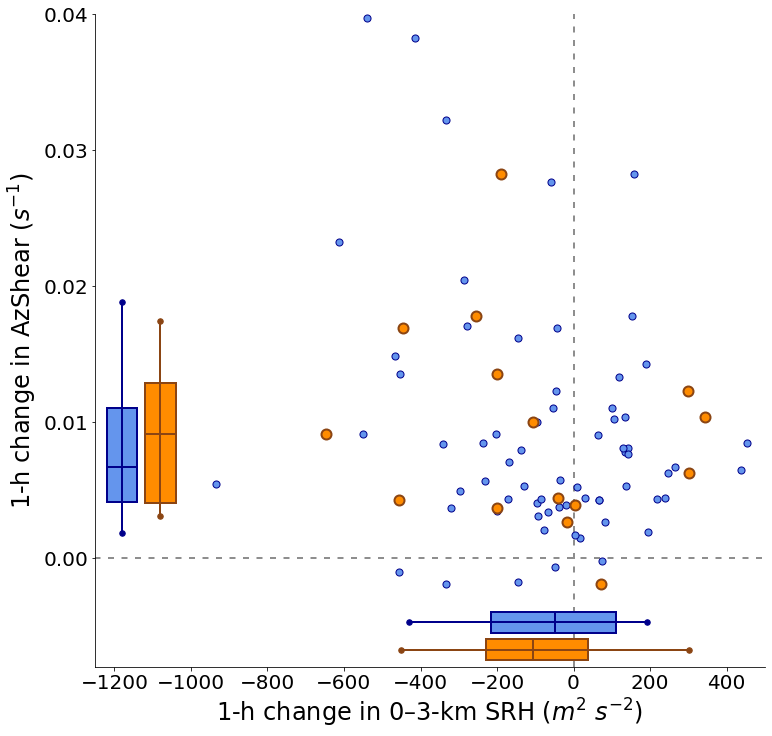

done with MLLCL at the 95 percentile
-------------------
n = 67
Max/min MLLCL : 52.41157556270096  | -58.997003627188136
Max/min AzShear difference : 5119.230769230768  |  -21.875000000000004
n = 15
Max/min MLLCL : 41.977954684629516  | -36.13001523616049
Max/min AzShear difference : 617.9431072210065  |  -5.567010309278339
MAGNITUDE CHANGE STATS:
p: 0.2868
R2: 0.0252
slope: 3.998157380523128e-06


<Figure size 864x864 with 0 Axes>

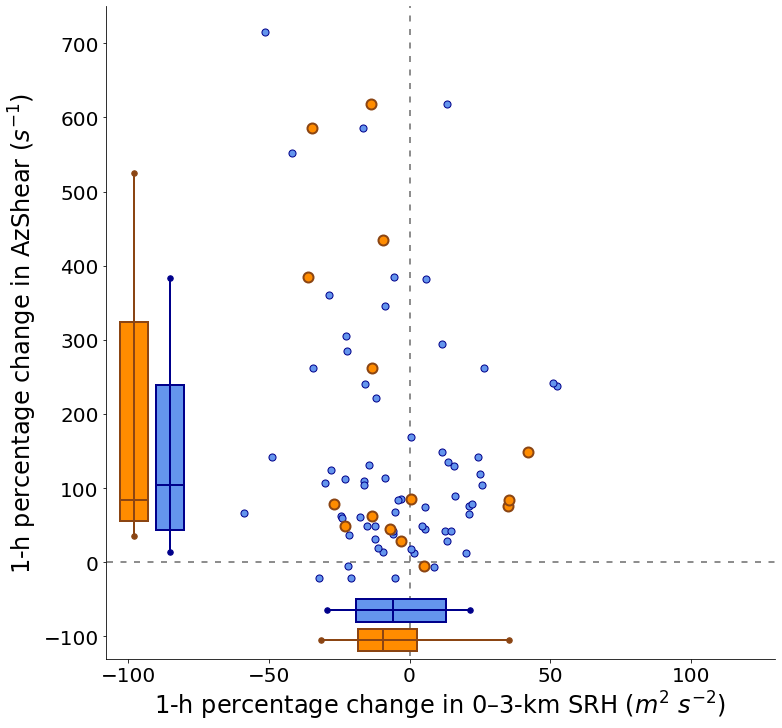

done with MLLCL at the 95 percentile
-------------------


<Figure size 864x864 with 0 Axes>

In [599]:
#----------------------------------------------------------------
# Now make some interesting plots... first, make plots of the
# percentiles against each parameter. Then on to more fun stuff.
# XX-percentile of AzShear in CAPE/shear space.
#----------------------------------------------------------------
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (12,12)

varis = 'MLLCL'

# --- actual changes ---
vari = mllcl_all
varitl = mllcl_alltl

# --- percentage changes ---
vari_perc = mllcl_all_perc
varitl_perc = mllcl_alltl_perc

print(varis)
for p in np.arange(4,5): #0,num_percs
    print(percs[p],'PERCENTILE')
    
    # --- INSTANTANEOUS REGRESSIONS ---
    var = []
    azshr = []
    
    inds_match = np.where((vari[:,p] == vari[:,p]) & (azshear_percs[:,p] == (azshear_percs[:,p])))[0]
    
    for i in np.arange(0,len(inds_match)):
        var.append(vari[inds_match[i],p])
        azshr.append(azshear_percs[inds_match[i],p])
        
    # --- now make a plot ---
    num_points = len(var)
    var = np.array(var)
    azshr = np.array(azshr)
    
    print('n =',num_points)
    print('Max/min',varis,':',np.max(var),' |',np.min(var))
    print('Max/min AzShear difference :',np.max(azshr),' | ',np.min(azshr))
    
    # --- make a plot ---
    plt.subplots()

    ax = plt.subplot(1,1,1)
    plt.scatter(var,azshr,zorder=10,s=50,c='cornflowerblue',ec='darkblue',\
                label='Instantaneous')

    x = var
    y = azshr
#     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
#     lbf = np.poly1d([slope,intercept])(np.unique(x))
#     p_value = np.round(p_value,4)
#     r_sq = np.round(r_value**2.,4)
#     plt.plot(np.unique(x),lbf,lw=3,color='k',ls='--',zorder=0,label='p = ' + str(p_value))

    # --- conduct Gaussian Kernel Density estimation ---
    xmax = x.max()
    xmin = x.min()
    ymax = y.max()
    ymin = y.min()
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x,y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
            
    # --- and plot it ---
#     ax.imshow(np.rot90(Z),cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
#     ax.set_xlim([xmin, xmax])
#     ax.set_ylim([ymin, ymax])

    # --- TIME-LAGGED REGRESSIONS
    vartl = []
    azshrtl = []
    
    inds_match = np.where((varitl[:,p] == varitl[:,p]) & (azshear_percstl[:,p] == (azshear_percstl[:,p])))[0]
    
    for i in np.arange(0,len(inds_match)):
        vartl.append(varitl[inds_match[i],p])
        azshrtl.append(azshear_percstl[inds_match[i],p])
        
    # --- now make a plot ---
    num_points = len(vartl)
    vartl = np.array(vartl)
    azshrtl = np.array(azshrtl)
    
    print('n =',num_points)
    print('Max/min',varis,':',np.max(vartl),' |',np.min(vartl))
    print('Max/min AzShear difference :',np.max(azshrtl),' | ',np.min(azshrtl))
    
    # --- make a plot ---
    plt.scatter(vartl,azshrtl,zorder=10,s=100,c='darkorange',ec='saddlebrown',lw=2,\
                label='1-h time lag')
    
    ##### now add box-and-whisker diagrams on the sides to show where the distributions lie ####
    # --- 1a. instantaneous var ---
    var_50 = np.percentile(var,50)
    var_90 = np.percentile(var,90)
    var_75 = np.percentile(var,75)
    var_25 = np.percentile(var,25)
    var_10 = np.percentile(var,10)
    plt.vlines(var_50,-0.0055,-0.004,colors='darkblue',lw=2)
    plt.vlines(var_75,-0.0055,-0.004,colors='darkblue',lw=2)
    plt.vlines(var_25,-0.0055,-0.004,colors='darkblue',lw=2)
    plt.scatter(var_90,-0.00475,c='darkblue',s=30)
    plt.scatter(var_10,-0.00475,c='darkblue',s=30)
    plt.hlines(-0.00475,var_10,var_90,lw=2,colors='darkblue')
    rect = patches.Rectangle((var_25,-0.0055), var_75-var_25, 0.0015, \
                             linewidth=2, edgecolor='darkblue', facecolor='cornflowerblue')
    ax.add_patch(rect)
    
    # --- 1b. instantaneous azshr ---
    azshr_50 = np.percentile(azshr,50)
    azshr_90 = np.percentile(azshr,90)
    azshr_75 = np.percentile(azshr,75)
    azshr_25 = np.percentile(azshr,25)
    azshr_10 = np.percentile(azshr,10)
    plt.hlines(azshr_50,-1220,-1140,colors='darkblue',lw=2)
    plt.hlines(azshr_75,-1220,-1140,colors='darkblue',lw=2)
    plt.hlines(azshr_25,-1220,-1140,colors='darkblue',lw=2)
    plt.scatter(-1180,azshr_90,c='darkblue',s=30)
    plt.scatter(-1180,azshr_10,c='darkblue',s=30)
    plt.vlines(-1180,azshr_10,azshr_90,lw=2,colors='darkblue')
    rect = patches.Rectangle((-1220,azshr_25), 80, azshr_75-azshr_25, \
                             linewidth=2, edgecolor='darkblue', facecolor='cornflowerblue')
    ax.add_patch(rect)
    
    # --- 2a. time-lagged var ---
    var_50 = np.percentile(vartl,50)
    var_90 = np.percentile(vartl,90)
    var_75 = np.percentile(vartl,75)
    var_25 = np.percentile(vartl,25)
    var_10 = np.percentile(vartl,10)
    plt.vlines(var_50,-0.0075,-0.006,colors='saddlebrown',lw=2)
    plt.vlines(var_75,-0.0075,-0.006,colors='saddlebrown',lw=2)
    plt.vlines(var_25,-0.0075,-0.006,colors='saddlebrown',lw=2)
    plt.scatter(var_90,-0.00675,c='saddlebrown',s=30)
    plt.scatter(var_10,-0.00675,c='saddlebrown',s=30)
    plt.hlines(-0.00675,var_10,var_90,lw=2,colors='saddlebrown')
    rect = patches.Rectangle((var_25,-0.0075), var_75-var_25, 0.0015, \
                             linewidth=2, edgecolor='saddlebrown', facecolor='darkorange')
    ax.add_patch(rect)
    
    # --- 2b. time-lagged azshr ---
    azshr_50 = np.percentile(azshrtl,50)
    azshr_90 = np.percentile(azshrtl,90)
    azshr_75 = np.percentile(azshrtl,75)
    azshr_25 = np.percentile(azshrtl,25)
    azshr_10 = np.percentile(azshrtl,10)
    plt.hlines(azshr_50,-1120,-1040,colors='saddlebrown',lw=2)
    plt.hlines(azshr_75,-1120,-1040,colors='saddlebrown',lw=2)
    plt.hlines(azshr_25,-1120,-1040,colors='saddlebrown',lw=2)
    plt.scatter(-1080,azshr_90,c='saddlebrown',s=30)
    plt.scatter(-1080,azshr_10,c='saddlebrown',s=30)
    plt.vlines(-1080,azshr_10,azshr_90,lw=2,colors='saddlebrown')
    rect = patches.Rectangle((-1120,azshr_25), 80, azshr_75-azshr_25, \
                             linewidth=2, edgecolor='saddlebrown', facecolor='darkorange')
    ax.add_patch(rect)
    #### done with box and whiskers ####

    plt.xticks(fontsize=20)
#     plt.xlabel(varis,fontsize=20)
    plt.xlabel('1-h change in 0–3-km SRH ($m^{2}$ $s^{-2}$)',fontsize=24)
    plt.yticks(fontsize=20)
    plt.ylabel('1-h change in AzShear ($s^{-1}$)',fontsize=24)
    # plt.title('Change in ' + varis + ' (magnitude) | n = ' + str(num_points),fontsize=20)
    # plt.legend(fontsize=20)

    # --- add text ---
#     t1 = 'p = '+ str(p_value)
#     plt.text(40,0.005,t1,fontsize=20,style='italic')
#     t2 = '$R^{2}$ = ' + str(r_sq)
#     plt.text(40,0.0025,t2,fontsize=20,style='italic')

    ax.spines[['right','top']].set_visible(False)
    
    plt.hlines(0,-1500,500,ls=(0,(4,5)),colors='dimgray',zorder=0)
    plt.vlines(0,-0.01,0.043,ls=(0,(4,5)),colors='dimgray',zorder=0)
    
    plt.xlim(-1250,500)
    plt.ylim(-0.008,0.04)
    
#     plt.legend(fancybox=True,shadow=True,loc='center right',fontsize=20)
    
    print('MAGNITUDE CHANGE STATS:')
    print('p:',p_value)
    print('R2:',r_sq)
    print('slope:',slope)

    folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
             'plots/NEW-SFCOA/azshr-params-delta/'

    plt.savefig(folder+varis+'-'+str(percs[p]),dpi=200)

    plt.show()
    plt.clf()
    
    print('done with',varis,'at the',percs[p],'percentile')
    print('-------------------')
    
    
    
    
    
    
    
    ########## NOW MAKE SECOND PLOT WITH PERCENTAGE CHANGES ##########
    # --- INSTANTANEOUS REGRESSIONS ---
    var = []
    azshr = []
    
    inds_match = np.where((vari_perc[:,p] == vari_perc[:,p]) & \
                          (azshear_percs_perc[:,p] == (azshear_percs_perc[:,p])))[0]
    
    for i in np.arange(0,len(inds_match)):
        var.append(vari_perc[inds_match[i],p])
        azshr.append(azshear_percs_perc[inds_match[i],p])
        
    # --- now make a plot ---
    num_points = len(var)
    var = np.array(var) * 100
    azshr = np.array(azshr) * 100
    
    print('n =',num_points)
    print('Max/min',varis,':',np.max(var),' |',np.min(var))
    print('Max/min AzShear difference :',np.max(azshr),' | ',np.min(azshr))
    
    # --- make a plot ---
    plt.subplots()

    ax = plt.subplot(1,1,1)
    plt.scatter(var,azshr,zorder=10,s=50,c='cornflowerblue',ec='darkblue',\
                label='Instantaneous')

    x = var
    y = azshr
#     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
#     lbf = np.poly1d([slope,intercept])(np.unique(x))
#     p_value = np.round(p_value,4)
#     r_sq = np.round(r_value**2.,4)
#     plt.plot(np.unique(x),lbf,lw=3,color='k',ls='--',zorder=0,label='p = ' + str(p_value))

    # --- conduct Gaussian Kernel Density estimation ---
    xmax = x.max()
    xmin = x.min()
    ymax = y.max()
    ymin = y.min()
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x,y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
            
    # --- and plot it ---
#     ax.imshow(np.rot90(Z),cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
#     ax.set_xlim([xmin, xmax])
#     ax.set_ylim([ymin, ymax])

    # --- TIME-LAGGED REGRESSIONS
    vartl = []
    azshrtl = []
    
    inds_match = np.where((varitl_perc[:,p] == varitl_perc[:,p]) & \
                          (azshear_percstl_perc[:,p] == (azshear_percstl_perc[:,p])))[0]
    
    for i in np.arange(0,len(inds_match)):
        vartl.append(varitl_perc[inds_match[i],p])
        azshrtl.append(azshear_percstl_perc[inds_match[i],p])
        
    # --- now make a plot ---
    num_points = len(vartl)
    vartl = np.array(vartl) * 100
    azshrtl = np.array(azshrtl) * 100
    
    print('n =',num_points)
    print('Max/min',varis,':',np.max(vartl),' |',np.min(vartl))
    print('Max/min AzShear difference :',np.max(azshrtl),' | ',np.min(azshrtl))
    
    # --- make a plot ---
    plt.scatter(vartl,azshrtl,zorder=10,s=100,c='darkorange',ec='saddlebrown',lw=2,\
                label='1-h time lag')
    
    ##### now add box-and-whisker diagrams on the sides to show where the distributions lie ####
    # --- 1a. instantaneous var ---
    var_50 = np.percentile(var,50)
    var_90 = np.percentile(var,90)
    var_75 = np.percentile(var,75)
    var_25 = np.percentile(var,25)
    var_10 = np.percentile(var,10)
    plt.vlines(var_50,-80,-50,colors='darkblue',lw=2)
    plt.vlines(var_75,-80,-50,colors='darkblue',lw=2)
    plt.vlines(var_25,-80,-50,colors='darkblue',lw=2)
    plt.scatter(var_90,-65,c='darkblue',s=30)
    plt.scatter(var_10,-65,c='darkblue',s=30)
    plt.hlines(-65,var_10,var_90,lw=2,colors='darkblue')
    rect = patches.Rectangle((var_25,-80), var_75-var_25, 30, \
                             linewidth=2, edgecolor='darkblue', facecolor='cornflowerblue')
    ax.add_patch(rect)
    
    # --- 1b. instantaneous azshr ---
    azshr_50 = np.percentile(azshr,50)
    azshr_90 = np.percentile(azshr,90)
    azshr_75 = np.percentile(azshr,75)
    azshr_25 = np.percentile(azshr,25)
    azshr_10 = np.percentile(azshr,10)
    plt.hlines(azshr_50,-90,-80,colors='darkblue',lw=2)
    plt.hlines(azshr_75,-90,-80,colors='darkblue',lw=2)
    plt.hlines(azshr_25,-90,-80,colors='darkblue',lw=2)
    plt.scatter(-85,azshr_90,c='darkblue',s=30)
    plt.scatter(-85,azshr_10,c='darkblue',s=30)
    plt.vlines(-85,azshr_10,azshr_90,lw=2,colors='darkblue')
    rect = patches.Rectangle((-90,azshr_25), 10, azshr_75-azshr_25, \
                             linewidth=2, edgecolor='darkblue', facecolor='cornflowerblue')
    ax.add_patch(rect)
    
    # --- 2a. time-lagged var ---
    var_50 = np.percentile(vartl,50)
    var_90 = np.percentile(vartl,90)
    var_75 = np.percentile(vartl,75)
    var_25 = np.percentile(vartl,25)
    var_10 = np.percentile(vartl,10)
    plt.vlines(var_50,-120,-90,colors='saddlebrown',lw=2)
    plt.vlines(var_75,-120,-90,colors='saddlebrown',lw=2)
    plt.vlines(var_25,-120,-90,colors='saddlebrown',lw=2)
    plt.scatter(var_90,-105,c='saddlebrown',s=30)
    plt.scatter(var_10,-105,c='saddlebrown',s=30)
    plt.hlines(-105,var_10,var_90,lw=2,colors='saddlebrown')
    rect = patches.Rectangle((var_25,-120), var_75-var_25, 30, \
                             linewidth=2, edgecolor='saddlebrown', facecolor='darkorange')
    ax.add_patch(rect)
    
    # --- 2b. time-lagged azshr ---
    azshr_50 = np.percentile(azshrtl,50)
    azshr_90 = np.percentile(azshrtl,90)
    azshr_75 = np.percentile(azshrtl,75)
    azshr_25 = np.percentile(azshrtl,25)
    azshr_10 = np.percentile(azshrtl,10)
    plt.hlines(azshr_50,-103,-93,colors='saddlebrown',lw=2)
    plt.hlines(azshr_75,-103,-93,colors='saddlebrown',lw=2)
    plt.hlines(azshr_25,-103,-93,colors='saddlebrown',lw=2)
    plt.scatter(-98,azshr_90,c='saddlebrown',s=30)
    plt.scatter(-98,azshr_10,c='saddlebrown',s=30)
    plt.vlines(-98,azshr_10,azshr_90,lw=2,colors='saddlebrown')
    rect = patches.Rectangle((-103,azshr_25), 10, azshr_75-azshr_25, \
                             linewidth=2, edgecolor='saddlebrown', facecolor='darkorange')
    ax.add_patch(rect)
    #### done with box and whiskers ####
    
    
    
    plt.xticks(fontsize=20)
#     plt.xlabel(varis,fontsize=20)
    plt.xlabel('1-h percentage change in 0–3-km SRH ($m^{2}$ $s^{-2}$)',fontsize=24)
    plt.yticks(fontsize=20)
    plt.ylabel('1-h percentage change in AzShear ($s^{-1}$)',fontsize=24)
    # plt.title('Change in ' + varis + ' (magnitude) | n = ' + str(num_points),fontsize=20)
    # plt.legend(fontsize=20)

    # --- add text ---
#     t1 = 'p = '+ str(p_value)
#     plt.text(40,0.005,t1,fontsize=20,style='italic')
#     t2 = '$R^{2}$ = ' + str(r_sq)
#     plt.text(40,0.0025,t2,fontsize=20,style='italic')

    ax.spines[['right','top']].set_visible(False)
    
    plt.hlines(0,-200,150,ls=(0,(4,5)),colors='dimgray',zorder=0)
    plt.vlines(0,-200,1000,ls=(0,(4,5)),colors='dimgray',zorder=0)
    
    plt.xlim(-108,130)
    plt.ylim(-130,750)
    
#     plt.legend(fancybox=True,shadow=True,loc='center right',fontsize=20)
    
    print('MAGNITUDE CHANGE STATS:')
    print('p:',p_value)
    print('R2:',r_sq)
    print('slope:',slope)

    folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
             'plots/NEW-SFCOA/azshr-params-delta/'

    plt.savefig(folder+varis+'-'+str(percs[p])+'-percs',dpi=200)

    plt.show()
    plt.clf()
    
    print('done with',varis,'at the',percs[p],'percentile')
    print('-------------------')


AzShear variables
(342, 65)
(342, 65)
(342,)
<class 'list'>
Environmental variables
(339, 8)
(339, 8)
(339, 8)
<class 'numpy.ndarray'>
p: 0.2868
R2: 0.0252


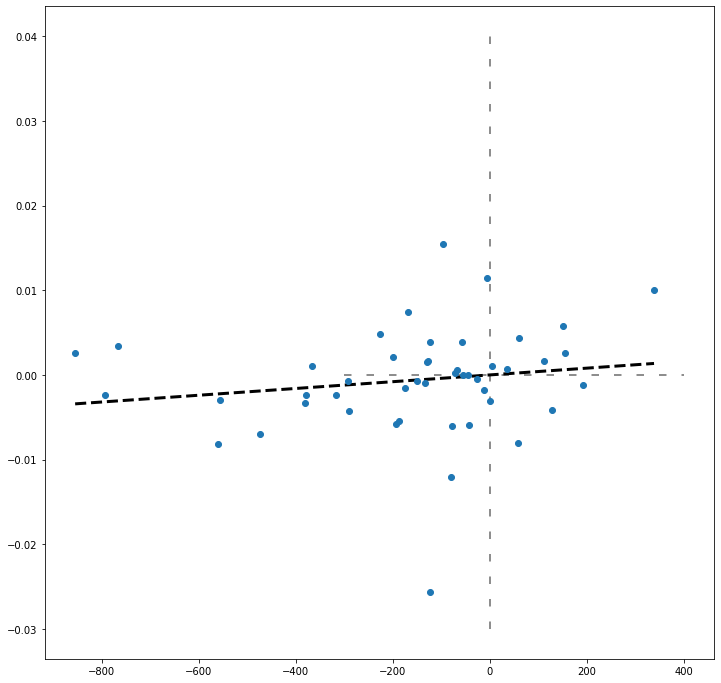

In [573]:
#----------------------------------------------------------------------
#              ** cell for revisions, skip if needed **
#
# Do some additional analysis here for Casey. Look at random periods
# of supercell lifecycles (irrespective of the top percentile of
# AzShear) and see if the change in AzShear during a time period
# is correlated with the change in environmental variables during
# that same period (or an earlier one).
#----------------------------------------------------------------------
print('AzShear variables')
print(np.shape(fstormazshr))
print(np.shape(fstormtime))
print(np.shape(fstormID))
print(type(fstormID))

print('Environmental variables')
print(np.shape(srh03i))
print(np.shape(timei))
print(np.shape(stormIDi))
print(type(stormIDi))

fstormIDa = np.array(fstormID)

azshr_change = np.ones((np.shape(srh03i)[0]))*np.nan
var_change = np.ones((np.shape(srh03i)[0]))*np.nan

voi = sblcli

count = 0
for s in np.arange(0,len(fstormID)):
    match = np.where(stormIDi[:,0] == fstormIDa[s])[0]
    this_ID = fstormID[s]
    
    if match == match:
        if fstormazshr[s,0] != fstormazshr[s,0]:
            continue
            
        len_this_storm = max(np.where(fstormazshr[s,:] == fstormazshr[s,:])[0])
        
        if len_this_storm > 25: # 13 for instantaneous env regression, 25 for one hour lag
            ind_start = random.randint(1,len_this_storm-12-1) # 1 buffer here for mean calculations
            ind_end = ind_start + 12
            
            # --- get AzShear difference (mean around start/end times) ---
            azshr_change[count] = np.mean(fstormazshr[s,ind_end-1:ind_end+2]) - \
                                  np.mean(fstormazshr[s,ind_start-1:ind_start+2])
            
            # --- now get the AzShear times and extract environmental difference ---
            yyyymmdd_stri = convert(split(this_ID)[0:8])

            these_times_high = np.array([fstormtime[s,ind_start],fstormtime[s,ind_end]])
            times = np.empty(len(these_times_high),dtype=object)
            yyyymmdd_str = ['']*len(these_times_high)
            hhmm = np.ones((len(these_times_high)))*np.nan
            hhmm_str = ['']*len(these_times_high)

            for t in np.arange(0,len(these_times_high)):
                hhmm[t] = int(these_times_high[t])

                # --- format hhmm(ss) ---
                if hhmm[t] < 10:
                    hhmm_str[t] = '00000' + str(hhmm[t])
                if (hhmm[t] >= 10) & (hhmm[t] < 100):
                    hhmm_str[t] = '0000' + str(hhmm[t])
                if (hhmm[t] >= 100) & (hhmm[t] < 1000):
                    hhmm_str[t] = '000' + str(hhmm[t])
                if (hhmm[t] >= 1000) & (hhmm[t] < 10000):
                    hhmm_str[t] = '00' + str(hhmm[t])
                if (hhmm[t] >= 10000) & (hhmm[t] < 100000):
                    hhmm_str[t] = '0' + str(hhmm[t])
                if (hhmm[t] >= 100000):
                    hhmm_str[t] = str(hhmm[t])

                # --- limit to just hhmm ---
                hhmm_str[t] = convert(split(hhmm_str[t])[0:4])

                # --- change date if necessary ---
                if hhmm[t] >= 110000:
                    yyyymmdd_str[t] = yyyymmdd_stri
                else:
                    yyyymmdd_str[t] = datetime.strftime(datetime.strptime(yyyymmdd_stri,'%Y%m%d') + \
                                                     timedelta(hours=24),'%Y%m%d')

                # --- create full initial (pre-rounded) datetime object ---
                times[t] = datetime.strptime(yyyymmdd_str[t] + hhmm_str[t],'%Y%m%d%H%M')

            # --- now average all times to get the final time (pre-rounded) ---
            diffs = np.ones((len(these_times_high)))*np.nan
            for t in np.arange(0,len(these_times_high)):
                diffs[t] = (times[t] - datetime(1970,1,1)).total_seconds()

            mean_diff = np.mean(diffs)

            if mean_diff != mean_diff:
                continue

            mean_time = datetime.fromtimestamp(mean_diff,timezone.utc).strftime('%Y-%m-%d %H:%M')
            mean_time_dt = datetime.strptime(mean_time,'%Y-%m-%d %H:%M')

            # --- now round and get the final hourly datetime object ---
            # NOTE: the "- timedelta(hours=time_buff)" was added in Dec
            #       2023 for Casey's revisions. time_buff = 0 gives the
            #       same regressions as the original submission.
            if mean_time_dt.minute < 30:
                final_time_dt = mean_time_dt.replace(minute=0) - timedelta(hours=1) # INCLUDE THIS SUBTRACTION
                                                                                    # TO COMPARE 1-hr AzShear changes
                                                                                    # with 2–1-hr env changes
            if mean_time_dt.minute >= 30:
                final_time_dt = mean_time_dt.replace(minute=0) + timedelta(hours=1) - timedelta(hours=1)
                
            #----------------------------------------------------------------
            # Now extract environmntal info by pairing the storm ID and
            # hourly analysis time with the SFCOA arrays.
            #----------------------------------------------------------------
            print_stuff = 'N'
            this_time_str = datetime.strftime(final_time_dt,'%Y%m%d%H')
            if print_stuff == 'Y': print('working with',this_ID,'at',this_time_str)
            
            time_ID = np.where(timei[match,:][0] == this_time_str)[0]

            if len(time_ID) == 0:        
                badcount += 1
                badtimecount += 1
                if print_stuff == 'Y': print('This hour for this storm not found in SFCOA')
                if print_stuff == 'Y': print('Available times:',timei[match_ID,:][0])
                continue

            if print_stuff == 'Y': print('Desired time:',this_ID,this_time_str)
            if print_stuff == 'Y': print('SFCOA match:',stormIDi[match_ID,time_ID],timei[match_ID,time_ID])
            if print_stuff == 'Y': print('-------')

            # --- get hourly environmental variable change ---
            var_change[count] = voi[match,time_ID] - voi[match,time_ID-1]
                        
#             mlcape_all[s,p] = mlcapei[match_ID,time_ID] - mlcapei[match_ID,time_ID-time_buff]
#             sbcape_all[s,p] = sbcapei[match_ID,time_ID] - sbcapei[match_ID,time_ID-time_buff]
#             mucape_all[s,p] = mucapei[match_ID,time_ID] - mucapei[match_ID,time_ID-time_buff]
#             mlcin_all[s,p] = mlcini[match_ID,time_ID] - mlcini[match_ID,time_ID-time_buff]
#             sbcin_all[s,p] = sbcini[match_ID,time_ID] - sbcini[match_ID,time_ID-time_buff]
#             mucin_all[s,p] = mucini[match_ID,time_ID] - mucini[match_ID,time_ID-time_buff]
#             mllcl_all[s,p] = mllcli[match_ID,time_ID] - mllcli[match_ID,time_ID-time_buff]
#             sblcl_all[s,p] = sblcli[match_ID,time_ID] - sblcli[match_ID,time_ID-time_buff]

#             shr01_all[s,p] = shr01i[match_ID,time_ID] - shr01i[match_ID,time_ID-time_buff]
#             shr03_all[s,p] = shr03i[match_ID,time_ID] - shr03i[match_ID,time_ID-time_buff]
#             shr06_all[s,p] = shr06i[match_ID,time_ID] - shr06i[match_ID,time_ID-time_buff]

#             srh01_all[s,p] = srh01i[match_ID,time_ID] - srh01i[match_ID,time_ID-time_buff]
#             srh03_all[s,p] = srh03i[match_ID,time_ID] - srh03i[match_ID,time_ID-time_buff]
#             scp_all[s,p] = scpi[match_ID,time_ID] - scpi[match_ID,time_ID-time_buff]
            
            ###################
            
            count += 1
            
# --- remove nans and plot ---
inds_keep = np.where((var_change == var_change) & (azshr_change == azshr_change))[0]
x = var_change[inds_keep]
y = azshr_change[inds_keep]

plt.scatter(x,y)
plt.hlines(0,-300,400,ls=(0,(5,10)),colors='dimgray',zorder=0)
plt.vlines(0,-0.03,0.04,ls=(0,(5,10)),colors='dimgray',zorder=0)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
lbf = np.poly1d([slope,intercept])(np.unique(x))
p_value = np.round(p_value,4)
r_sq = np.round(r_value**2.,4)
plt.plot(np.unique(x),lbf,lw=3,color='k',ls='--',zorder=0,label='p = ' + str(p_value))

print('p:',p_value)
print('R2:',r_sq)
            


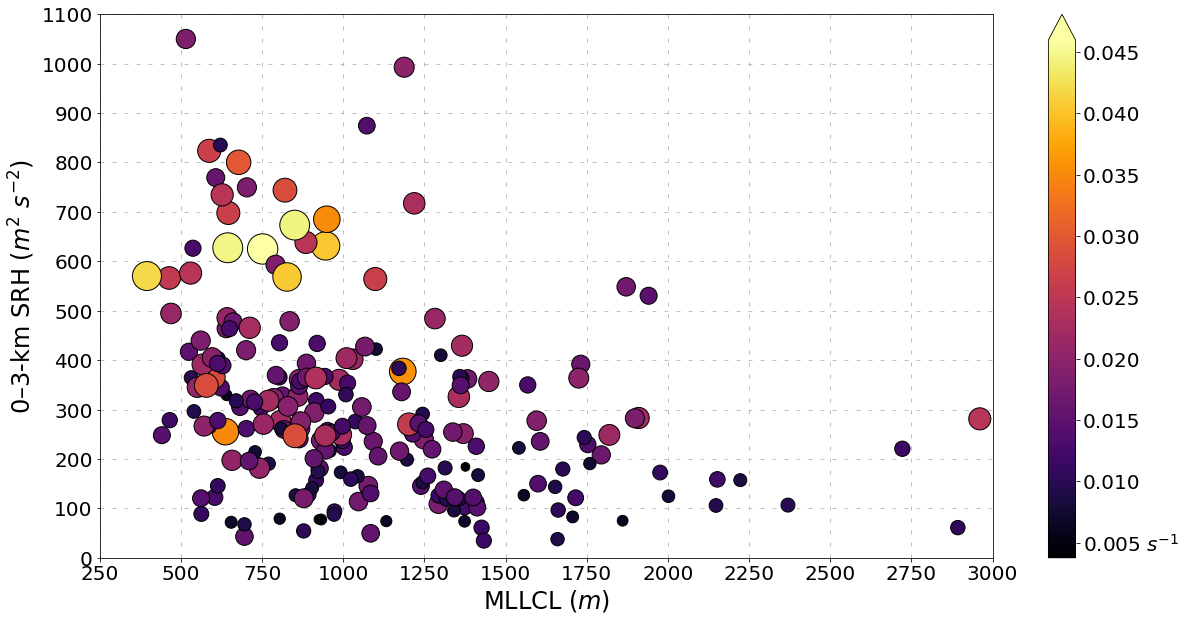

In [625]:
#----------------------------------------------------------------
# XX-percentile of AzShear in CAPE/shear space.
#----------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

p = 4 # pick the percentile (25,50,75,90,95,98)

var1 = mllcl_all[:,p]
var2 = srh03_all[:,p]

azshear_inds = np.where(azshear_percs[:,p] == azshear_percs[:,p])[0]
var1_inds = np.where(var1 == var1)[0]
var2_inds = np.where(var2 == var2)[0]

all_inds = []
for s in np.arange(0,num_storms):
    var1_good = 'N'
    var2_good = 'N'
    azshear_good = 'N'
    
    if len(np.where(var1_inds == s)[0]) > 0:
        var1_good = 'Y'
    if len(np.where(var2_inds == s)[0]) > 0:
        var2_good = 'Y'
    if len(np.where(azshear_inds == s)[0]) > 0:
        azshear_good = 'Y'
        
    if (var1_good == 'Y') & (var2_good == 'Y') & (azshear_good == 'Y'):
        all_inds.append(s)
        
all_inds = np.array(all_inds)

azshearf = azshear_percs[all_inds,p]
var1f = var1[all_inds]
var2f = var2[all_inds]

plt.scatter(var1f,var2f,c=azshearf,s=azshearf*20000,ec='k',cmap='inferno',zorder=5)

# --- axis specificiations ---
plt.xlim(250,3000)
xticks = np.arange(250,3250,250)
plt.xticks(xticks,fontsize=20)
plt.xlabel('MLLCL ($m$)',fontsize=24)

plt.ylim(0,1100)
yticks = np.arange(0,1200,100)
plt.yticks(yticks,fontsize=20)
plt.ylabel('0–3-km SRH ($m^{2}$ $s^{-2}$)',fontsize=24)

# --- colorbar specifications ---
cb = plt.colorbar(extend='max')
labels = ['','0.005 $s^{-1}$','0.010','0.015','0.020','0.025','0.030','0.035','0.040','0.045']
cb.ax.set_yticklabels(labels)
cb.ax.tick_params(labelsize=20)

plt.grid(ls=(0,(5,10)),zorder=0)

folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
         'plots/NEW-SFCOA/azshr-bulk-params/'
file = '2D-srh03-mllcl-scatter-CB'

# plt.savefig(folder+file+'-'+str(percs[p]),dpi=200)





223 223
(12, 12)
mean_azshr [[       nan 0.01067862 0.00787033 0.01084625 0.00954112 0.00877317
  0.005814          nan        nan        nan 0.0104            nan]
 [       nan 0.01499857 0.0108835  0.01243987 0.01165023 0.0104042
  0.0092935  0.0094465  0.009748          nan        nan        nan]
 [0.0130975  0.01609807 0.0166981  0.01555095 0.0157253  0.013211
  0.018464          nan        nan 0.011699   0.024394          nan]
 [       nan 0.01588164 0.01694144 0.01715133 0.01626833 0.01668863
         nan        nan        nan        nan        nan        nan]
 [0.021111   0.01711135 0.01503867 0.01711962 0.01712333        nan
         nan        nan        nan        nan        nan        nan]
 [0.03375525 0.024492   0.029557   0.026506          nan        nan
  0.015808          nan        nan        nan        nan        nan]
 [       nan 0.028039   0.0381141         nan        nan        nan
         nan        nan        nan        nan        nan        nan]
 [       nan 0.0

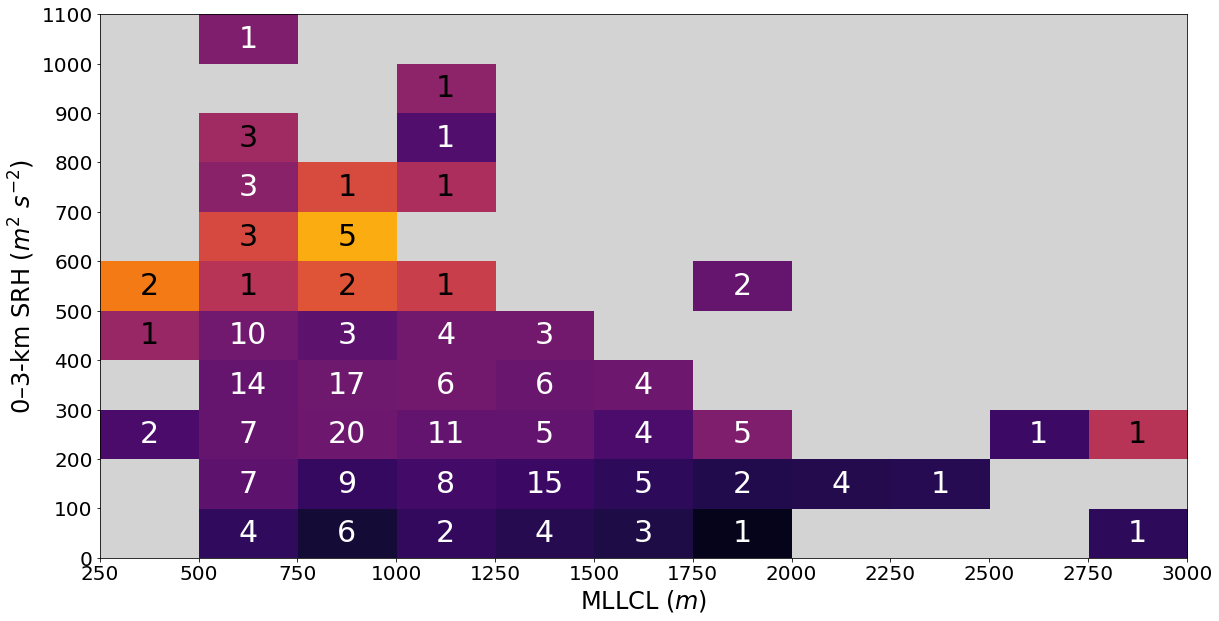

<Figure size 1440x720 with 0 Axes>

In [627]:
#----------------------------------------------------------------------
# Make a second plot binning the x and y axes and computing mean
# 95-percentile AzShear in each bin.
#
# First compute the bins.
#----------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

var1  = var1f
var2  = var2f
azshr = azshearf

print(len(var1),len(var2))

b1s = 250
b1e = 3250
b1inc = 250
b2s = 0
b2e = 1200
b2inc = 100

num_b1 = len(np.arange(b1s,b1e,b1inc))
num_b2 = len(np.arange(b2s,b2e,b2inc))

num_inbin  = np.ones((num_b2,num_b1))*np.nan
mean_azshr = np.ones((num_b2,num_b1))*np.nan

b1c = 0
for b1 in np.arange(b1s,b1e,b1inc):
    b2c = 0
    for b2 in np.arange(b2s,b2e,b2inc):
        # --- define the bin ---
        b1l = b1
        b1h = b1+b1inc
        b2l = b2
        b2h = b2+b2inc
        
#         print('--- BIN',b1,b2,'---')
#         print('MLLCL:',b1l,'–',b1h)
#         print('SRH03:',b2l,'–',b2h)
                
        hit_lcl = np.where((var1 >= b1l) & (var1 < b1h))[0]
        hit_shr = np.where((var2 >= b2l) & (var2 < b2h))[0]
        
        hits = []
        
        for h in np.arange(0,len(hit_lcl)):
            question_hit = np.where(hit_shr == hit_lcl[h])[0]
            if question_hit == question_hit:
                hits.append(hit_lcl[h])
                    
        hits = np.array(hits)
        
#         print('Number of hits:',hits)
        
        if len(hits) >= 1:
            azshr_bin = []
            for i in np.arange(0,len(hits)):
                azshr_bin.append(azshr[hits[i]])
                
            azshr_bin = np.array(azshr_bin)
            mean_azshr[b2c,b1c] = np.mean(azshr_bin)
            num_inbin[b2c,b1c] = len(hits)
            
#             print(num_inbin[b1c,b2c],mean_azshr[b1c,b2c])
            
        b2c += 1
        
    b1c += 1
    
#----------------------------------------------------------------------
# Now plot!
#----------------------------------------------------------------------
xs = np.arange(b1s,b1e,b1inc)
ys = np.arange(b2s,b2e,b2inc)

print(np.shape(mean_azshr))
plt.imshow(mean_azshr,cmap='inferno',aspect=0.5,vmin=0.00375,vmax=0.046)
plt.gca().invert_yaxis()
print('mean_azshr',mean_azshr)

ax = plt.gca()
ax.set_facecolor('lightgray')

xticks = np.arange(-0.5,11,1)
xlabels = np.arange(250,3250,250)
plt.xticks(xticks,labels=xlabels,fontsize=20)
plt.xlabel('MLLCL ($m$)',fontsize=24)

yticks = np.arange(-0.5,11.5)
ylabels = np.arange(0,1200,100)
plt.yticks(yticks,labels=ylabels,fontsize=20)
plt.ylabel('0–3-km SRH ($m^{2}$ $s^{-2}$)',fontsize=24)

plt.xlim(-0.5,10.5)
plt.ylim(-0.5,10.5)

xcount = 0
for x in xs:
    ycount = 0
    for y in ys:
        if num_inbin[ycount,xcount] == num_inbin[ycount,xcount]:            
            if mean_azshr[ycount,xcount] < 0.02:
                fc = 'white'
            else:
                fc = 'k'
            plt.text(xcount,ycount,int(num_inbin[ycount,xcount]),fontsize=30,\
                     va='center',ha='center',color=fc)
        ycount += 1
    xcount += 1
    
# --- colorbar stuff ---
# cb = plt.colorbar(extend='max')
# cb.ax.tick_params(labelsize=20)
# cb.ax.set_yticklabels(['','-0.006 $s^{-1}$','-0.004','-0.002','0','0.002','0.004','0.006'])

folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
         'plots/NEW-SFCOA/azshr-bulk-params/'
title = '2D-srh03-mllcl-bin-noCB'
# plt.savefig(folder+title+'-'+str(percs[p]),dpi=200)

plt.show()
plt.clf()




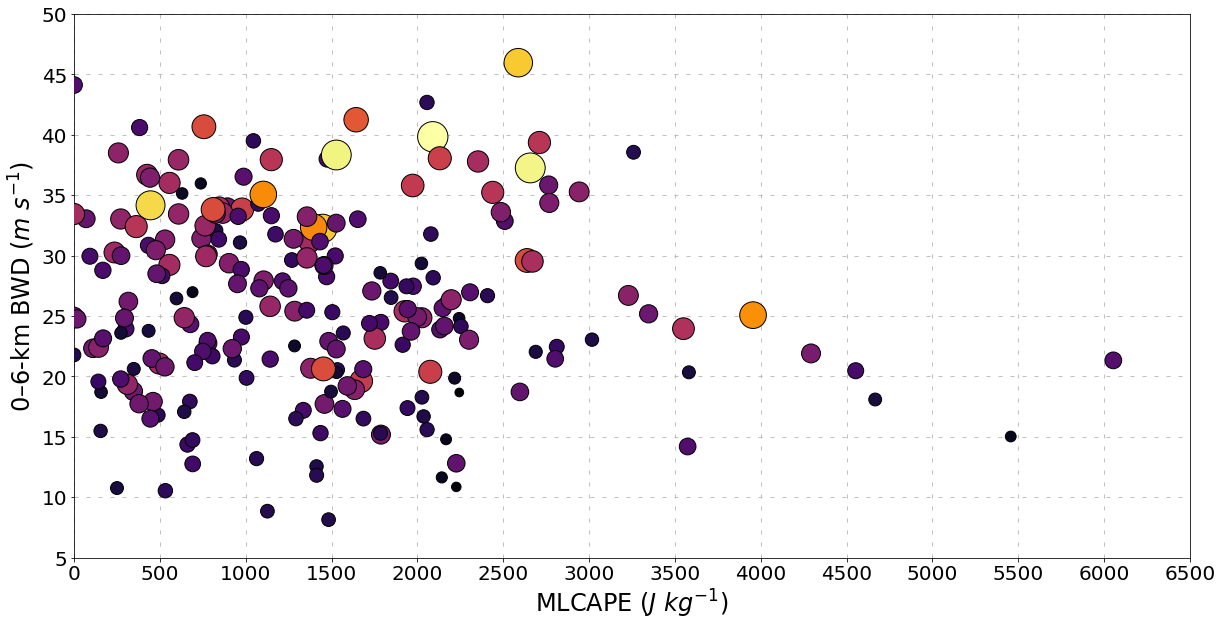

In [27]:
#----------------------------------------------------------------
# XX-percentile of AzShear in CAPE/shear space.
#----------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

p = 4 # pick the percentile (25,50,75,90,95,98)

var1 = mlcape_all[:,p]
var2 = shr06_all[:,p]

azshear_inds = np.where(azshear_percs[:,p] == azshear_percs[:,p])[0]
var1_inds = np.where(var1 == var1)[0]
var2_inds = np.where(var2 == var2)[0]

all_inds = []
for s in np.arange(0,num_storms):
    var1_good = 'N'
    var2_good = 'N'
    azshear_good = 'N'
    
    if len(np.where(var1_inds == s)[0]) > 0:
        var1_good = 'Y'
    if len(np.where(var2_inds == s)[0]) > 0:
        var2_good = 'Y'
    if len(np.where(azshear_inds == s)[0]) > 0:
        azshear_good = 'Y'
        
    if (var1_good == 'Y') & (var2_good == 'Y') & (azshear_good == 'Y'):
        all_inds.append(s)
        
all_inds = np.array(all_inds)

azshearf = azshear_percs[all_inds,p]
var1f = var1[all_inds]
var2f = var2[all_inds]

plt.scatter(var1f,var2f,c=azshearf,s=azshearf*20000,ec='k',cmap='inferno',zorder=5)

# --- axis specificiations ---
plt.xlim(0,6500)
xticks = np.arange(0,7000,500)
plt.xticks(xticks,fontsize=20)
plt.xlabel('MLCAPE ($J$ $kg^{-1}$)',fontsize=24)

plt.ylim(5,50)
yticks = np.arange(5,55,5)
plt.yticks(yticks,fontsize=20)
plt.ylabel('0–6-km BWD ($m$ $s^{-1}$)',fontsize=24)

# --- colorbar specifications ---
# cb = plt.colorbar(extend='max')
# labels = ['','0.005 $s^{-1}$','0.010','0.015','0.020','0.025','0.030','0.035','0.040','0.045']
# cb.ax.set_yticklabels(labels)
# cb.ax.tick_params(labelsize=20)

plt.grid(ls=(0,(5,10)),zorder=0)

folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
         'plots/NEW-SFCOA/azshr-bulk-params/'
file = '2D-shr06-mlcape-scatter-noCB'

# plt.savefig(folder+file+'-'+str(percs[p]),dpi=200)





(11, 13)


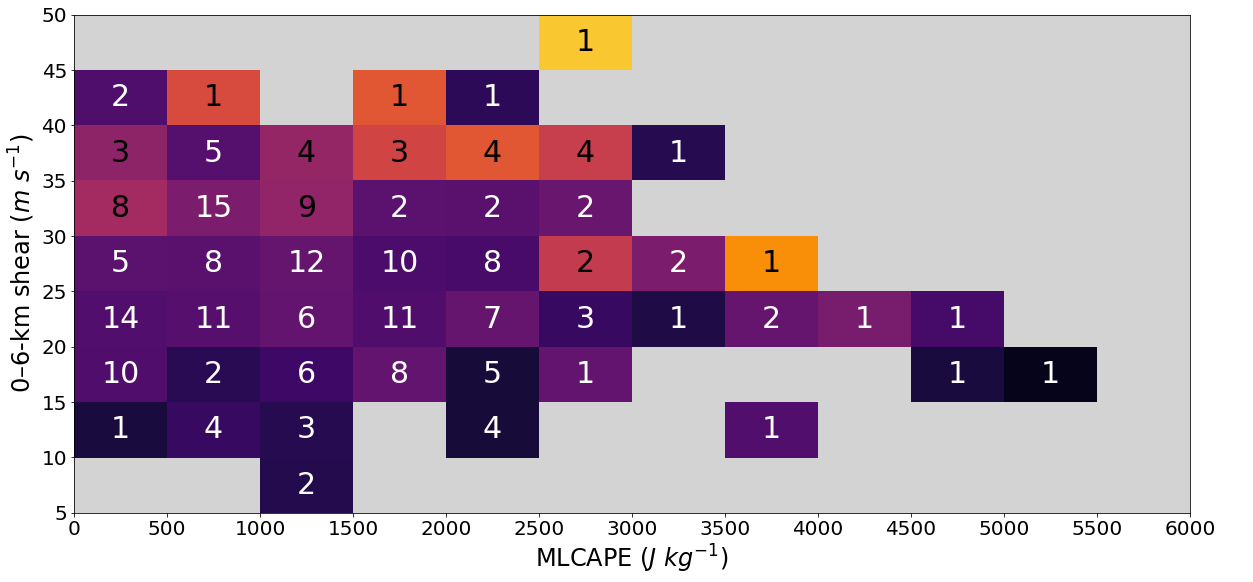

<Figure size 1440x720 with 0 Axes>

In [28]:
#----------------------------------------------------------------------
# Make a second plot binning the x and y axes and computing mean
# 95-percentile AzShear in each bin.
#
# First compute the bins.
#----------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

var1  = var1f
var2  = var2f
azshr = azshearf

b1s = 0
b1e = 6500
b1inc = 500
b2s = 0
b2e = 55
b2inc = 5

num_b1 = len(np.arange(b1s,b1e,b1inc))
num_b2 = len(np.arange(b2s,b2e,b2inc))

num_inbin  = np.ones((num_b2,num_b1))*np.nan
mean_azshr = np.ones((num_b2,num_b1))*np.nan

b1c = 0
for b1 in np.arange(b1s,b1e,b1inc):
    b2c = 0
    for b2 in np.arange(b2s,b2e,b2inc):
        # --- define the bin ---
        b1l = b1
        b1h = b1+b1inc
        b2l = b2
        b2h = b2+b2inc
        
#         print('--- BIN',b1,b2,'---')
#         print('MLLCL:',b1l,'–',b1h)
#         print('SRH03:',b2l,'–',b2h)
                
        hit_lcl = np.where((var1 >= b1l) & (var1 < b1h))[0]
        hit_shr = np.where((var2 >= b2l) & (var2 < b2h))[0]
        
        hits = []
        
        for h in np.arange(0,len(hit_lcl)):
            question_hit = np.where(hit_shr == hit_lcl[h])[0]
            if question_hit == question_hit:
                hits.append(hit_lcl[h])
                    
        hits = np.array(hits)
        
#         print('Number of hits:',hits)
        
        if len(hits) >= 1:
            azshr_bin = []
            for i in np.arange(0,len(hits)):
                azshr_bin.append(azshr[hits[i]])
                
            azshr_bin = np.array(azshr_bin)
            mean_azshr[b2c,b1c] = np.mean(azshr_bin)
            num_inbin[b2c,b1c] = len(hits)
            
#             print(num_inbin[b1c,b2c],mean_azshr[b1c,b2c])
            
        b2c += 1
        
    b1c += 1
    
#----------------------------------------------------------------------
# Now plot!
#----------------------------------------------------------------------
xs = np.arange(b1s,b1e,b1inc)
ys = np.arange(b2s,b2e,b2inc)

print(np.shape(mean_azshr))
plt.imshow(mean_azshr,cmap='inferno',aspect=0.595,vmin=0.00375,vmax=0.046)
plt.gca().invert_yaxis()

ax = plt.gca()
ax.set_facecolor('lightgray')

xticks = np.arange(-0.5,12.5)
xlabels = np.arange(0,6500,500)
plt.xticks(xticks,labels=xlabels,fontsize=20)
plt.xlabel('MLCAPE ($J$ $kg^{-1}$)',fontsize=24)

yticks = np.arange(0.5,10.5)
ylabels = np.arange(5,55,5)
plt.yticks(yticks,labels=ylabels,fontsize=20)
plt.ylabel('0–6-km shear ($m$ $s^{-1}$)',fontsize=24)

plt.xlim(-0.5,11.5)
plt.ylim(0.5,9.5)

xcount = 0
for x in xs:
    ycount = 0
    for y in ys:
        if num_inbin[ycount,xcount] == num_inbin[ycount,xcount]:            
            if mean_azshr[ycount,xcount] < 0.02:
                fc = 'white'
            else:
                fc = 'k'
            plt.text(xcount,ycount,int(num_inbin[ycount,xcount]),fontsize=30,\
                     va='center',ha='center',color=fc)
        ycount += 1
    xcount += 1
    
# cb = plt.colorbar(extend='max')
# cb.ax.tick_params(labelsize=20)
# cb.ax.set_yticklabels(['','-0.006 $s^{-1}$','-0.004','-0.002','0','0.002','0.004','0.006'])

folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
         'plots/NEW-SFCOA/azshr-bulk-params/'
title = '2D-shr06-mlcape-bin-noCB'
# plt.savefig(folder+title+'-'+str(percs[p]),dpi=200)

plt.show()
plt.clf()




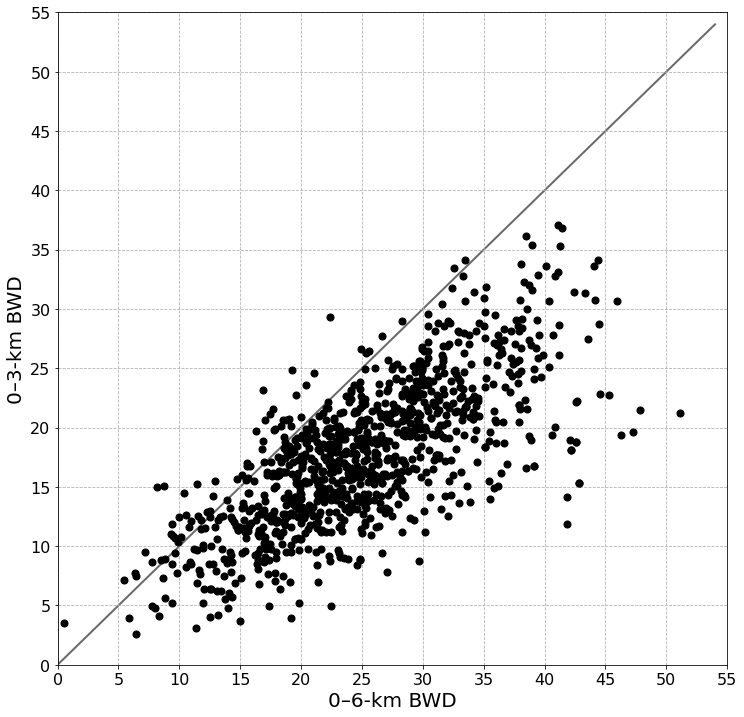

<Figure size 864x864 with 0 Axes>

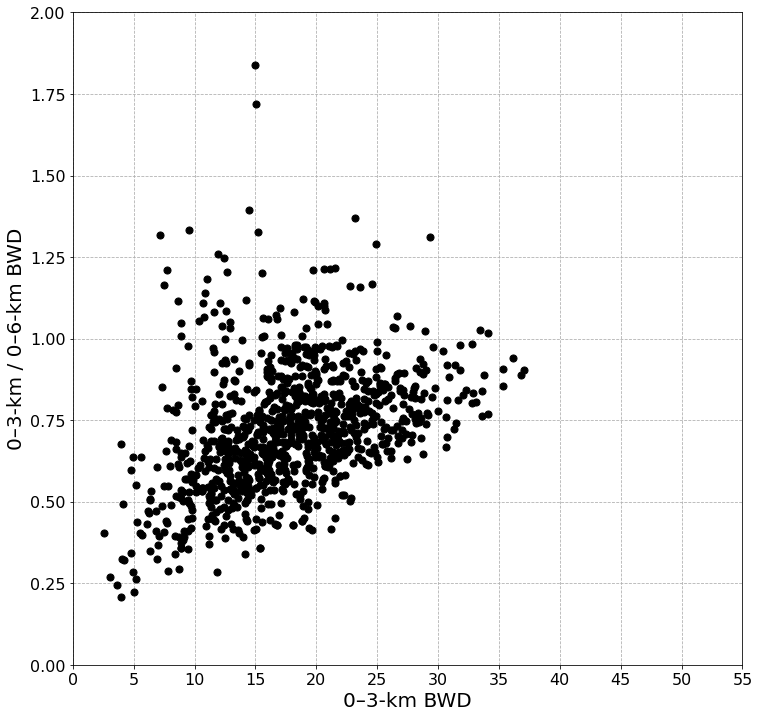

<Figure size 864x864 with 0 Axes>

In [29]:
#----------------------------------------------------------------------
# Compare 0–6-km BWD and 0–3-km BWD across the dataset for Tony.
#----------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (12,12)

plt.figure()
for s in np.arange(0,np.shape(shr06i)[0]):
        plt.scatter(shr06i[s,:],shr03i[s,:],c='k',s=50,zorder=5)
        
x = np.arange(0,55)
y = np.arange(0,55)

plt.plot(x,y,lw=2,ls='-',c='dimgray',zorder=0)

plt.xlim(0,55)
plt.ylim(0,55)

plt.xlabel('0–6-km BWD',fontsize=20)
plt.ylabel('0–3-km BWD',fontsize=20)

plt.xticks(np.arange(0,60,5),fontsize=16)
plt.yticks(np.arange(0,60,5),fontsize=16)

plt.grid(ls='--',zorder=0)
        
plt.show()
plt.clf()


plt.figure()
for s in np.arange(0,np.shape(shr06i)[0]):
        plt.scatter(shr03i[s,:],(shr03i[s,:]/shr06i[s,:]),c='k',s=50,zorder=5)
        
x = np.arange(0,55)
y = np.arange(0,55)

# plt.plot(x,y,lw=2,ls='-',c='dimgray',zorder=0)

plt.xlim(0,55)
plt.ylim(0,2)

plt.xlabel('0–3-km BWD',fontsize=20)
plt.ylabel('0–3-km / 0–6-km BWD',fontsize=20)

plt.xticks(np.arange(0,60,5),fontsize=16)
plt.yticks(fontsize=16)

plt.grid(ls='--',zorder=0)
        
plt.show()
plt.clf()


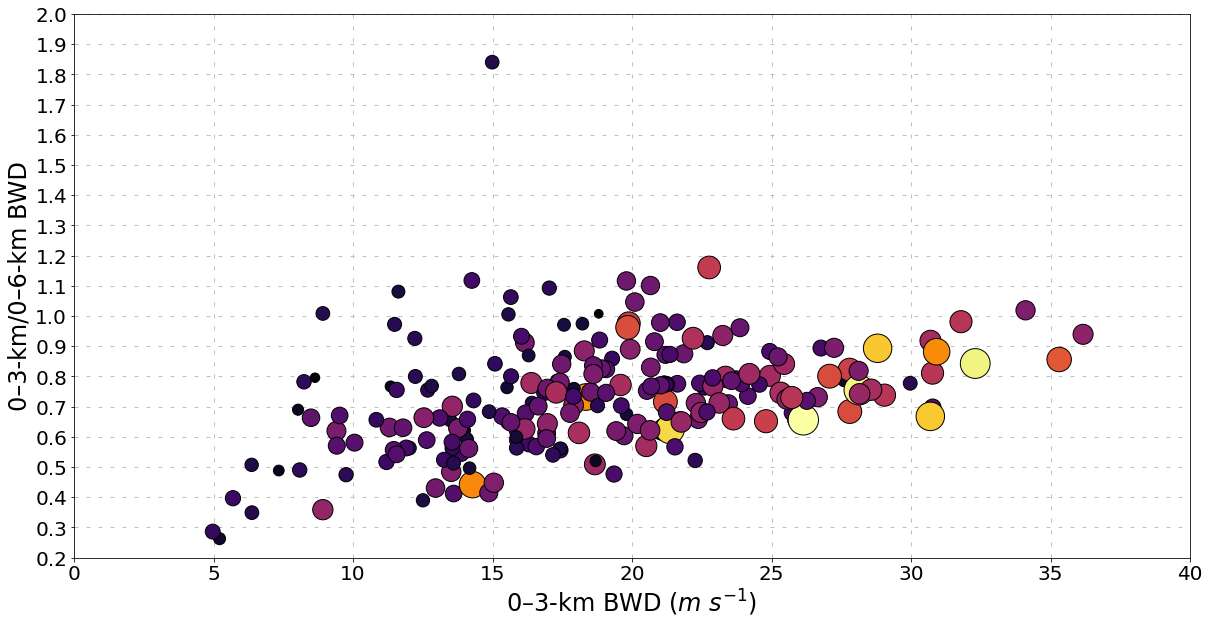

<Figure size 1440x720 with 0 Axes>

In [30]:
#----------------------------------------------------------------------
# Compare normalized shear tests to peak AzShear for Tony.
#----------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

p = 4 # pick the percentile (25,50,75,90,95,98)

var1 = shr03_all[:,p]
var2 = shr03_all[:,p] / shr06_all[:,p]

azshear_inds = np.where(azshear_percs[:,p] == azshear_percs[:,p])[0]
var1_inds = np.where(var1 == var1)[0]
var2_inds = np.where(var2 == var2)[0]

all_inds = []
for s in np.arange(0,num_storms):
    var1_good = 'N'
    var2_good = 'N'
    azshear_good = 'N'
    
    if len(np.where(var1_inds == s)[0]) > 0:
        var1_good = 'Y'
    if len(np.where(var2_inds == s)[0]) > 0:
        var2_good = 'Y'
    if len(np.where(azshear_inds == s)[0]) > 0:
        azshear_good = 'Y'
        
    if (var1_good == 'Y') & (var2_good == 'Y') & (azshear_good == 'Y'):
        all_inds.append(s)
        
all_inds = np.array(all_inds)

azshearf = azshear_percs[all_inds,p]
var1f = var1[all_inds]
var2f = var2[all_inds]

plt.scatter(var1f,var2f,c=azshearf,s=azshearf*20000,ec='k',cmap='inferno',zorder=5)

# --- axis specificiations ---
plt.xlim(0,40)
xticks = np.arange(0,45,5)
plt.xticks(fontsize=20)
plt.xlabel('0–3-km BWD ($m$ $s^{-1}$)',fontsize=24)

plt.ylim(0.2,2)
yticks = np.arange(0.2,2.1,0.1)
plt.yticks(yticks,fontsize=20)
plt.ylabel('0–3-km/0–6-km BWD',fontsize=24)

# --- colorbar specifications ---
# cb = plt.colorbar(extend='max')
# labels = ['','0.005 $s^{-1}$','0.010','0.015','0.020','0.025','0.030','0.035','0.040','0.045']
# cb.ax.set_yticklabels(labels)
# cb.ax.tick_params(labelsize=20)

plt.grid(ls=(0,(5,10)),zorder=0)

folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
         'plots/NEW-SFCOA/azshr-bulk-params/'
file = '2D-03bwd-0306bwd-scatter-noCB'

# plt.savefig(folder+file+'-'+str(percs[p]),dpi=200)

plt.show()
plt.clf()





(19, 9)


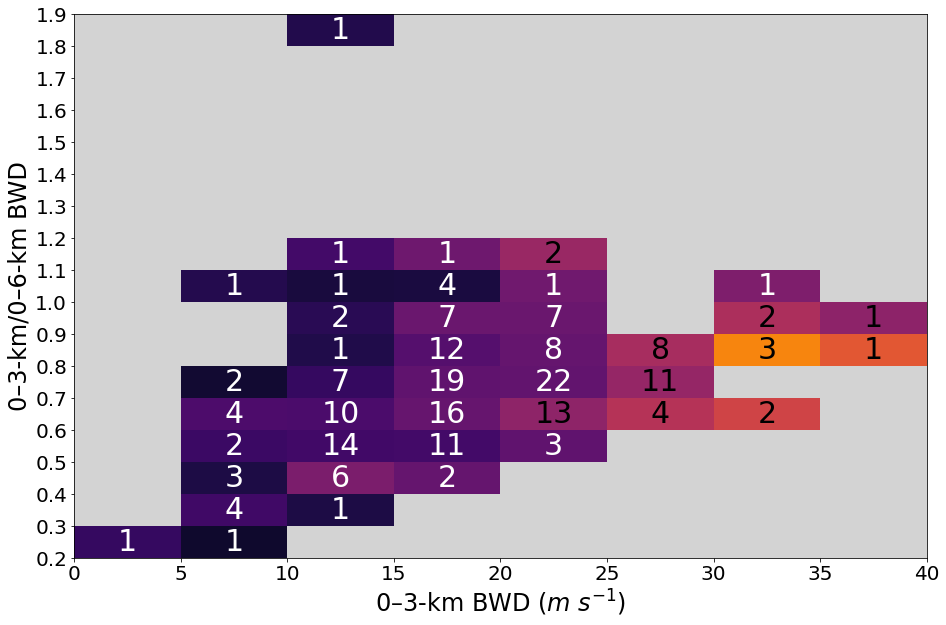

<Figure size 1440x720 with 0 Axes>

In [31]:
#----------------------------------------------------------------------
# Continue comparing normalized shear tests to peak AzShear for Tony.
#----------------------------------------------------------------------
#----------------------------------------------------------------------
# Make a second plot binning the x and y axes and computing mean
# 95-percentile AzShear in each bin.
#
# First compute the bins.
#----------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (20,10)

var1  = var1f
var2  = var2f
azshr = azshearf

b1s = 0
b1e = 45
b1inc = 5
b2s = 0.2
b2e = 2.1
b2inc = 0.1

num_b1 = len(np.arange(b1s,b1e,b1inc))
num_b2 = len(np.arange(b2s,b2e,b2inc))

num_inbin  = np.ones((num_b2,num_b1))*np.nan
mean_azshr = np.ones((num_b2,num_b1))*np.nan

b1c = 0
for b1 in np.arange(b1s,b1e,b1inc):
    b2c = 0
    for b2 in np.arange(b2s,b2e,b2inc):
        # --- define the bin ---
        b1l = b1
        b1h = b1+b1inc
        b2l = b2
        b2h = b2+b2inc
        
#         print('--- BIN',b1,b2,'---')
#         print('MLLCL:',b1l,'–',b1h)
#         print('SRH03:',b2l,'–',b2h)
                
        hit_lcl = np.where((var1 >= b1l) & (var1 < b1h))[0]
        hit_shr = np.where((var2 >= b2l) & (var2 < b2h))[0]
        
        hits = []
        
        for h in np.arange(0,len(hit_lcl)):
            question_hit = np.where(hit_shr == hit_lcl[h])[0]
            if question_hit == question_hit:
                hits.append(hit_lcl[h])
                    
        hits = np.array(hits)
        
#         print('Number of hits:',hits)
        
        if len(hits) >= 1:
            azshr_bin = []
            for i in np.arange(0,len(hits)):
                azshr_bin.append(azshr[hits[i]])
                
            azshr_bin = np.array(azshr_bin)
            mean_azshr[b2c,b1c] = np.mean(azshr_bin)
            num_inbin[b2c,b1c] = len(hits)
            
#             print(num_inbin[b1c,b2c],mean_azshr[b1c,b2c])
            
        b2c += 1
        
    b1c += 1
    
#----------------------------------------------------------------------
# Now plot!
#----------------------------------------------------------------------
xs = np.arange(b1s,b1e,b1inc)
ys = np.arange(b2s,b2e,b2inc)

print(np.shape(mean_azshr))
plt.imshow(mean_azshr,cmap='inferno',aspect=0.3,vmin=0.00375,vmax=0.046)
plt.gca().invert_yaxis()

ax = plt.gca()
ax.set_facecolor('lightgray')

xticks = np.arange(-0.5,8.5)
xlabels = np.arange(0,45,5)
plt.xticks(xticks,labels=xlabels,fontsize=20)
plt.xlabel('0–3-km BWD ($m$ $s^{-1}$)',fontsize=24)

yticks = np.arange(-0.5,18.5)
ylabels = np.round(np.arange(0.2,2.1,0.1),1)
plt.yticks(yticks,labels=ylabels,fontsize=20)
plt.ylabel('0–3-km/0–6-km BWD',fontsize=24)

plt.xlim(-0.5,7.5)
plt.ylim(-0.5,16.5)

xcount = 0
for x in xs:
    ycount = 0
    for y in ys:
        if num_inbin[ycount,xcount] == num_inbin[ycount,xcount]:            
            if mean_azshr[ycount,xcount] < 0.02:
                fc = 'white'
            else:
                fc = 'k'
            plt.text(xcount,ycount,int(num_inbin[ycount,xcount]),fontsize=30,\
                     va='center',ha='center',color=fc)
        ycount += 1
    xcount += 1
    
# cb = plt.colorbar(extend='max')
# cb.ax.tick_params(labelsize=20)
# cb.ax.set_yticklabels(['','-0.006 $s^{-1}$','-0.004','-0.002','0','0.002','0.004','0.006'])

folder = '/Users/matthewflournoy/Desktop/stuff/SPC/Projects/2023-MergersEnvironmentAnalysis/' + \
         'plots/NEW-SFCOA/azshr-bulk-params/'
title = '2D-03bwd-0306bwd-bin-noCB'
# plt.savefig(folder+title+'-'+str(percs[p]),dpi=200)

plt.show()
plt.clf()


